# Profiling Optimized Model 2

Second optimization: prune the weights. Tests accuracy with different pruning ratios for both unstructured and structured pruning. Profile with PyTorch the optimized model.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/HPML/Project/2. LSTM/'

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1vM-zopjfUSi4HL-CiFqcT6xajRYR88P3/Project/2. LSTM


In [ ]:
# import libraries

# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# text processing
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = set(stopwords.words('english'))

# pytorch
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

# sklearn
from sklearn.metrics import classification_report, confusion_matrix

# utils
import os
from tqdm import tqdm
tqdm.pandas()
from collections import Counter

# profiling
import time
from torch.profiler import profile, record_function, ProfilerActivity

# pruning
import torch.nn.utils.prune as prune

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## 1. Prepare Dataset

In [ ]:
# read processed data
data = pd.read_csv('Data/imdb_processed.csv')

# get all processed reviews
reviews = data.processed.values
# merge into single variable, separated by whitespaces
words = ' '.join(reviews)
# obtain list of words
words = words.split()

# build vocabulary
counter = Counter(words)
vocab = sorted(counter, key=counter.get, reverse=True)
int2word = dict(enumerate(vocab, 1))
int2word[0] = '<PAD>'
word2int = {word: id for id, word in int2word.items()}

# encode words
reviews_enc = [[word2int[word] for word in review.split()] for review in tqdm(reviews)]

# padding sequences

def pad_features(reviews, pad_id, seq_length=128):
    # features = np.zeros((len(reviews), seq_length), dtype=int)
    features = np.full((len(reviews), seq_length), pad_id, dtype=int)

    for i, row in enumerate(reviews):
        # if seq_length < len(row) then review will be trimmed
        features[i, :len(row)] = np.array(row)[:seq_length]

    return features

seq_length = 256
features = pad_features(reviews_enc, pad_id=word2int['<PAD>'], seq_length=seq_length)

assert len(features) == len(reviews_enc)
assert len(features[0]) == seq_length

# get labels as numpy
labels = data.label.to_numpy()

100%|██████████| 50000/50000 [00:01<00:00, 29225.52it/s]


## 2. Create sets and loaders

In [ ]:
# train test split
train_size = .7     # we will use 70% of whole data as train set
val_size = .5       # and we will use 50% of test set as validation set

# make train set
split_id = int(len(features) * train_size)
train_x, remain_x = features[:split_id], features[split_id:]
train_y, remain_y = labels[:split_id], labels[split_id:]
# take only half of the examples
train_x = train_x[:train_x.shape[0]//2]
remain_x = remain_x[:remain_x.shape[0]//2]
train_y = train_y[:train_y.shape[0]//2]
remain_y = remain_y[:remain_y.shape[0]//2]

# make val and test set
split_val_id = int(len(remain_x) * val_size)
val_x, test_x = remain_x[:split_val_id], remain_x[split_val_id:]
val_y, test_y = remain_y[:split_val_id], remain_y[split_val_id:]

# print out the shape
print('Feature Shapes:')
print('===============')
print('Train set: {}'.format(train_x.shape))
print('Validation set: {}'.format(val_x.shape))
print('Test set: {}'.format(test_x.shape))

print('\nTarget Distribution (#labels = 0, #labels = 1):')
print('===============')
print(len(train_y[train_y == 0]), len(train_y[train_y == 1]))
print(len(val_y[val_y == 0]), len(val_y[val_y == 1]))
print(len(test_y[test_y == 0]), len(test_y[test_y == 1]))

# define batch size
batch_size = 128

# create tensor datasets
trainset = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
validset = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
testset = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# create dataloaders
trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size, num_workers=0, pin_memory=True)
valloader = DataLoader(validset, shuffle=True, batch_size=batch_size, num_workers=0, pin_memory=True)
testloader = DataLoader(testset, shuffle=True, batch_size=batch_size, num_workers=0, pin_memory=True)

# check our batches
dataiter = iter(trainloader)
x, y = next(dataiter)

print('\nBatches and dataloaders:')
print('===============')
print('Sample batch size: ', x.size())   # batch_size, seq_length
print('Sample batch input: \n', x)
print()
print('Sample label size: ', y.size())   # batch_size
print('Sample label input: \n', y)

# define training device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('\ndevice = '+str(device))

Feature Shapes:
Train set: (17500, 256)
Validation set: (3750, 256)
Test set: (3750, 256)

Target Distribution (#labels = 0, #labels = 1):
8863 8637
1864 1886
1889 1861

Batches and dataloaders:
Sample batch size:  torch.Size([128, 256])
Sample batch input: 
 tensor([[ 1136,   693,    91,  ...,     0,     0,     0],
        [ 4156,   485,     5,  ...,     0,     0,     0],
        [    3,    56, 11545,  ...,     0,     0,     0],
        ...,
        [12705,   332,     6,  ...,     0,     0,     0],
        [11522,    35,   229,  ...,  1084, 28651,   483],
        [  191,   447,   124,  ...,  1338,    84,   508]])

Sample label size:  torch.Size([128])
Sample label input: 
 tensor([0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 

## 3. Modelling

In [ ]:
# model architecture

class SentimentModel(nn.Module):
    def __init__(self, vocab_size, output_size, hidden_size=128, embedding_size=400, n_layers=2, dropout=0.2):
        super(SentimentModel, self).__init__()

        # embedding layer is useful to map input into vector representation
        self.embedding = nn.Embedding(vocab_size, embedding_size)

        # LSTM layer preserved by PyTorch library
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, dropout=dropout, batch_first=True)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # Linear layer for output
        self.fc = nn.Linear(hidden_size, output_size)

        # Sigmoid layer cz we will have binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        
        # convert feature to long
        x = x.long()

        # map input to vector
        x = self.embedding(x)

        # pass forward to lstm
        o, _ =  self.lstm(x)

        # get last sequence output
        o = o[:, -1, :]

        # apply dropout and fully connected layer
        o = self.dropout(o)
        o = self.fc(o)

        # sigmoid
        o = self.sigmoid(o)

        return o

# model hyperparamters
vocab_size = len(word2int)
output_size = 1
embedding_size = 256
hidden_size = 512
n_layers = 2
dropout=0.25

# model number of learnable params
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# model number of learnable params
def count_nonzero_parameters(model):
    return sum(torch.count_nonzero(p.data).item() for p in model.parameters() if p.requires_grad)

# model size
def get_model_size(model):
    with open('temp.pt', 'wb') as f:
        torch.save(model.state_dict(), f)
    size = os.path.getsize('temp.pt')
    print(f"Model size: {size / (1024 * 1024):.2f} MB")
    os.remove('temp.pt')

In [ ]:
# model initialization
ref_model = SentimentModel(vocab_size, output_size, hidden_size, embedding_size, n_layers, dropout)
print(ref_model)
print(f'The model has {count_parameters(ref_model):,} trainable parameters')
get_model_size(ref_model)

SentimentModel(
  (embedding): Embedding(121301, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
The model has 34,731,777 trainable parameters
Model size: 132.49 MB


## 4. Training and Testing - Unstructured Pruning Ratio Comparison

In [ ]:
# Function that tells us how long segments take
def segment_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def segment_time2(start_time, end_time):
  return end_time - start_time

In [ ]:
profile_training = False
profile_testing = False

def run_model(profile_training, profile_testing):

    global train_prof
    global valid_prof
    global test_prof
    global secs

    start_time = time.perf_counter()

    # Training
    if profile_training:
        handler = torch.profiler.tensorboard_trace_handler('Profiling_results/v2_train_results')
        with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True, profile_memory=True, on_trace_ready=handler) as train_prof:
            run_train_model()
    else:
        run_train_model()

    # Testing
    if profile_testing:
        handler = torch.profiler.tensorboard_trace_handler('Profiling_results/v2_test_results')
        with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True, profile_memory=True, on_trace_ready=handler) as test_prof:
            test_acc = run_test_model()
    else:
        test_acc = run_test_model()

    end_time = time.perf_counter()
    secs = segment_time2(start_time, end_time)

    print('Time:')
    print('===============')
    print(f'Overall Time: {secs}s')
    print(f'Total train Time: {train_secs}s')
    print(f'Total validation Time: {valid_secs}s')
    print(f'Total test Time: {test_secs}s')
    print(f'Train Time per epoch: {train_secs/epochs}s')
    print(f'Validation per epoch: {valid_secs/epochs}s')

    return test_acc

def run_train_model():

    global train_secs
    global valid_secs
    global history
    global model
    global optim
    global criterion
    global epochs
    global device
    global trainloader
    global valloader

    # train loop
    model = model.to(device)
    epochloop = tqdm(range(epochs), position=0, desc='Training', leave=True)

    # early stop trigger
    es_trigger = 0
    val_loss_min = torch.inf

    for e in epochloop:

        #################
        # training mode #
        #################

        train_start_time = time.perf_counter()

        model.train()

        train_loss = 0
        train_acc = 0

        for id, (feature, target) in enumerate(trainloader):
            # add epoch meta info
            epochloop.set_postfix_str(f'Training batch {id}/{len(trainloader)}')

            # move to device
            feature, target = feature.to(device), target.to(device)

            # reset optimizer
            optim.zero_grad()

            # forward pass
            out = model(feature)

            # acc
            predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
            equals = predicted == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            train_acc += acc.item()

            # loss
            loss = criterion(out.squeeze(), target.float())
            train_loss += loss.item()
            loss.backward()

            # clip grad
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            # update optimizer
            optim.step()

            # free some memory
            del feature, target, predicted

            history['train_loss'].append(train_loss / len(trainloader))
            history['train_acc'].append(train_acc / len(trainloader))

        train_end_time = time.perf_counter()
        train_secs += segment_time2(train_start_time, train_end_time)

        valid_start_time = time.perf_counter()

        ####################
        # validation mode  #
        ####################

        model.eval()

        val_loss = 0
        val_acc = 0

        with torch.no_grad():
            for id, (feature, target) in enumerate(valloader):
                # add epoch meta info
                epochloop.set_postfix_str(f'Validation batch {id}/{len(valloader)}')
                  
                # move to device
                feature, target = feature.to(device), target.to(device)

                # forward pass
                out = model(feature)

                # acc
                predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
                equals = predicted == target
                acc = torch.mean(equals.type(torch.FloatTensor))
                val_acc += acc.item()

                # loss
                loss = criterion(out.squeeze(), target.float())
                val_loss += loss.item()

                # free some memory
                del feature, target, predicted

            history['val_loss'].append(val_loss / len(valloader))
            history['val_acc'].append(val_acc / len(valloader))

        # reset model mode
        model.train()

        # add epoch meta info
        epochloop.set_postfix_str(f'Val Loss: {val_loss / len(valloader):.3f} | Val Acc: {val_acc / len(valloader):.3f}')

        # print epoch
        if (e+1) % print_every == 0:
              epochloop.write(f'Epoch {e+1}/{epochs} | Train Loss: {train_loss / len(trainloader):.3f} Train Acc: {train_acc / len(trainloader):.3f} | Val Loss: {val_loss / len(valloader):.3f} Val Acc: {val_acc / len(valloader):.3f}')
              epochloop.update()

        # save model if validation loss decrease
        if val_loss / len(valloader) <= val_loss_min:
              torch.save(model.state_dict(), 'Checkpoints/v2_sentiment_lstm.pt')
              val_loss_min = val_loss / len(valloader)
              es_trigger = 0
        else:
              epochloop.write(f'[WARNING] Validation loss did not improved ({val_loss_min:.3f} --> {val_loss / len(valloader):.3f})')
              es_trigger += 1

        # force early stop
        if es_trigger >= es_limit:
            epochloop.write(f'Early stopped at Epoch-{e+1}')
            # update epochs history
            history['epochs'] = e+1
            #break

        valid_end_time = time.perf_counter()
        valid_secs += segment_time2(valid_start_time, valid_end_time)

def run_test_model():

    global test_secs
    global history
    global model
    global optim
    global criterion
    global epochs
    global device
    global testloader

    test_start_time = time.perf_counter()

    # test loop
    #################
    #   test mode   #
    #################

    #with record_function("test_eval_func"):
    model.eval()

    # metrics
    test_loss = 0
    test_acc = 0

    all_target = []
    all_predicted = []

    testloop = tqdm(testloader, leave=True, desc='Inference')
    with torch.no_grad():
        for feature, target in testloop:

            #with record_function("test_move_to_device"):
            feature, target = feature.to(device), target.to(device)

            #with record_function("test_forward_pass"):
            out = model(feature)
            
            with record_function("test_accuracy"):
                predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
                equals = predicted == target
                acc = torch.mean(equals.type(torch.FloatTensor))
                test_acc += acc.item()

            with record_function("test_loss"):
                loss = criterion(out.squeeze(), target.float())
                test_loss += loss.item()

            all_target.extend(target.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

        print(f'Accuracy: {test_acc/len(testloader):.4f}, Loss: {test_loss/len(testloader):.4f}')

    test_end_time = time.perf_counter()
    test_secs = segment_time2(test_start_time, test_end_time)

    return test_acc/len(testloader)

In [ ]:
# Get all learnable parameters
ref_model = SentimentModel(vocab_size, output_size, hidden_size, embedding_size, n_layers, dropout)
model_modules_and_params = ref_model.state_dict().keys()

# For each possible param, each possible layer, monitor the accuracy for different pruning ratios
accuracies = {}
for key in model_modules_and_params: 
  accuracies[key] = []
  module_name = key.split('.')[0]
  param = key.split('.')[1]
  print("\n\nmodule = "+module_name+" - param = "+param)

  for pruning_ratio in [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    print("\n\tpruning_ratio = "+str(pruning_ratio))

    # initialize model
    model = SentimentModel(vocab_size, output_size, hidden_size, embedding_size, n_layers, dropout)
    # training config
    lr = 0.001
    criterion = nn.BCELoss()  # we use BCELoss cz we have binary classification problem
    optim = Adam(model.parameters(), lr=lr)
    grad_clip = 5
    epochs = 4
    print_every = 1
    history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epochs': epochs
    }
    es_limit = 5
    train_prof = None
    valid_prof = None
    test_prof = None
    train_secs = 0
    valid_secs = 0
    test_secs = 0
    secs = 0
    # pruning
    module = getattr(model, module_name)
    prune.random_unstructured(module, name=param, amount=pruning_ratio)
    module._forward_pre_hooks
    get_model_size(ref_model)
    prune.remove(module, param)
    get_model_size(ref_model)
    # run model
    test_accuracy = run_model(profile_training, profile_testing)
    # monitor accuracy
    print("\t\tTest accuracy = "+str(round(test_accuracy,4)))
    accuracies[key].append(test_accuracy)



module = embedding - param = weight

	pruning_ratio = 0
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.73s/it, Val Loss: 0.693 | Val Acc: 0.505]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.508 | Val Loss: 0.693 Val Acc: 0.505


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.14s/it, Val Loss: 0.692 | Val Acc: 0.513]

Epoch 2/4 | Train Loss: 0.690 Train Acc: 0.521 | Val Loss: 0.692 Val Acc: 0.513


Training: 5it [00:45, 12.12s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.662 Train Acc: 0.542 | Val Loss: 0.710 Val Acc: 0.513
[WARNING] Validation loss did not improved (0.692 --> 0.710)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.95s/it, Val Loss: 0.769 | Val Acc: 0.517]


Epoch 4/4 | Train Loss: 0.618 Train Acc: 0.571 | Val Loss: 0.769 Val Acc: 0.517
[WARNING] Validation loss did not improved (0.692 --> 0.769)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.36it/s]


Accuracy: 0.4976, Loss: 0.7933
Time:
Overall Time: 60.79806505099987s
Total train Time: 54.929098595999676s
Total validation Time: 4.858115930999702s
Total test Time: 0.962103689000287s
Train Time per epoch: 13.732274648999919s
Validation per epoch: 1.2145289827499255s
		Test accuracy = 0.4976

	pruning_ratio = 0.1
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.69s/it, Val Loss: 0.699 | Val Acc: 0.500]

Epoch 1/4 | Train Loss: 0.695 Train Acc: 0.501 | Val Loss: 0.699 Val Acc: 0.500


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.15s/it, Val Loss: 0.694 | Val Acc: 0.497]

Epoch 2/4 | Train Loss: 0.697 Train Acc: 0.504 | Val Loss: 0.694 Val Acc: 0.497


Training: 100%|██████████| 4/4 [00:44<00:00, 12.12s/it, Val Loss: 0.693 | Val Acc: 0.498]

Epoch 3/4 | Train Loss: 0.695 Train Acc: 0.501 | Val Loss: 0.693 Val Acc: 0.498


Training: 100%|██████████| 4/4 [01:00<00:00, 15.04s/it, Val Loss: 0.695 | Val Acc: 0.495]


Epoch 4/4 | Train Loss: 0.694 Train Acc: 0.510 | Val Loss: 0.695 Val Acc: 0.495
[WARNING] Validation loss did not improved (0.693 --> 0.695)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.67it/s]


Accuracy: 0.5061, Loss: 0.6938
Time:
Overall Time: 61.16738522800006s
Total train Time: 54.93840288699903s
Total validation Time: 5.228592603999459s
Total test Time: 0.951416922000135s
Train Time per epoch: 13.734600721749757s
Validation per epoch: 1.3071481509998648s
		Test accuracy = 0.5061

	pruning_ratio = 0.2
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.75s/it, Val Loss: 0.698 | Val Acc: 0.497]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.509 | Val Loss: 0.698 Val Acc: 0.497


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.14s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.694 Train Acc: 0.509 | Val Loss: 0.729 Val Acc: 0.498
[WARNING] Validation loss did not improved (0.698 --> 0.729)


Training: 5it [00:44, 11.96s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.685 Train Acc: 0.525 | Val Loss: 0.813 Val Acc: 0.506
[WARNING] Validation loss did not improved (0.698 --> 0.813)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.84s/it, Val Loss: 0.706 | Val Acc: 0.514]


Epoch 4/4 | Train Loss: 0.663 Train Acc: 0.539 | Val Loss: 0.706 Val Acc: 0.514
[WARNING] Validation loss did not improved (0.698 --> 0.706)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.55it/s]


Accuracy: 0.5058, Loss: 0.7115
Time:
Overall Time: 60.359719398999914s
Total train Time: 54.92749343399828s
Total validation Time: 4.427046407000489s
Total test Time: 0.9568093469997621s
Train Time per epoch: 13.73187335849957s
Validation per epoch: 1.1067616017501223s
		Test accuracy = 0.5058

	pruning_ratio = 0.3
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.73s/it, Val Loss: 0.693 | Val Acc: 0.506]

Epoch 1/4 | Train Loss: 0.695 Train Acc: 0.493 | Val Loss: 0.693 Val Acc: 0.506


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.16s/it, Val Loss: 0.692 | Val Acc: 0.507]

Epoch 2/4 | Train Loss: 0.690 Train Acc: 0.518 | Val Loss: 0.692 Val Acc: 0.507


Training: 5it [00:45, 12.14s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.676 Train Acc: 0.538 | Val Loss: 0.713 Val Acc: 0.507
[WARNING] Validation loss did not improved (0.692 --> 0.713)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.96s/it, Val Loss: 0.756 | Val Acc: 0.511]


Epoch 4/4 | Train Loss: 0.628 Train Acc: 0.566 | Val Loss: 0.756 Val Acc: 0.511
[WARNING] Validation loss did not improved (0.692 --> 0.756)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.54it/s]


Accuracy: 0.4959, Loss: 0.7647
Time:
Overall Time: 60.83169703300064s
Total train Time: 54.97766366000087s
Total validation Time: 4.853051864998633s
Total test Time: 0.956425893999949s
Train Time per epoch: 13.744415915000218s
Validation per epoch: 1.2132629662496583s
		Test accuracy = 0.4959

	pruning_ratio = 0.4
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.68s/it, Val Loss: 0.694 | Val Acc: 0.497]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.505 | Val Loss: 0.694 Val Acc: 0.497


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.15s/it, Val Loss: 0.693 | Val Acc: 0.506]

Epoch 2/4 | Train Loss: 0.693 Train Acc: 0.514 | Val Loss: 0.693 Val Acc: 0.506


Training: 5it [00:45, 12.14s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.674 Train Acc: 0.531 | Val Loss: 0.698 Val Acc: 0.506
[WARNING] Validation loss did not improved (0.693 --> 0.698)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.94s/it, Val Loss: 0.733 | Val Acc: 0.511]


Epoch 4/4 | Train Loss: 0.640 Train Acc: 0.565 | Val Loss: 0.733 Val Acc: 0.511
[WARNING] Validation loss did not improved (0.693 --> 0.733)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.66it/s]


Accuracy: 0.5038, Loss: 0.7298
Time:
Overall Time: 60.75822680900001s
Total train Time: 54.97421623399987s
Total validation Time: 4.7804121440003655s
Total test Time: 0.9533488180004497s
Train Time per epoch: 13.743554058499967s
Validation per epoch: 1.1951030360000914s
		Test accuracy = 0.5038

	pruning_ratio = 0.5
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.71s/it, Val Loss: 0.693 | Val Acc: 0.509]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.496 | Val Loss: 0.693 Val Acc: 0.509


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.14s/it, Val Loss: 0.692 | Val Acc: 0.511]

Epoch 2/4 | Train Loss: 0.691 Train Acc: 0.522 | Val Loss: 0.692 Val Acc: 0.511


Training: 5it [00:45, 12.12s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.671 Train Acc: 0.540 | Val Loss: 0.701 Val Acc: 0.510
[WARNING] Validation loss did not improved (0.692 --> 0.701)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.93s/it, Val Loss: 0.726 | Val Acc: 0.524]


Epoch 4/4 | Train Loss: 0.627 Train Acc: 0.573 | Val Loss: 0.726 Val Acc: 0.524
[WARNING] Validation loss did not improved (0.692 --> 0.726)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.03it/s]


Accuracy: 0.5031, Loss: 0.7354
Time:
Overall Time: 60.74398666199977s
Total train Time: 54.93864523299908s
Total validation Time: 4.785127854000166s
Total test Time: 0.9720117239994579s
Train Time per epoch: 13.73466130824977s
Validation per epoch: 1.1962819635000415s
		Test accuracy = 0.5031

	pruning_ratio = 0.6
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.71s/it, Val Loss: 0.693 | Val Acc: 0.503]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.508 | Val Loss: 0.693 Val Acc: 0.503


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.14s/it, Val Loss: 0.692 | Val Acc: 0.516]

Epoch 2/4 | Train Loss: 0.690 Train Acc: 0.521 | Val Loss: 0.692 Val Acc: 0.516


Training: 5it [00:45, 12.13s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.678 Train Acc: 0.529 | Val Loss: 0.696 Val Acc: 0.516
[WARNING] Validation loss did not improved (0.692 --> 0.696)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.94s/it, Val Loss: 0.716 | Val Acc: 0.512]


Epoch 4/4 | Train Loss: 0.637 Train Acc: 0.561 | Val Loss: 0.716 Val Acc: 0.512
[WARNING] Validation loss did not improved (0.692 --> 0.716)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.68it/s]


Accuracy: 0.5269, Loss: 0.7177
Time:
Overall Time: 60.74326182099958s
Total train Time: 54.92455189300108s
Total validation Time: 4.8185053379993406s
Total test Time: 0.9515876359992035s
Train Time per epoch: 13.73113797325027s
Validation per epoch: 1.2046263344998351s
		Test accuracy = 0.5269

	pruning_ratio = 0.7
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.68s/it, Val Loss: 0.694 | Val Acc: 0.504]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.501 | Val Loss: 0.694 Val Acc: 0.504


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.17s/it, Val Loss: 0.694 | Val Acc: 0.500]

Epoch 2/4 | Train Loss: 0.694 Train Acc: 0.501 | Val Loss: 0.694 Val Acc: 0.500


Training: 5it [00:45, 12.18s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.693 Train Acc: 0.506 | Val Loss: 0.694 Val Acc: 0.501
[WARNING] Validation loss did not improved (0.694 --> 0.694)


Training: 6it [00:59,  9.63s/it, Val Loss: 0.693 | Val Acc: 0.504]

Epoch 4/4 | Train Loss: 0.689 Train Acc: 0.518 | Val Loss: 0.693 Val Acc: 0.504


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.43it/s]


Accuracy: 0.5133, Loss: 0.6944
Time:
Overall Time: 61.29650899399985s
Total train Time: 55.02180985099858s
Total validation Time: 5.258695475999957s
Total test Time: 0.9596253380004782s
Train Time per epoch: 13.755452462749645s
Validation per epoch: 1.3146738689999893s
		Test accuracy = 0.5133

	pruning_ratio = 0.8
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.74s/it, Val Loss: 0.713 | Val Acc: 0.501]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.504 | Val Loss: 0.713 Val Acc: 0.501


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.21s/it, Val Loss: 0.692 | Val Acc: 0.507]

Epoch 2/4 | Train Loss: 0.693 Train Acc: 0.514 | Val Loss: 0.692 Val Acc: 0.507


Training: 100%|██████████| 4/4 [00:45<00:00, 12.15s/it, Val Loss: 0.686 | Val Acc: 0.503]

Epoch 3/4 | Train Loss: 0.690 Train Acc: 0.520 | Val Loss: 0.686 Val Acc: 0.503


Training: 100%|██████████| 4/4 [01:00<00:00, 15.07s/it, Val Loss: 0.686 | Val Acc: 0.500]


Epoch 4/4 | Train Loss: 0.689 Train Acc: 0.524 | Val Loss: 0.686 Val Acc: 0.500
[WARNING] Validation loss did not improved (0.686 --> 0.686)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.36it/s]


Accuracy: 0.4994, Loss: 0.6834
Time:
Overall Time: 61.27669474199956s
Total train Time: 55.08050068400007s
Total validation Time: 5.184617122000418s
Total test Time: 0.9637843209993662s
Train Time per epoch: 13.770125171000018s
Validation per epoch: 1.2961542805001045s
		Test accuracy = 0.4994

	pruning_ratio = 0.9
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.70s/it, Val Loss: 0.696 | Val Acc: 0.497]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.504 | Val Loss: 0.696 Val Acc: 0.497


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.15s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.685 Train Acc: 0.542 | Val Loss: 0.704 Val Acc: 0.502
[WARNING] Validation loss did not improved (0.696 --> 0.704)


Training: 5it [00:44, 12.00s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.660 Train Acc: 0.552 | Val Loss: 0.705 Val Acc: 0.518
[WARNING] Validation loss did not improved (0.696 --> 0.705)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.86s/it, Val Loss: 0.717 | Val Acc: 0.516]


Epoch 4/4 | Train Loss: 0.610 Train Acc: 0.607 | Val Loss: 0.717 Val Acc: 0.516
[WARNING] Validation loss did not improved (0.696 --> 0.717)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.78it/s]


Accuracy: 0.5262, Loss: 0.7178
Time:
Overall Time: 60.440008128000045s
Total train Time: 54.94039998399967s
Total validation Time: 4.497880603998965s
Total test Time: 0.9491125269996701s
Train Time per epoch: 13.735099995999917s
Validation per epoch: 1.1244701509997412s
		Test accuracy = 0.5262


module = lstm - param = weight_ih_l0

	pruning_ratio = 0
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.72s/it, Val Loss: 0.693 | Val Acc: 0.503]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.505 | Val Loss: 0.693 Val Acc: 0.503


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.18s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.692 Train Acc: 0.514 | Val Loss: 0.693 Val Acc: 0.513
[WARNING] Validation loss did not improved (0.693 --> 0.693)


Training: 100%|██████████| 4/4 [00:44<00:00, 11.99s/it, Val Loss: 0.692 | Val Acc: 0.513]

Epoch 3/4 | Train Loss: 0.679 Train Acc: 0.526 | Val Loss: 0.692 Val Acc: 0.513


Training: 100%|██████████| 4/4 [00:59<00:00, 14.98s/it, Val Loss: 0.726 | Val Acc: 0.516]


Epoch 4/4 | Train Loss: 0.640 Train Acc: 0.558 | Val Loss: 0.726 Val Acc: 0.516
[WARNING] Validation loss did not improved (0.692 --> 0.726)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.39it/s]


Accuracy: 0.5171, Loss: 0.7450
Time:
Overall Time: 60.916364312999576s
Total train Time: 55.02957427900037s
Total validation Time: 4.8777138030009155s
Total test Time: 0.9605274449995704s
Train Time per epoch: 13.757393569750093s
Validation per epoch: 1.2194284507502289s
		Test accuracy = 0.5171

	pruning_ratio = 0.1
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.74s/it, Val Loss: 0.695 | Val Acc: 0.499]

Epoch 1/4 | Train Loss: 0.695 Train Acc: 0.504 | Val Loss: 0.695 Val Acc: 0.499


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.16s/it, Val Loss: 0.693 | Val Acc: 0.500]

Epoch 2/4 | Train Loss: 0.693 Train Acc: 0.505 | Val Loss: 0.693 Val Acc: 0.500


Training: 5it [00:45, 12.14s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.693 Train Acc: 0.505 | Val Loss: 0.695 Val Acc: 0.495
[WARNING] Validation loss did not improved (0.693 --> 0.695)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.96s/it, Val Loss: 0.694 | Val Acc: 0.504]


Epoch 4/4 | Train Loss: 0.691 Train Acc: 0.514 | Val Loss: 0.694 Val Acc: 0.504
[WARNING] Validation loss did not improved (0.693 --> 0.694)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.57it/s]


Accuracy: 0.5108, Loss: 0.6949
Time:
Overall Time: 60.83250065700031s
Total train Time: 54.98499002599965s
Total validation Time: 4.839806290000524s
Total test Time: 0.9574530339996272s
Train Time per epoch: 13.746247506499913s
Validation per epoch: 1.209951572500131s
		Test accuracy = 0.5108

	pruning_ratio = 0.2
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.75s/it, Val Loss: 0.695 | Val Acc: 0.507]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.507 | Val Loss: 0.695 Val Acc: 0.507


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.16s/it, Val Loss: 0.694 | Val Acc: 0.503]

Epoch 2/4 | Train Loss: 0.695 Train Acc: 0.516 | Val Loss: 0.694 Val Acc: 0.503


Training: 5it [00:45, 12.15s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.679 Train Acc: 0.530 | Val Loss: 0.695 Val Acc: 0.492
[WARNING] Validation loss did not improved (0.694 --> 0.695)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.96s/it, Val Loss: 0.718 | Val Acc: 0.509]


Epoch 4/4 | Train Loss: 0.673 Train Acc: 0.542 | Val Loss: 0.718 Val Acc: 0.509
[WARNING] Validation loss did not improved (0.694 --> 0.718)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.24it/s]


Accuracy: 0.4941, Loss: 0.7189
Time:
Overall Time: 60.86621005000052s
Total train Time: 55.02654282399908s
Total validation Time: 4.8249213859980955s
Total test Time: 0.9654764999995677s
Train Time per epoch: 13.75663570599977s
Validation per epoch: 1.2062303464995239s
		Test accuracy = 0.4941

	pruning_ratio = 0.3
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.75s/it, Val Loss: 0.693 | Val Acc: 0.502]

Epoch 1/4 | Train Loss: 0.695 Train Acc: 0.498 | Val Loss: 0.693 Val Acc: 0.502


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.15s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.688 Train Acc: 0.519 | Val Loss: 0.694 Val Acc: 0.511
[WARNING] Validation loss did not improved (0.693 --> 0.694)


Training: 5it [00:44, 12.01s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.664 Train Acc: 0.542 | Val Loss: 0.713 Val Acc: 0.505
[WARNING] Validation loss did not improved (0.693 --> 0.713)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.89s/it, Val Loss: 0.749 | Val Acc: 0.513]


Epoch 4/4 | Train Loss: 0.620 Train Acc: 0.566 | Val Loss: 0.749 Val Acc: 0.513
[WARNING] Validation loss did not improved (0.693 --> 0.749)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.27it/s]


Accuracy: 0.4990, Loss: 0.7434
Time:
Overall Time: 60.56162025899994s
Total train Time: 55.08141669199995s
Total validation Time: 4.465119135999885s
Total test Time: 0.9656679309991887s
Train Time per epoch: 13.770354172999987s
Validation per epoch: 1.1162797839999712s
		Test accuracy = 0.499

	pruning_ratio = 0.4
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.73s/it, Val Loss: 0.693 | Val Acc: 0.502]

Epoch 1/4 | Train Loss: 0.695 Train Acc: 0.495 | Val Loss: 0.693 Val Acc: 0.502


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.14s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.690 Train Acc: 0.518 | Val Loss: 0.693 Val Acc: 0.504
[WARNING] Validation loss did not improved (0.693 --> 0.693)


Training: 5it [00:44, 11.96s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.674 Train Acc: 0.540 | Val Loss: 0.694 Val Acc: 0.515
[WARNING] Validation loss did not improved (0.693 --> 0.694)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.84s/it, Val Loss: 0.730 | Val Acc: 0.507]


Epoch 4/4 | Train Loss: 0.633 Train Acc: 0.565 | Val Loss: 0.730 Val Acc: 0.507
[WARNING] Validation loss did not improved (0.693 --> 0.730)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.11it/s]


Accuracy: 0.5172, Loss: 0.7413
Time:
Overall Time: 60.38935153700004s
Total train Time: 54.959746568999435s
Total validation Time: 4.409206194000944s
Total test Time: 0.9720161179993738s
Train Time per epoch: 13.739936642249859s
Validation per epoch: 1.102301548500236s
		Test accuracy = 0.5172

	pruning_ratio = 0.5
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.73s/it, Val Loss: 0.694 | Val Acc: 0.497]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.506 | Val Loss: 0.694 Val Acc: 0.497


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.16s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.687 Train Acc: 0.523 | Val Loss: 0.698 Val Acc: 0.499
[WARNING] Validation loss did not improved (0.694 --> 0.698)


Training: 5it [00:44, 11.99s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.665 Train Acc: 0.536 | Val Loss: 0.702 Val Acc: 0.517
[WARNING] Validation loss did not improved (0.694 --> 0.702)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.87s/it, Val Loss: 0.730 | Val Acc: 0.517]


Epoch 4/4 | Train Loss: 0.632 Train Acc: 0.569 | Val Loss: 0.730 Val Acc: 0.517
[WARNING] Validation loss did not improved (0.694 --> 0.730)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.48it/s]


Accuracy: 0.5047, Loss: 0.7246
Time:
Overall Time: 60.46871071100031s
Total train Time: 54.99672926599851s
Total validation Time: 4.465988176999417s
Total test Time: 0.9586695549996875s
Train Time per epoch: 13.749182316499628s
Validation per epoch: 1.1164970442498543s
		Test accuracy = 0.5047

	pruning_ratio = 0.6
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.75s/it, Val Loss: 0.694 | Val Acc: 0.498]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.509 | Val Loss: 0.694 Val Acc: 0.498


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.18s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.689 Train Acc: 0.517 | Val Loss: 0.694 Val Acc: 0.510
[WARNING] Validation loss did not improved (0.694 --> 0.694)


Training: 5it [00:44, 12.00s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.665 Train Acc: 0.541 | Val Loss: 0.708 Val Acc: 0.513
[WARNING] Validation loss did not improved (0.694 --> 0.708)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.88s/it, Val Loss: 0.761 | Val Acc: 0.513]


Epoch 4/4 | Train Loss: 0.626 Train Acc: 0.560 | Val Loss: 0.761 Val Acc: 0.513
[WARNING] Validation loss did not improved (0.694 --> 0.761)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.20it/s]


Accuracy: 0.5230, Loss: 0.7484
Time:
Overall Time: 60.52808649899998s
Total train Time: 55.04427290100102s
Total validation Time: 4.467387640001107s
Total test Time: 0.9663124099997731s
Train Time per epoch: 13.761068225250256s
Validation per epoch: 1.1168469100002767s
		Test accuracy = 0.523

	pruning_ratio = 0.7
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.79s/it, Val Loss: 0.693 | Val Acc: 0.502]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.502 | Val Loss: 0.693 Val Acc: 0.502


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.18s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.694 Train Acc: 0.507 | Val Loss: 0.693 Val Acc: 0.497
[WARNING] Validation loss did not improved (0.693 --> 0.693)


Training: 5it [00:44, 11.99s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.694 Train Acc: 0.507 | Val Loss: 0.694 Val Acc: 0.497
[WARNING] Validation loss did not improved (0.693 --> 0.694)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.87s/it, Val Loss: 0.694 | Val Acc: 0.499]


Epoch 4/4 | Train Loss: 0.694 Train Acc: 0.505 | Val Loss: 0.694 Val Acc: 0.499
[WARNING] Validation loss did not improved (0.693 --> 0.694)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.45it/s]


Accuracy: 0.5080, Loss: 0.6928
Time:
Overall Time: 60.489571594000154s
Total train Time: 55.01100163799947s
Total validation Time: 4.4687184770000385s
Total test Time: 0.9598656529997243s
Train Time per epoch: 13.752750409499868s
Validation per epoch: 1.1171796192500096s
		Test accuracy = 0.508

	pruning_ratio = 0.8
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.77s/it, Val Loss: 0.693 | Val Acc: 0.507]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.504 | Val Loss: 0.693 Val Acc: 0.507


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.18s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.693 Train Acc: 0.512 | Val Loss: 0.696 Val Acc: 0.499
[WARNING] Validation loss did not improved (0.693 --> 0.696)


Training: 5it [00:44, 11.99s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.690 Train Acc: 0.516 | Val Loss: 0.700 Val Acc: 0.497
[WARNING] Validation loss did not improved (0.693 --> 0.700)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.87s/it, Val Loss: 0.700 | Val Acc: 0.508]


Epoch 4/4 | Train Loss: 0.672 Train Acc: 0.537 | Val Loss: 0.700 Val Acc: 0.508
[WARNING] Validation loss did not improved (0.693 --> 0.700)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.34it/s]


Accuracy: 0.5114, Loss: 0.7092
Time:
Overall Time: 60.48178484100026s
Total train Time: 54.99087331899955s
Total validation Time: 4.481760783998652s
Total test Time: 0.9634835810002187s
Train Time per epoch: 13.747718329749887s
Validation per epoch: 1.120440195999663s
		Test accuracy = 0.5114

	pruning_ratio = 0.9
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.72s/it, Val Loss: 0.693 | Val Acc: 0.509]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.506 | Val Loss: 0.693 Val Acc: 0.509


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.16s/it, Val Loss: 0.687 | Val Acc: 0.522]

Epoch 2/4 | Train Loss: 0.688 Train Acc: 0.524 | Val Loss: 0.687 Val Acc: 0.522


Training: 5it [00:45, 12.15s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.663 Train Acc: 0.554 | Val Loss: 0.697 Val Acc: 0.512
[WARNING] Validation loss did not improved (0.687 --> 0.697)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.96s/it, Val Loss: 0.742 | Val Acc: 0.521]


Epoch 4/4 | Train Loss: 0.630 Train Acc: 0.561 | Val Loss: 0.742 Val Acc: 0.521
[WARNING] Validation loss did not improved (0.687 --> 0.742)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.28it/s]


Accuracy: 0.5258, Loss: 0.7772
Time:
Overall Time: 60.848481056999844s
Total train Time: 54.993765578999955s
Total validation Time: 4.838907537999148s
Total test Time: 0.9640594419997797s
Train Time per epoch: 13.748441394749989s
Validation per epoch: 1.209726884499787s
		Test accuracy = 0.5258


module = lstm - param = weight_hh_l0

	pruning_ratio = 0
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.74s/it, Val Loss: 0.693 | Val Acc: 0.506]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.502 | Val Loss: 0.693 Val Acc: 0.506


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.17s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.688 Train Acc: 0.522 | Val Loss: 0.694 Val Acc: 0.516
[WARNING] Validation loss did not improved (0.693 --> 0.694)


Training: 5it [00:44, 11.98s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.663 Train Acc: 0.555 | Val Loss: 0.700 Val Acc: 0.511
[WARNING] Validation loss did not improved (0.693 --> 0.700)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.85s/it, Val Loss: 0.746 | Val Acc: 0.512]


Epoch 4/4 | Train Loss: 0.620 Train Acc: 0.564 | Val Loss: 0.746 Val Acc: 0.512
[WARNING] Validation loss did not improved (0.693 --> 0.746)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.61it/s]


Accuracy: 0.5283, Loss: 0.7523
Time:
Overall Time: 60.4096467749996s
Total train Time: 54.9737640860003s
Total validation Time: 4.431070230999467s
Total test Time: 0.9544108440004493s
Train Time per epoch: 13.743441021500075s
Validation per epoch: 1.1077675577498667s
		Test accuracy = 0.5283

	pruning_ratio = 0.1
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.73s/it, Val Loss: 0.693 | Val Acc: 0.512]

Epoch 1/4 | Train Loss: 0.695 Train Acc: 0.504 | Val Loss: 0.693 Val Acc: 0.512


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.19s/it, Val Loss: 0.692 | Val Acc: 0.504]

Epoch 2/4 | Train Loss: 0.686 Train Acc: 0.522 | Val Loss: 0.692 Val Acc: 0.504


Training: 5it [00:45, 12.18s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.659 Train Acc: 0.542 | Val Loss: 0.705 Val Acc: 0.512
[WARNING] Validation loss did not improved (0.692 --> 0.705)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.98s/it, Val Loss: 0.765 | Val Acc: 0.518]


Epoch 4/4 | Train Loss: 0.617 Train Acc: 0.562 | Val Loss: 0.765 Val Acc: 0.518
[WARNING] Validation loss did not improved (0.692 --> 0.765)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.47it/s]


Accuracy: 0.4893, Loss: 0.7740
Time:
Overall Time: 60.93342879900047s
Total train Time: 55.02734502500061s
Total validation Time: 4.9009328599986475s
Total test Time: 0.9582739049992597s
Train Time per epoch: 13.756836256250153s
Validation per epoch: 1.2252332149996619s
		Test accuracy = 0.4893

	pruning_ratio = 0.2
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.74s/it, Val Loss: 0.694 | Val Acc: 0.507]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.499 | Val Loss: 0.694 Val Acc: 0.507


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.17s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.686 Train Acc: 0.517 | Val Loss: 0.706 Val Acc: 0.497
[WARNING] Validation loss did not improved (0.694 --> 0.706)


Training: 5it [00:44, 11.99s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.659 Train Acc: 0.551 | Val Loss: 0.704 Val Acc: 0.508
[WARNING] Validation loss did not improved (0.694 --> 0.704)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.87s/it, Val Loss: 0.767 | Val Acc: 0.509]


Epoch 4/4 | Train Loss: 0.620 Train Acc: 0.578 | Val Loss: 0.767 Val Acc: 0.509
[WARNING] Validation loss did not improved (0.694 --> 0.767)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.29it/s]


Accuracy: 0.5004, Loss: 0.7764
Time:
Overall Time: 60.49034399800075s
Total train Time: 55.030673249000756s
Total validation Time: 4.449174162999952s
Total test Time: 0.9627141380005924s
Train Time per epoch: 13.757668312250189s
Validation per epoch: 1.112293540749988s
		Test accuracy = 0.5004

	pruning_ratio = 0.3
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.73s/it, Val Loss: 0.693 | Val Acc: 0.498]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.497 | Val Loss: 0.693 Val Acc: 0.498


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.16s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.695 Train Acc: 0.509 | Val Loss: 0.694 Val Acc: 0.501
[WARNING] Validation loss did not improved (0.693 --> 0.694)


Training: 5it [00:44, 12.01s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.694 Train Acc: 0.502 | Val Loss: 0.695 Val Acc: 0.499
[WARNING] Validation loss did not improved (0.693 --> 0.695)


Training: 6it [00:59,  9.56s/it, Val Loss: 0.693 | Val Acc: 0.497]

Epoch 4/4 | Train Loss: 0.693 Train Acc: 0.508 | Val Loss: 0.693 Val Acc: 0.497


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.39it/s]


Accuracy: 0.5172, Loss: 0.6921
Time:
Overall Time: 60.915451480999764s
Total train Time: 55.03211988000112s
Total validation Time: 4.86900703900028s
Total test Time: 0.9666261729998951s
Train Time per epoch: 13.75802997000028s
Validation per epoch: 1.21725175975007s
		Test accuracy = 0.5172

	pruning_ratio = 0.4
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.78s/it, Val Loss: 0.693 | Val Acc: 0.502]

Epoch 1/4 | Train Loss: 0.695 Train Acc: 0.502 | Val Loss: 0.693 Val Acc: 0.502


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.17s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.689 Train Acc: 0.518 | Val Loss: 0.695 Val Acc: 0.509
[WARNING] Validation loss did not improved (0.693 --> 0.695)


Training: 5it [00:44, 12.02s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.663 Train Acc: 0.549 | Val Loss: 0.717 Val Acc: 0.602
[WARNING] Validation loss did not improved (0.693 --> 0.717)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.89s/it, Val Loss: 0.757 | Val Acc: 0.512]


Epoch 4/4 | Train Loss: 0.615 Train Acc: 0.586 | Val Loss: 0.757 Val Acc: 0.512
[WARNING] Validation loss did not improved (0.693 --> 0.757)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.40it/s]


Accuracy: 0.5178, Loss: 0.7587
Time:
Overall Time: 60.55284905799999s
Total train Time: 55.025154420001854s
Total validation Time: 4.517073290000553s
Total test Time: 0.9600510939999367s
Train Time per epoch: 13.756288605000464s
Validation per epoch: 1.1292683225001383s
		Test accuracy = 0.5178

	pruning_ratio = 0.5
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.76s/it, Val Loss: 0.693 | Val Acc: 0.507]

Epoch 1/4 | Train Loss: 0.695 Train Acc: 0.504 | Val Loss: 0.693 Val Acc: 0.507


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.17s/it, Val Loss: 0.692 | Val Acc: 0.517]

Epoch 2/4 | Train Loss: 0.686 Train Acc: 0.523 | Val Loss: 0.692 Val Acc: 0.517


Training: 5it [00:45, 12.17s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.658 Train Acc: 0.547 | Val Loss: 0.712 Val Acc: 0.515
[WARNING] Validation loss did not improved (0.692 --> 0.712)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.99s/it, Val Loss: 0.749 | Val Acc: 0.514]


Epoch 4/4 | Train Loss: 0.616 Train Acc: 0.573 | Val Loss: 0.749 Val Acc: 0.514
[WARNING] Validation loss did not improved (0.692 --> 0.749)


Inference: 100%|██████████| 30/30 [00:00<00:00, 30.99it/s]


Accuracy: 0.5131, Loss: 0.7559
Time:
Overall Time: 60.96282507400065s
Total train Time: 55.028898555000524s
Total validation Time: 4.9103132960008224s
Total test Time: 0.972747029999482s
Train Time per epoch: 13.757224638750131s
Validation per epoch: 1.2275783240002056s
		Test accuracy = 0.5131

	pruning_ratio = 0.6
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.77s/it, Val Loss: 0.693 | Val Acc: 0.499]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.501 | Val Loss: 0.693 Val Acc: 0.499


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.17s/it, Val Loss: 0.693 | Val Acc: 0.505]

Epoch 2/4 | Train Loss: 0.691 Train Acc: 0.513 | Val Loss: 0.693 Val Acc: 0.505


Training: 5it [00:45, 12.14s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.669 Train Acc: 0.539 | Val Loss: 0.705 Val Acc: 0.513
[WARNING] Validation loss did not improved (0.693 --> 0.705)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.98s/it, Val Loss: 0.778 | Val Acc: 0.511]


Epoch 4/4 | Train Loss: 0.625 Train Acc: 0.567 | Val Loss: 0.778 Val Acc: 0.511
[WARNING] Validation loss did not improved (0.693 --> 0.778)


Inference: 100%|██████████| 30/30 [00:00<00:00, 30.88it/s]


Accuracy: 0.5124, Loss: 0.7929
Time:
Overall Time: 60.95753157699983s
Total train Time: 55.062440672000776s
Total validation Time: 4.869506936000107s
Total test Time: 0.9772501469997223s
Train Time per epoch: 13.765610168000194s
Validation per epoch: 1.2173767340000268s
		Test accuracy = 0.5124

	pruning_ratio = 0.7
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.80s/it, Val Loss: 0.693 | Val Acc: 0.509]

Epoch 1/4 | Train Loss: 0.695 Train Acc: 0.502 | Val Loss: 0.693 Val Acc: 0.509


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.18s/it, Val Loss: 0.692 | Val Acc: 0.513]

Epoch 2/4 | Train Loss: 0.688 Train Acc: 0.532 | Val Loss: 0.692 Val Acc: 0.513


Training: 5it [00:45, 12.16s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.669 Train Acc: 0.536 | Val Loss: 0.692 Val Acc: 0.522
[WARNING] Validation loss did not improved (0.692 --> 0.692)


Training: 100%|██████████| 4/4 [00:59<00:00, 15.00s/it, Val Loss: 0.723 | Val Acc: 0.524]


Epoch 4/4 | Train Loss: 0.630 Train Acc: 0.567 | Val Loss: 0.723 Val Acc: 0.524
[WARNING] Validation loss did not improved (0.692 --> 0.723)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.04it/s]


Accuracy: 0.5089, Loss: 0.7284
Time:
Overall Time: 61.002544369000134s
Total train Time: 55.084123820999594s
Total validation Time: 4.896494959998563s
Total test Time: 0.974210633000439s
Train Time per epoch: 13.771030955249898s
Validation per epoch: 1.2241237399996407s
		Test accuracy = 0.5089

	pruning_ratio = 0.8
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.75s/it, Val Loss: 0.694 | Val Acc: 0.501]

Epoch 1/4 | Train Loss: 0.695 Train Acc: 0.507 | Val Loss: 0.694 Val Acc: 0.501


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.17s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.688 Train Acc: 0.519 | Val Loss: 0.694 Val Acc: 0.512
[WARNING] Validation loss did not improved (0.694 --> 0.694)


Training: 5it [00:44, 11.98s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.660 Train Acc: 0.538 | Val Loss: 0.716 Val Acc: 0.507
[WARNING] Validation loss did not improved (0.694 --> 0.716)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.87s/it, Val Loss: 0.772 | Val Acc: 0.512]


Epoch 4/4 | Train Loss: 0.614 Train Acc: 0.570 | Val Loss: 0.772 Val Acc: 0.512
[WARNING] Validation loss did not improved (0.694 --> 0.772)


Inference: 100%|██████████| 30/30 [00:00<00:00, 30.42it/s]


Accuracy: 0.4998, Loss: 0.7899
Time:
Overall Time: 60.53401515800033s
Total train Time: 55.004592875001435s
Total validation Time: 4.480039653999484s
Total test Time: 0.9958707410005445s
Train Time per epoch: 13.751148218750359s
Validation per epoch: 1.120009913499871s
		Test accuracy = 0.4998

	pruning_ratio = 0.9
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.75s/it, Val Loss: 0.694 | Val Acc: 0.504]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.506 | Val Loss: 0.694 Val Acc: 0.504


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.17s/it, Val Loss: 0.694 | Val Acc: 0.503]

Epoch 2/4 | Train Loss: 0.694 Train Acc: 0.503 | Val Loss: 0.694 Val Acc: 0.503


Training: 100%|██████████| 4/4 [00:45<00:00, 12.14s/it, Val Loss: 0.693 | Val Acc: 0.498]

Epoch 3/4 | Train Loss: 0.693 Train Acc: 0.508 | Val Loss: 0.693 Val Acc: 0.498


Training: 100%|██████████| 4/4 [01:00<00:00, 15.07s/it, Val Loss: 0.699 | Val Acc: 0.499]


Epoch 4/4 | Train Loss: 0.684 Train Acc: 0.528 | Val Loss: 0.699 Val Acc: 0.499
[WARNING] Validation loss did not improved (0.693 --> 0.699)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.16it/s]


Accuracy: 0.5154, Loss: 0.7010
Time:
Overall Time: 61.30687003300045s
Total train Time: 55.040341385997635s
Total validation Time: 5.24259521300155s
Total test Time: 0.9683678439996584s
Train Time per epoch: 13.760085346499409s
Validation per epoch: 1.3106488032503876s
		Test accuracy = 0.5154


module = lstm - param = bias_ih_l0

	pruning_ratio = 0
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.81s/it, Val Loss: 0.693 | Val Acc: 0.508]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.499 | Val Loss: 0.693 Val Acc: 0.508


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.21s/it, Val Loss: 0.692 | Val Acc: 0.504]

Epoch 2/4 | Train Loss: 0.686 Train Acc: 0.525 | Val Loss: 0.692 Val Acc: 0.504


Training: 5it [00:45, 12.18s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.654 Train Acc: 0.548 | Val Loss: 0.711 Val Acc: 0.513
[WARNING] Validation loss did not improved (0.692 --> 0.711)


Training: 100%|██████████| 4/4 [01:00<00:00, 15.00s/it, Val Loss: 0.754 | Val Acc: 0.510]


Epoch 4/4 | Train Loss: 0.614 Train Acc: 0.566 | Val Loss: 0.754 Val Acc: 0.510
[WARNING] Validation loss did not improved (0.692 --> 0.754)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.35it/s]


Accuracy: 0.5153, Loss: 0.7699
Time:
Overall Time: 61.02544334000049s
Total train Time: 55.136322305997965s
Total validation Time: 4.87489902300149s
Total test Time: 0.9632182229997852s
Train Time per epoch: 13.784080576499491s
Validation per epoch: 1.2187247557503724s
		Test accuracy = 0.5153

	pruning_ratio = 0.1
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.78s/it, Val Loss: 0.694 | Val Acc: 0.501]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.506 | Val Loss: 0.694 Val Acc: 0.501


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.18s/it, Val Loss: 0.692 | Val Acc: 0.512]

Epoch 2/4 | Train Loss: 0.686 Train Acc: 0.521 | Val Loss: 0.692 Val Acc: 0.512


Training: 5it [00:45, 12.16s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.655 Train Acc: 0.547 | Val Loss: 0.718 Val Acc: 0.510
[WARNING] Validation loss did not improved (0.692 --> 0.718)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.98s/it, Val Loss: 0.793 | Val Acc: 0.510]


Epoch 4/4 | Train Loss: 0.613 Train Acc: 0.567 | Val Loss: 0.793 Val Acc: 0.510
[WARNING] Validation loss did not improved (0.692 --> 0.793)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.11it/s]


Accuracy: 0.5165, Loss: 0.8050
Time:
Overall Time: 60.93063467399952s
Total train Time: 55.04503712899714s
Total validation Time: 4.859875674999785s
Total test Time: 0.9682802690003882s
Train Time per epoch: 13.761259282249284s
Validation per epoch: 1.2149689187499462s
		Test accuracy = 0.5165

	pruning_ratio = 0.2
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.81s/it, Val Loss: 0.694 | Val Acc: 0.501]

Epoch 1/4 | Train Loss: 0.695 Train Acc: 0.497 | Val Loss: 0.694 Val Acc: 0.501


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.22s/it, Val Loss: 0.690 | Val Acc: 0.517]

Epoch 2/4 | Train Loss: 0.689 Train Acc: 0.523 | Val Loss: 0.690 Val Acc: 0.517


Training: 5it [00:45, 12.17s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.663 Train Acc: 0.559 | Val Loss: 0.707 Val Acc: 0.503
[WARNING] Validation loss did not improved (0.690 --> 0.707)


Training: 100%|██████████| 4/4 [00:59<00:00, 15.00s/it, Val Loss: 0.747 | Val Acc: 0.519]


Epoch 4/4 | Train Loss: 0.654 Train Acc: 0.545 | Val Loss: 0.747 Val Acc: 0.519
[WARNING] Validation loss did not improved (0.690 --> 0.747)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.27it/s]


Accuracy: 0.5091, Loss: 0.7540
Time:
Overall Time: 61.00212883599852s
Total train Time: 55.09333480100031s
Total validation Time: 4.8925276060017495s
Total test Time: 0.9655751099999179s
Train Time per epoch: 13.773333700250078s
Validation per epoch: 1.2231319015004374s
		Test accuracy = 0.5091

	pruning_ratio = 0.3
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.80s/it, Val Loss: 0.694 | Val Acc: 0.499]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.511 | Val Loss: 0.694 Val Acc: 0.499


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.22s/it, Val Loss: 0.693 | Val Acc: 0.511]

Epoch 2/4 | Train Loss: 0.687 Train Acc: 0.523 | Val Loss: 0.693 Val Acc: 0.511


Training: 5it [00:45, 12.20s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.656 Train Acc: 0.546 | Val Loss: 0.715 Val Acc: 0.513
[WARNING] Validation loss did not improved (0.693 --> 0.715)


Training: 100%|██████████| 4/4 [01:00<00:00, 15.02s/it, Val Loss: 0.768 | Val Acc: 0.513]


Epoch 4/4 | Train Loss: 0.615 Train Acc: 0.572 | Val Loss: 0.768 Val Acc: 0.513
[WARNING] Validation loss did not improved (0.693 --> 0.768)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.28it/s]


Accuracy: 0.5206, Loss: 0.7819
Time:
Overall Time: 61.093613273998926s
Total train Time: 55.13441530599812s
Total validation Time: 4.943653543999972s
Total test Time: 0.9650589270004275s
Train Time per epoch: 13.78360382649953s
Validation per epoch: 1.235913385999993s
		Test accuracy = 0.5206

	pruning_ratio = 0.4
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.75s/it, Val Loss: 0.694 | Val Acc: 0.502]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.507 | Val Loss: 0.694 Val Acc: 0.502


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.22s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.691 Train Acc: 0.512 | Val Loss: 0.695 Val Acc: 0.503
[WARNING] Validation loss did not improved (0.694 --> 0.695)


Training: 5it [00:44, 12.04s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.675 Train Acc: 0.536 | Val Loss: 0.700 Val Acc: 0.515
[WARNING] Validation loss did not improved (0.694 --> 0.700)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.91s/it, Val Loss: 0.745 | Val Acc: 0.500]


Epoch 4/4 | Train Loss: 0.634 Train Acc: 0.559 | Val Loss: 0.745 Val Acc: 0.500
[WARNING] Validation loss did not improved (0.694 --> 0.745)


Inference: 100%|██████████| 30/30 [00:00<00:00, 30.86it/s]


Accuracy: 0.5153, Loss: 0.7492
Time:
Overall Time: 60.673561667001195s
Total train Time: 55.171691265000845s
Total validation Time: 4.475417488001767s
Total test Time: 0.9793487089991686s
Train Time per epoch: 13.792922816250211s
Validation per epoch: 1.1188543720004418s
		Test accuracy = 0.5153

	pruning_ratio = 0.5
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.77s/it, Val Loss: 0.693 | Val Acc: 0.501]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.503 | Val Loss: 0.693 Val Acc: 0.501


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.22s/it, Val Loss: 0.692 | Val Acc: 0.506]

Epoch 2/4 | Train Loss: 0.689 Train Acc: 0.525 | Val Loss: 0.692 Val Acc: 0.506


Training: 5it [00:45, 12.21s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.665 Train Acc: 0.542 | Val Loss: 0.700 Val Acc: 0.620
[WARNING] Validation loss did not improved (0.692 --> 0.700)


Training: 100%|██████████| 4/4 [01:00<00:00, 15.01s/it, Val Loss: 0.694 | Val Acc: 0.665]


Epoch 4/4 | Train Loss: 0.615 Train Acc: 0.623 | Val Loss: 0.694 Val Acc: 0.665
[WARNING] Validation loss did not improved (0.692 --> 0.694)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.51it/s]


Accuracy: 0.6595, Loss: 0.7075
Time:
Overall Time: 61.06017385599989s
Total train Time: 55.13924874299846s
Total validation Time: 4.9148171480010205s
Total test Time: 0.9569677529998444s
Train Time per epoch: 13.784812185749615s
Validation per epoch: 1.2287042870002551s
		Test accuracy = 0.6595

	pruning_ratio = 0.6
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.79s/it, Val Loss: 0.694 | Val Acc: 0.501]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.511 | Val Loss: 0.694 Val Acc: 0.501


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.21s/it, Val Loss: 0.691 | Val Acc: 0.524]

Epoch 2/4 | Train Loss: 0.685 Train Acc: 0.526 | Val Loss: 0.691 Val Acc: 0.524


Training: 5it [00:45, 12.20s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.657 Train Acc: 0.559 | Val Loss: 0.713 Val Acc: 0.512
[WARNING] Validation loss did not improved (0.691 --> 0.713)


Training: 100%|██████████| 4/4 [01:00<00:00, 15.00s/it, Val Loss: 0.774 | Val Acc: 0.516]


Epoch 4/4 | Train Loss: 0.618 Train Acc: 0.568 | Val Loss: 0.774 Val Acc: 0.516
[WARNING] Validation loss did not improved (0.691 --> 0.774)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.48it/s]


Accuracy: 0.5217, Loss: 0.7817
Time:
Overall Time: 61.02348383900062s
Total train Time: 55.09338426400063s
Total validation Time: 4.923152741001104s
Total test Time: 0.9593206739991729s
Train Time per epoch: 13.773346066000158s
Validation per epoch: 1.230788185250276s
		Test accuracy = 0.5217

	pruning_ratio = 0.7
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.74s/it, Val Loss: 0.693 | Val Acc: 0.505]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.497 | Val Loss: 0.693 Val Acc: 0.505


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.17s/it, Val Loss: 0.693 | Val Acc: 0.505]

Epoch 2/4 | Train Loss: 0.687 Train Acc: 0.520 | Val Loss: 0.693 Val Acc: 0.505


Training: 5it [00:45, 12.17s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.655 Train Acc: 0.548 | Val Loss: 0.717 Val Acc: 0.501
[WARNING] Validation loss did not improved (0.693 --> 0.717)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.98s/it, Val Loss: 0.775 | Val Acc: 0.508]


Epoch 4/4 | Train Loss: 0.613 Train Acc: 0.566 | Val Loss: 0.775 Val Acc: 0.508
[WARNING] Validation loss did not improved (0.693 --> 0.775)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.60it/s]


Accuracy: 0.5227, Loss: 0.7684
Time:
Overall Time: 60.925937171999976s
Total train Time: 55.06594544200016s
Total validation Time: 4.8569117819988605s
Total test Time: 0.9537052180003229s
Train Time per epoch: 13.76648636050004s
Validation per epoch: 1.2142279454997151s
		Test accuracy = 0.5227

	pruning_ratio = 0.8
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.76s/it, Val Loss: 0.693 | Val Acc: 0.500]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.504 | Val Loss: 0.693 Val Acc: 0.500


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.16s/it, Val Loss: 0.690 | Val Acc: 0.517]

Epoch 2/4 | Train Loss: 0.689 Train Acc: 0.520 | Val Loss: 0.690 Val Acc: 0.517


Training: 5it [00:45, 12.16s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.665 Train Acc: 0.541 | Val Loss: 0.694 Val Acc: 0.521
[WARNING] Validation loss did not improved (0.690 --> 0.694)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.97s/it, Val Loss: 0.730 | Val Acc: 0.513]


Epoch 4/4 | Train Loss: 0.632 Train Acc: 0.567 | Val Loss: 0.730 Val Acc: 0.513
[WARNING] Validation loss did not improved (0.690 --> 0.730)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.69it/s]


Accuracy: 0.5294, Loss: 0.7378
Time:
Overall Time: 60.88932014199963s
Total train Time: 55.096195930998874s
Total validation Time: 4.78929432699988s
Total test Time: 0.9518130619999283s
Train Time per epoch: 13.774048982749719s
Validation per epoch: 1.19732358174997s
		Test accuracy = 0.5294

	pruning_ratio = 0.9
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.74s/it, Val Loss: 0.695 | Val Acc: 0.504]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.506 | Val Loss: 0.695 Val Acc: 0.504


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.17s/it, Val Loss: 0.692 | Val Acc: 0.512]

Epoch 2/4 | Train Loss: 0.689 Train Acc: 0.518 | Val Loss: 0.692 Val Acc: 0.512


Training: 5it [00:45, 12.16s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.667 Train Acc: 0.545 | Val Loss: 0.706 Val Acc: 0.509
[WARNING] Validation loss did not improved (0.692 --> 0.706)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.98s/it, Val Loss: 0.747 | Val Acc: 0.638]


Epoch 4/4 | Train Loss: 0.623 Train Acc: 0.571 | Val Loss: 0.747 Val Acc: 0.638
[WARNING] Validation loss did not improved (0.692 --> 0.747)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.38it/s]


Accuracy: 0.6180, Loss: 0.7463
Time:
Overall Time: 60.9137135839992s
Total train Time: 55.04460081600155s
Total validation Time: 4.857682813999418s
Total test Time: 0.9629158879997703s
Train Time per epoch: 13.761150204000387s
Validation per epoch: 1.2144207034998544s
		Test accuracy = 0.618


module = lstm - param = bias_hh_l0

	pruning_ratio = 0
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.73s/it, Val Loss: 0.693 | Val Acc: 0.496]

Epoch 1/4 | Train Loss: 0.695 Train Acc: 0.504 | Val Loss: 0.693 Val Acc: 0.496


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.15s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.692 Train Acc: 0.510 | Val Loss: 0.695 Val Acc: 0.505
[WARNING] Validation loss did not improved (0.693 --> 0.695)


Training: 5it [00:44, 11.98s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.681 Train Acc: 0.538 | Val Loss: 0.695 Val Acc: 0.511
[WARNING] Validation loss did not improved (0.693 --> 0.695)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.87s/it, Val Loss: 0.732 | Val Acc: 0.513]


Epoch 4/4 | Train Loss: 0.644 Train Acc: 0.550 | Val Loss: 0.732 Val Acc: 0.513
[WARNING] Validation loss did not improved (0.693 --> 0.732)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.78it/s]


Accuracy: 0.5251, Loss: 0.7308
Time:
Overall Time: 60.48235196400128s
Total train Time: 55.04882459000146s
Total validation Time: 4.434466108003107s
Total test Time: 0.9479418699993403s
Train Time per epoch: 13.762206147500365s
Validation per epoch: 1.1086165270007768s
		Test accuracy = 0.5251

	pruning_ratio = 0.1
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.75s/it, Val Loss: 0.693 | Val Acc: 0.504]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.503 | Val Loss: 0.693 Val Acc: 0.504


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.15s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.685 Train Acc: 0.523 | Val Loss: 0.762 Val Acc: 0.525
[WARNING] Validation loss did not improved (0.693 --> 0.762)


Training: 5it [00:44, 11.96s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.671 Train Acc: 0.544 | Val Loss: 0.709 Val Acc: 0.515
[WARNING] Validation loss did not improved (0.693 --> 0.709)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.86s/it, Val Loss: 0.731 | Val Acc: 0.514]


Epoch 4/4 | Train Loss: 0.628 Train Acc: 0.562 | Val Loss: 0.731 Val Acc: 0.514
[WARNING] Validation loss did not improved (0.693 --> 0.731)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.29it/s]


Accuracy: 0.5070, Loss: 0.7332
Time:
Overall Time: 60.44662019700081s
Total train Time: 54.999495282998396s
Total validation Time: 4.43410526000298s
Total test Time: 0.9640943329995935s
Train Time per epoch: 13.749873820749599s
Validation per epoch: 1.108526315000745s
		Test accuracy = 0.507

	pruning_ratio = 0.2
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.76s/it, Val Loss: 0.693 | Val Acc: 0.506]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.502 | Val Loss: 0.693 Val Acc: 0.506


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.18s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.688 Train Acc: 0.521 | Val Loss: 0.695 Val Acc: 0.508
[WARNING] Validation loss did not improved (0.693 --> 0.695)


Training: 5it [00:44, 11.98s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.665 Train Acc: 0.547 | Val Loss: 0.708 Val Acc: 0.511
[WARNING] Validation loss did not improved (0.693 --> 0.708)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.87s/it, Val Loss: 0.737 | Val Acc: 0.510]


Epoch 4/4 | Train Loss: 0.623 Train Acc: 0.568 | Val Loss: 0.737 Val Acc: 0.510
[WARNING] Validation loss did not improved (0.693 --> 0.737)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.33it/s]


Accuracy: 0.5142, Loss: 0.7516
Time:
Overall Time: 60.472672608999346s
Total train Time: 54.99765868299983s
Total validation Time: 4.460350080998978s
Total test Time: 0.9653930580007s
Train Time per epoch: 13.749414670749957s
Validation per epoch: 1.1150875202497446s
		Test accuracy = 0.5142

	pruning_ratio = 0.3
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.77s/it, Val Loss: 0.693 | Val Acc: 0.498]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.505 | Val Loss: 0.693 Val Acc: 0.498


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.18s/it, Val Loss: 0.690 | Val Acc: 0.510]

Epoch 2/4 | Train Loss: 0.693 Train Acc: 0.507 | Val Loss: 0.690 Val Acc: 0.510


Training: 5it [00:45, 12.16s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.681 Train Acc: 0.532 | Val Loss: 0.693 Val Acc: 0.513
[WARNING] Validation loss did not improved (0.690 --> 0.693)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.99s/it, Val Loss: 0.709 | Val Acc: 0.507]


Epoch 4/4 | Train Loss: 0.644 Train Acc: 0.557 | Val Loss: 0.709 Val Acc: 0.507
[WARNING] Validation loss did not improved (0.690 --> 0.709)


Inference: 100%|██████████| 30/30 [00:00<00:00, 30.66it/s]


Accuracy: 0.5174, Loss: 0.7145
Time:
Overall Time: 60.97378712200043s
Total train Time: 55.10126816599768s
Total validation Time: 4.834418312002526s
Total test Time: 0.9848170440000104s
Train Time per epoch: 13.77531704149942s
Validation per epoch: 1.2086045780006316s
		Test accuracy = 0.5174

	pruning_ratio = 0.4
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.74s/it, Val Loss: 0.692 | Val Acc: 0.499]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.500 | Val Loss: 0.692 Val Acc: 0.499


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.17s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.686 Train Acc: 0.524 | Val Loss: 0.694 Val Acc: 0.509
[WARNING] Validation loss did not improved (0.692 --> 0.694)


Training: 5it [00:44, 11.99s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.656 Train Acc: 0.553 | Val Loss: 0.715 Val Acc: 0.514
[WARNING] Validation loss did not improved (0.692 --> 0.715)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.86s/it, Val Loss: 0.745 | Val Acc: 0.531]


Epoch 4/4 | Train Loss: 0.614 Train Acc: 0.563 | Val Loss: 0.745 Val Acc: 0.531
[WARNING] Validation loss did not improved (0.692 --> 0.745)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.52it/s]


Accuracy: 0.5389, Loss: 0.7443
Time:
Overall Time: 60.45193231399935s
Total train Time: 55.01433303599879s
Total validation Time: 4.428962317999321s
Total test Time: 0.9573320830004377s
Train Time per epoch: 13.753583258999697s
Validation per epoch: 1.1072405794998303s
		Test accuracy = 0.5389

	pruning_ratio = 0.5
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.78s/it, Val Loss: 0.694 | Val Acc: 0.500]

Epoch 1/4 | Train Loss: 0.695 Train Acc: 0.495 | Val Loss: 0.694 Val Acc: 0.500


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.18s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.687 Train Acc: 0.524 | Val Loss: 0.695 Val Acc: 0.505
[WARNING] Validation loss did not improved (0.694 --> 0.695)


Training: 5it [00:44, 12.00s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.658 Train Acc: 0.541 | Val Loss: 0.712 Val Acc: 0.505
[WARNING] Validation loss did not improved (0.694 --> 0.712)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.88s/it, Val Loss: 0.769 | Val Acc: 0.506]


Epoch 4/4 | Train Loss: 0.614 Train Acc: 0.564 | Val Loss: 0.769 Val Acc: 0.506
[WARNING] Validation loss did not improved (0.694 --> 0.769)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.31it/s]


Accuracy: 0.5167, Loss: 0.7884
Time:
Overall Time: 60.549992596001175s
Total train Time: 55.083523086999776s
Total validation Time: 4.444949954002368s
Total test Time: 0.9636423390002165s
Train Time per epoch: 13.770880771749944s
Validation per epoch: 1.111237488500592s
		Test accuracy = 0.5167

	pruning_ratio = 0.6
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.74s/it, Val Loss: 0.693 | Val Acc: 0.506]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.501 | Val Loss: 0.693 Val Acc: 0.506


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.20s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.686 Train Acc: 0.519 | Val Loss: 0.696 Val Acc: 0.498
[WARNING] Validation loss did not improved (0.693 --> 0.696)


Training: 5it [00:44, 12.00s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.662 Train Acc: 0.547 | Val Loss: 0.706 Val Acc: 0.511
[WARNING] Validation loss did not improved (0.693 --> 0.706)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.87s/it, Val Loss: 0.746 | Val Acc: 0.506]


Epoch 4/4 | Train Loss: 0.625 Train Acc: 0.568 | Val Loss: 0.746 Val Acc: 0.506
[WARNING] Validation loss did not improved (0.693 --> 0.746)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.54it/s]


Accuracy: 0.5168, Loss: 0.7508
Time:
Overall Time: 60.498462436999034s
Total train Time: 55.01251027300168s
Total validation Time: 4.468339150998872s
Total test Time: 0.9548836499998288s
Train Time per epoch: 13.75312756825042s
Validation per epoch: 1.117084787749718s
		Test accuracy = 0.5168

	pruning_ratio = 0.7
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.77s/it, Val Loss: 0.693 | Val Acc: 0.500]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.505 | Val Loss: 0.693 Val Acc: 0.500


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.22s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.689 Train Acc: 0.519 | Val Loss: 0.696 Val Acc: 0.502
[WARNING] Validation loss did not improved (0.693 --> 0.696)


Training: 5it [00:44, 12.01s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.668 Train Acc: 0.536 | Val Loss: 0.715 Val Acc: 0.514
[WARNING] Validation loss did not improved (0.693 --> 0.715)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.89s/it, Val Loss: 0.751 | Val Acc: 0.513]


Epoch 4/4 | Train Loss: 0.628 Train Acc: 0.569 | Val Loss: 0.751 Val Acc: 0.513
[WARNING] Validation loss did not improved (0.693 --> 0.751)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.71it/s]


Accuracy: 0.5240, Loss: 0.7536
Time:
Overall Time: 60.555895482999404s
Total train Time: 55.08758060800028s
Total validation Time: 4.4686979110010725s
Total test Time: 0.9521125580013177s
Train Time per epoch: 13.77189515200007s
Validation per epoch: 1.1171744777502681s
		Test accuracy = 0.524

	pruning_ratio = 0.8
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.75s/it, Val Loss: 0.693 | Val Acc: 0.513]

Epoch 1/4 | Train Loss: 0.695 Train Acc: 0.502 | Val Loss: 0.693 Val Acc: 0.513


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.19s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.693 Train Acc: 0.510 | Val Loss: 0.693 Val Acc: 0.504
[WARNING] Validation loss did not improved (0.693 --> 0.693)


Training: 5it [00:44, 12.01s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.689 Train Acc: 0.519 | Val Loss: 0.693 Val Acc: 0.511
[WARNING] Validation loss did not improved (0.693 --> 0.693)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.87s/it, Val Loss: 0.703 | Val Acc: 0.520]


Epoch 4/4 | Train Loss: 0.669 Train Acc: 0.540 | Val Loss: 0.703 Val Acc: 0.520
[WARNING] Validation loss did not improved (0.693 --> 0.703)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.33it/s]


Accuracy: 0.4974, Loss: 0.7109
Time:
Overall Time: 60.505798750000395s
Total train Time: 55.006304973001534s
Total validation Time: 4.4869541129974095s
Total test Time: 0.965866463000566s
Train Time per epoch: 13.751576243250383s
Validation per epoch: 1.1217385282493524s
		Test accuracy = 0.4974

	pruning_ratio = 0.9
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.73s/it, Val Loss: 0.694 | Val Acc: 0.505]

Epoch 1/4 | Train Loss: 0.695 Train Acc: 0.505 | Val Loss: 0.694 Val Acc: 0.505


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.20s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.691 Train Acc: 0.517 | Val Loss: 0.696 Val Acc: 0.499
[WARNING] Validation loss did not improved (0.694 --> 0.696)


Training: 5it [00:44, 12.03s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.680 Train Acc: 0.524 | Val Loss: 0.703 Val Acc: 0.511
[WARNING] Validation loss did not improved (0.694 --> 0.703)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.89s/it, Val Loss: 0.724 | Val Acc: 0.519]


Epoch 4/4 | Train Loss: 0.644 Train Acc: 0.557 | Val Loss: 0.724 Val Acc: 0.519
[WARNING] Validation loss did not improved (0.694 --> 0.724)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.22it/s]


Accuracy: 0.4980, Loss: 0.7309
Time:
Overall Time: 60.58051706599872s
Total train Time: 55.082409112003006s
Total validation Time: 4.47518873899935s
Total test Time: 0.9665278020002006s
Train Time per epoch: 13.770602278000752s
Validation per epoch: 1.1187971847498375s
		Test accuracy = 0.498


module = lstm - param = weight_ih_l1

	pruning_ratio = 0
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.79s/it, Val Loss: 0.695 | Val Acc: 0.495]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.503 | Val Loss: 0.695 Val Acc: 0.495


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.20s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.696 Train Acc: 0.501 | Val Loss: 0.696 Val Acc: 0.505
[WARNING] Validation loss did not improved (0.695 --> 0.696)


Training: 100%|██████████| 4/4 [00:44<00:00, 12.01s/it, Val Loss: 0.693 | Val Acc: 0.499]

Epoch 3/4 | Train Loss: 0.695 Train Acc: 0.498 | Val Loss: 0.693 Val Acc: 0.499


Training: 100%|██████████| 4/4 [00:59<00:00, 15.00s/it, Val Loss: 0.694 | Val Acc: 0.494]


Epoch 4/4 | Train Loss: 0.694 Train Acc: 0.504 | Val Loss: 0.694 Val Acc: 0.494
[WARNING] Validation loss did not improved (0.693 --> 0.694)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.49it/s]


Accuracy: 0.5156, Loss: 0.6931
Time:
Overall Time: 60.98984813199968s
Total train Time: 55.12674979500116s
Total validation Time: 4.855177929001002s
Total test Time: 0.9575090729995281s
Train Time per epoch: 13.78168744875029s
Validation per epoch: 1.2137944822502504s
		Test accuracy = 0.5156

	pruning_ratio = 0.1
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.78s/it, Val Loss: 0.693 | Val Acc: 0.501]

Epoch 1/4 | Train Loss: 0.695 Train Acc: 0.499 | Val Loss: 0.693 Val Acc: 0.501


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.18s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.693 Train Acc: 0.508 | Val Loss: 0.693 Val Acc: 0.502
[WARNING] Validation loss did not improved (0.693 --> 0.693)


Training: 5it [00:44, 12.01s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.692 Train Acc: 0.510 | Val Loss: 0.706 Val Acc: 0.500
[WARNING] Validation loss did not improved (0.693 --> 0.706)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.89s/it, Val Loss: 0.703 | Val Acc: 0.511]


Epoch 4/4 | Train Loss: 0.680 Train Acc: 0.530 | Val Loss: 0.703 Val Acc: 0.511
[WARNING] Validation loss did not improved (0.693 --> 0.703)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.39it/s]


Accuracy: 0.5027, Loss: 0.6996
Time:
Overall Time: 60.5828515180001s
Total train Time: 55.04388957199808s
Total validation Time: 4.522053246999349s
Total test Time: 0.9634518229995592s
Train Time per epoch: 13.76097239299952s
Validation per epoch: 1.1305133117498372s
		Test accuracy = 0.5027

	pruning_ratio = 0.2
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.75s/it, Val Loss: 0.692 | Val Acc: 0.509]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.509 | Val Loss: 0.692 Val Acc: 0.509


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.19s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.688 Train Acc: 0.527 | Val Loss: 0.693 Val Acc: 0.514
[WARNING] Validation loss did not improved (0.692 --> 0.693)


Training: 5it [00:44, 12.01s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.649 Train Acc: 0.590 | Val Loss: 0.704 Val Acc: 0.509
[WARNING] Validation loss did not improved (0.692 --> 0.704)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.91s/it, Val Loss: 0.738 | Val Acc: 0.587]


Epoch 4/4 | Train Loss: 0.602 Train Acc: 0.651 | Val Loss: 0.738 Val Acc: 0.587
[WARNING] Validation loss did not improved (0.692 --> 0.738)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.09it/s]


Accuracy: 0.5876, Loss: 0.7441
Time:
Overall Time: 60.640313339001295s
Total train Time: 55.11586420700041s
Total validation Time: 4.501121229001001s
Total test Time: 0.9698274399997899s
Train Time per epoch: 13.778966051750103s
Validation per epoch: 1.1252803072502502s
		Test accuracy = 0.5876

	pruning_ratio = 0.3
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.78s/it, Val Loss: 0.693 | Val Acc: 0.506]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.504 | Val Loss: 0.693 Val Acc: 0.506


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.19s/it, Val Loss: 0.690 | Val Acc: 0.510]

Epoch 2/4 | Train Loss: 0.692 Train Acc: 0.518 | Val Loss: 0.690 Val Acc: 0.510


Training: 5it [00:45, 12.20s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.674 Train Acc: 0.541 | Val Loss: 0.698 Val Acc: 0.513
[WARNING] Validation loss did not improved (0.690 --> 0.698)


Training: 100%|██████████| 4/4 [01:00<00:00, 15.01s/it, Val Loss: 0.733 | Val Acc: 0.509]


Epoch 4/4 | Train Loss: 0.638 Train Acc: 0.560 | Val Loss: 0.733 Val Acc: 0.509
[WARNING] Validation loss did not improved (0.690 --> 0.733)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.12it/s]


Accuracy: 0.5224, Loss: 0.7382
Time:
Overall Time: 61.07143713500045s
Total train Time: 55.122589913999036s
Total validation Time: 4.932146267998178s
Total test Time: 0.968701718000375s
Train Time per epoch: 13.780647478499759s
Validation per epoch: 1.2330365669995444s
		Test accuracy = 0.5224

	pruning_ratio = 0.4
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.79s/it, Val Loss: 0.695 | Val Acc: 0.504]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.498 | Val Loss: 0.695 Val Acc: 0.504


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.19s/it, Val Loss: 0.694 | Val Acc: 0.508]

Epoch 2/4 | Train Loss: 0.690 Train Acc: 0.516 | Val Loss: 0.694 Val Acc: 0.508


Training: 5it [00:45, 12.19s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.665 Train Acc: 0.546 | Val Loss: 0.700 Val Acc: 0.516
[WARNING] Validation loss did not improved (0.694 --> 0.700)


Training: 100%|██████████| 4/4 [01:00<00:00, 15.01s/it, Val Loss: 0.750 | Val Acc: 0.518]


Epoch 4/4 | Train Loss: 0.620 Train Acc: 0.565 | Val Loss: 0.750 Val Acc: 0.518
[WARNING] Validation loss did not improved (0.694 --> 0.750)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.37it/s]


Accuracy: 0.5232, Loss: 0.7755
Time:
Overall Time: 61.04538753899942s
Total train Time: 55.05384979600058s
Total validation Time: 4.978512052000951s
Total test Time: 0.9654110159990523s
Train Time per epoch: 13.763462449000144s
Validation per epoch: 1.2446280130002378s
		Test accuracy = 0.5232

	pruning_ratio = 0.5
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.73s/it, Val Loss: 0.697 | Val Acc: 0.506]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.502 | Val Loss: 0.697 Val Acc: 0.506


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.18s/it, Val Loss: 0.691 | Val Acc: 0.509]

Epoch 2/4 | Train Loss: 0.688 Train Acc: 0.523 | Val Loss: 0.691 Val Acc: 0.509


Training: 5it [00:45, 12.19s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.672 Train Acc: 0.549 | Val Loss: 0.713 Val Acc: 0.506
[WARNING] Validation loss did not improved (0.691 --> 0.713)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.99s/it, Val Loss: 0.750 | Val Acc: 0.512]


Epoch 4/4 | Train Loss: 0.623 Train Acc: 0.566 | Val Loss: 0.750 Val Acc: 0.512
[WARNING] Validation loss did not improved (0.691 --> 0.750)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.35it/s]


Accuracy: 0.5178, Loss: 0.7661
Time:
Overall Time: 60.960628189999625s
Total train Time: 55.04088677500113s
Total validation Time: 4.9054651810001815s
Total test Time: 0.96252428599837s
Train Time per epoch: 13.760221693750282s
Validation per epoch: 1.2263662952500454s
		Test accuracy = 0.5178

	pruning_ratio = 0.6
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.83s/it, Val Loss: 0.693 | Val Acc: 0.504]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.499 | Val Loss: 0.693 Val Acc: 0.504


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.21s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.687 Train Acc: 0.523 | Val Loss: 0.693 Val Acc: 0.508
[WARNING] Validation loss did not improved (0.693 --> 0.693)


Training: 5it [00:44, 12.01s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.655 Train Acc: 0.548 | Val Loss: 0.709 Val Acc: 0.514
[WARNING] Validation loss did not improved (0.693 --> 0.709)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.89s/it, Val Loss: 0.782 | Val Acc: 0.511]


Epoch 4/4 | Train Loss: 0.614 Train Acc: 0.572 | Val Loss: 0.782 Val Acc: 0.511
[WARNING] Validation loss did not improved (0.693 --> 0.782)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.49it/s]


Accuracy: 0.5160, Loss: 0.7863
Time:
Overall Time: 60.579079031998845s
Total train Time: 55.05868617000124s
Total validation Time: 4.514603438999984s
Total test Time: 0.9591104000010091s
Train Time per epoch: 13.76467154250031s
Validation per epoch: 1.128650859749996s
		Test accuracy = 0.516

	pruning_ratio = 0.7
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.81s/it, Val Loss: 0.693 | Val Acc: 0.498]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.501 | Val Loss: 0.693 Val Acc: 0.498


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.21s/it, Val Loss: 0.692 | Val Acc: 0.499]

Epoch 2/4 | Train Loss: 0.688 Train Acc: 0.521 | Val Loss: 0.692 Val Acc: 0.499


Training: 5it [00:45, 12.17s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.658 Train Acc: 0.544 | Val Loss: 0.714 Val Acc: 0.510
[WARNING] Validation loss did not improved (0.692 --> 0.714)


Training: 100%|██████████| 4/4 [00:59<00:00, 15.00s/it, Val Loss: 0.752 | Val Acc: 0.509]


Epoch 4/4 | Train Loss: 0.613 Train Acc: 0.569 | Val Loss: 0.752 Val Acc: 0.509
[WARNING] Validation loss did not improved (0.692 --> 0.752)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.26it/s]


Accuracy: 0.5149, Loss: 0.7724
Time:
Overall Time: 61.00161907099937s
Total train Time: 55.07785991599849s
Total validation Time: 4.910338302001037s
Total test Time: 0.9654325459996471s
Train Time per epoch: 13.769464978999622s
Validation per epoch: 1.2275845755002592s
		Test accuracy = 0.5149

	pruning_ratio = 0.8
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.75s/it, Val Loss: 0.693 | Val Acc: 0.500]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.506 | Val Loss: 0.693 Val Acc: 0.500


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.19s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.696 Train Acc: 0.514 | Val Loss: 0.694 Val Acc: 0.498
[WARNING] Validation loss did not improved (0.693 --> 0.694)


Training: 5it [00:44, 12.01s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.692 Train Acc: 0.512 | Val Loss: 0.695 Val Acc: 0.509
[WARNING] Validation loss did not improved (0.693 --> 0.695)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.89s/it, Val Loss: 0.698 | Val Acc: 0.507]


Epoch 4/4 | Train Loss: 0.673 Train Acc: 0.538 | Val Loss: 0.698 Val Acc: 0.507
[WARNING] Validation loss did not improved (0.693 --> 0.698)


Inference: 100%|██████████| 30/30 [00:00<00:00, 30.65it/s]


Accuracy: 0.5175, Loss: 0.7022
Time:
Overall Time: 60.60152541400021s
Total train Time: 55.03699692100054s
Total validation Time: 4.530683345001307s
Total test Time: 0.9834186770003726s
Train Time per epoch: 13.759249230250134s
Validation per epoch: 1.1326708362503268s
		Test accuracy = 0.5175

	pruning_ratio = 0.9
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.78s/it, Val Loss: 0.693 | Val Acc: 0.499]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.513 | Val Loss: 0.693 Val Acc: 0.499


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.18s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.688 Train Acc: 0.523 | Val Loss: 0.696 Val Acc: 0.496
[WARNING] Validation loss did not improved (0.693 --> 0.696)


Training: 5it [00:44, 12.00s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.669 Train Acc: 0.541 | Val Loss: 0.710 Val Acc: 0.507
[WARNING] Validation loss did not improved (0.693 --> 0.710)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.89s/it, Val Loss: 0.755 | Val Acc: 0.506]


Epoch 4/4 | Train Loss: 0.626 Train Acc: 0.561 | Val Loss: 0.755 Val Acc: 0.506
[WARNING] Validation loss did not improved (0.693 --> 0.755)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.16it/s]


Accuracy: 0.5196, Loss: 0.7587
Time:
Overall Time: 60.56671283700052s
Total train Time: 55.06213742000182s
Total validation Time: 4.487079712000195s
Total test Time: 0.9686292299993511s
Train Time per epoch: 13.765534355000455s
Validation per epoch: 1.1217699280000488s
		Test accuracy = 0.5196


module = lstm - param = weight_hh_l1

	pruning_ratio = 0
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.76s/it, Val Loss: 0.693 | Val Acc: 0.502]

Epoch 1/4 | Train Loss: 0.695 Train Acc: 0.505 | Val Loss: 0.693 Val Acc: 0.502


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.19s/it, Val Loss: 0.690 | Val Acc: 0.511]

Epoch 2/4 | Train Loss: 0.688 Train Acc: 0.523 | Val Loss: 0.690 Val Acc: 0.511


Training: 100%|██████████| 4/4 [00:45<00:00, 12.19s/it, Val Loss: 0.674 | Val Acc: 0.619]

Epoch 3/4 | Train Loss: 0.663 Train Acc: 0.552 | Val Loss: 0.674 Val Acc: 0.619


Training: 100%|██████████| 4/4 [01:00<00:00, 15.10s/it, Val Loss: 0.758 | Val Acc: 0.518]


Epoch 4/4 | Train Loss: 0.625 Train Acc: 0.585 | Val Loss: 0.758 Val Acc: 0.518
[WARNING] Validation loss did not improved (0.674 --> 0.758)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.27it/s]


Accuracy: 0.5071, Loss: 0.7467
Time:
Overall Time: 61.407313856001565s
Total train Time: 55.08721850200163s
Total validation Time: 5.303913450999971s
Total test Time: 0.9639914370000042s
Train Time per epoch: 13.771804625500408s
Validation per epoch: 1.3259783627499928s
		Test accuracy = 0.5071

	pruning_ratio = 0.1
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.77s/it, Val Loss: 0.694 | Val Acc: 0.502]

Epoch 1/4 | Train Loss: 0.695 Train Acc: 0.504 | Val Loss: 0.694 Val Acc: 0.502


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.19s/it, Val Loss: 0.689 | Val Acc: 0.530]

Epoch 2/4 | Train Loss: 0.687 Train Acc: 0.522 | Val Loss: 0.689 Val Acc: 0.530


Training: 5it [00:45, 12.20s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.659 Train Acc: 0.549 | Val Loss: 0.697 Val Acc: 0.529
[WARNING] Validation loss did not improved (0.689 --> 0.697)


Training: 100%|██████████| 4/4 [01:00<00:00, 15.00s/it, Val Loss: 0.746 | Val Acc: 0.517]


Epoch 4/4 | Train Loss: 0.621 Train Acc: 0.566 | Val Loss: 0.746 Val Acc: 0.517
[WARNING] Validation loss did not improved (0.689 --> 0.746)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.32it/s]


Accuracy: 0.5147, Loss: 0.7647
Time:
Overall Time: 61.01885994100121s
Total train Time: 55.06098723799914s
Total validation Time: 4.937525335999453s
Total test Time: 0.9650113899988355s
Train Time per epoch: 13.765246809499786s
Validation per epoch: 1.2343813339998633s
		Test accuracy = 0.5147

	pruning_ratio = 0.2
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.77s/it, Val Loss: 0.693 | Val Acc: 0.503]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.506 | Val Loss: 0.693 Val Acc: 0.503


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.17s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.689 Train Acc: 0.519 | Val Loss: 0.694 Val Acc: 0.507
[WARNING] Validation loss did not improved (0.693 --> 0.694)


Training: 5it [00:44, 12.00s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.660 Train Acc: 0.541 | Val Loss: 0.709 Val Acc: 0.505
[WARNING] Validation loss did not improved (0.693 --> 0.709)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.87s/it, Val Loss: 0.792 | Val Acc: 0.509]


Epoch 4/4 | Train Loss: 0.615 Train Acc: 0.569 | Val Loss: 0.792 Val Acc: 0.509
[WARNING] Validation loss did not improved (0.693 --> 0.792)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.48it/s]


Accuracy: 0.5156, Loss: 0.8042
Time:
Overall Time: 60.501709281999865s
Total train Time: 55.01903116599897s
Total validation Time: 4.470294168999317s
Total test Time: 0.9588493970004492s
Train Time per epoch: 13.754757791499742s
Validation per epoch: 1.1175735422498292s
		Test accuracy = 0.5156

	pruning_ratio = 0.3
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.79s/it, Val Loss: 0.695 | Val Acc: 0.498]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.505 | Val Loss: 0.695 Val Acc: 0.498


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.21s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.693 Train Acc: 0.511 | Val Loss: 0.695 Val Acc: 0.503
[WARNING] Validation loss did not improved (0.695 --> 0.695)


Training: 100%|██████████| 4/4 [00:44<00:00, 12.04s/it, Val Loss: 0.694 | Val Acc: 0.509]

Epoch 3/4 | Train Loss: 0.689 Train Acc: 0.519 | Val Loss: 0.694 Val Acc: 0.509


Training: 100%|██████████| 4/4 [01:00<00:00, 15.01s/it, Val Loss: 0.709 | Val Acc: 0.507]


Epoch 4/4 | Train Loss: 0.664 Train Acc: 0.545 | Val Loss: 0.709 Val Acc: 0.507
[WARNING] Validation loss did not improved (0.694 --> 0.709)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.66it/s]


Accuracy: 0.5132, Loss: 0.7155
Time:
Overall Time: 61.04736728399985s
Total train Time: 55.105845620000764s
Total validation Time: 4.936950812001669s
Total test Time: 0.9529941900000267s
Train Time per epoch: 13.776461405000191s
Validation per epoch: 1.2342377030004172s
		Test accuracy = 0.5132

	pruning_ratio = 0.4
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.72s/it, Val Loss: 0.694 | Val Acc: 0.503]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.505 | Val Loss: 0.694 Val Acc: 0.503


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.15s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.688 Train Acc: 0.522 | Val Loss: 0.694 Val Acc: 0.510
[WARNING] Validation loss did not improved (0.694 --> 0.694)


Training: 5it [00:44, 11.98s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.660 Train Acc: 0.546 | Val Loss: 0.712 Val Acc: 0.511
[WARNING] Validation loss did not improved (0.694 --> 0.712)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.87s/it, Val Loss: 0.766 | Val Acc: 0.511]


Epoch 4/4 | Train Loss: 0.616 Train Acc: 0.565 | Val Loss: 0.766 Val Acc: 0.511
[WARNING] Validation loss did not improved (0.694 --> 0.766)


Inference: 100%|██████████| 30/30 [00:00<00:00, 30.80it/s]


Accuracy: 0.4933, Loss: 0.7888
Time:
Overall Time: 60.4969085140001s
Total train Time: 54.97204658099872s
Total validation Time: 4.4877018520001s
Total test Time: 0.9819866230009211s
Train Time per epoch: 13.74301164524968s
Validation per epoch: 1.121925463000025s
		Test accuracy = 0.4933

	pruning_ratio = 0.5
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.74s/it, Val Loss: 0.693 | Val Acc: 0.498]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.497 | Val Loss: 0.693 Val Acc: 0.498


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.18s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.687 Train Acc: 0.524 | Val Loss: 0.695 Val Acc: 0.508
[WARNING] Validation loss did not improved (0.693 --> 0.695)


Training: 5it [00:44, 11.99s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.662 Train Acc: 0.550 | Val Loss: 0.708 Val Acc: 0.511
[WARNING] Validation loss did not improved (0.693 --> 0.708)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.89s/it, Val Loss: 0.772 | Val Acc: 0.515]


Epoch 4/4 | Train Loss: 0.619 Train Acc: 0.567 | Val Loss: 0.772 Val Acc: 0.515
[WARNING] Validation loss did not improved (0.693 --> 0.772)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.49it/s]


Accuracy: 0.5019, Loss: 0.7822
Time:
Overall Time: 60.54860141000063s
Total train Time: 55.07375415999741s
Total validation Time: 4.46673524399921s
Total test Time: 0.9578988680004841s
Train Time per epoch: 13.768438539999352s
Validation per epoch: 1.1166838109998025s
		Test accuracy = 0.5019

	pruning_ratio = 0.6
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.76s/it, Val Loss: 0.693 | Val Acc: 0.506]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.503 | Val Loss: 0.693 Val Acc: 0.506


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.19s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.688 Train Acc: 0.522 | Val Loss: 0.695 Val Acc: 0.497
[WARNING] Validation loss did not improved (0.693 --> 0.695)


Training: 5it [00:44, 12.02s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.664 Train Acc: 0.546 | Val Loss: 0.699 Val Acc: 0.513
[WARNING] Validation loss did not improved (0.693 --> 0.699)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.90s/it, Val Loss: 0.754 | Val Acc: 0.527]


Epoch 4/4 | Train Loss: 0.623 Train Acc: 0.569 | Val Loss: 0.754 Val Acc: 0.527
[WARNING] Validation loss did not improved (0.693 --> 0.754)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.49it/s]


Accuracy: 0.5070, Loss: 0.7577
Time:
Overall Time: 60.61415791000036s
Total train Time: 55.06069351400038s
Total validation Time: 4.544919420999577s
Total test Time: 0.9566491589994257s
Train Time per epoch: 13.765173378500094s
Validation per epoch: 1.1362298552498942s
		Test accuracy = 0.507

	pruning_ratio = 0.7
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.73s/it, Val Loss: 0.694 | Val Acc: 0.503]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.498 | Val Loss: 0.694 Val Acc: 0.503


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.17s/it, Val Loss: 0.693 | Val Acc: 0.502]

Epoch 2/4 | Train Loss: 0.688 Train Acc: 0.517 | Val Loss: 0.693 Val Acc: 0.502


Training: 5it [00:45, 12.18s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.664 Train Acc: 0.544 | Val Loss: 0.699 Val Acc: 0.517
[WARNING] Validation loss did not improved (0.693 --> 0.699)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.98s/it, Val Loss: 0.763 | Val Acc: 0.517]


Epoch 4/4 | Train Loss: 0.620 Train Acc: 0.567 | Val Loss: 0.763 Val Acc: 0.517
[WARNING] Validation loss did not improved (0.693 --> 0.763)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.10it/s]


Accuracy: 0.5028, Loss: 0.7675
Time:
Overall Time: 60.95650289599871s
Total train Time: 55.019109506998575s
Total validation Time: 4.919008590000885s
Total test Time: 0.9706240010000329s
Train Time per epoch: 13.754777376749644s
Validation per epoch: 1.2297521475002213s
		Test accuracy = 0.5028

	pruning_ratio = 0.8
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.74s/it, Val Loss: 0.695 | Val Acc: 0.496]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.508 | Val Loss: 0.695 Val Acc: 0.496


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.18s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.691 Train Acc: 0.512 | Val Loss: 0.696 Val Acc: 0.500
[WARNING] Validation loss did not improved (0.695 --> 0.696)


Training: 5it [00:44, 11.99s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.674 Train Acc: 0.537 | Val Loss: 0.699 Val Acc: 0.513
[WARNING] Validation loss did not improved (0.695 --> 0.699)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.88s/it, Val Loss: 0.726 | Val Acc: 0.510]


Epoch 4/4 | Train Loss: 0.685 Train Acc: 0.518 | Val Loss: 0.726 Val Acc: 0.510
[WARNING] Validation loss did not improved (0.695 --> 0.726)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.58it/s]


Accuracy: 0.5155, Loss: 0.7274
Time:
Overall Time: 60.505777116999525s
Total train Time: 54.99856184700184s
Total validation Time: 4.502088215000185s
Total test Time: 0.9567548720006016s
Train Time per epoch: 13.74964046175046s
Validation per epoch: 1.1255220537500463s
		Test accuracy = 0.5155

	pruning_ratio = 0.9
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.82s/it, Val Loss: 0.697 | Val Acc: 0.502]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.507 | Val Loss: 0.697 Val Acc: 0.502


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.21s/it, Val Loss: 0.694 | Val Acc: 0.509]

Epoch 2/4 | Train Loss: 0.692 Train Acc: 0.517 | Val Loss: 0.694 Val Acc: 0.509


Training: 5it [00:45, 12.19s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.672 Train Acc: 0.541 | Val Loss: 0.705 Val Acc: 0.513
[WARNING] Validation loss did not improved (0.694 --> 0.705)


Training: 100%|██████████| 4/4 [01:00<00:00, 15.02s/it, Val Loss: 0.735 | Val Acc: 0.509]


Epoch 4/4 | Train Loss: 0.632 Train Acc: 0.573 | Val Loss: 0.735 Val Acc: 0.509
[WARNING] Validation loss did not improved (0.694 --> 0.735)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.36it/s]


Accuracy: 0.5198, Loss: 0.7379
Time:
Overall Time: 61.07549085299979s
Total train Time: 55.10120180600097s
Total validation Time: 4.964845129003152s
Total test Time: 0.9626537559997814s
Train Time per epoch: 13.775300451500243s
Validation per epoch: 1.241211282250788s
		Test accuracy = 0.5198


module = lstm - param = bias_ih_l1

	pruning_ratio = 0
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.80s/it, Val Loss: 0.694 | Val Acc: 0.501]

Epoch 1/4 | Train Loss: 0.695 Train Acc: 0.502 | Val Loss: 0.694 Val Acc: 0.501


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.19s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.689 Train Acc: 0.523 | Val Loss: 0.700 Val Acc: 0.507
[WARNING] Validation loss did not improved (0.694 --> 0.700)


Training: 5it [00:44, 12.01s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.661 Train Acc: 0.545 | Val Loss: 0.747 Val Acc: 0.586
[WARNING] Validation loss did not improved (0.694 --> 0.747)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.89s/it, Val Loss: 0.808 | Val Acc: 0.501]


Epoch 4/4 | Train Loss: 0.619 Train Acc: 0.568 | Val Loss: 0.808 Val Acc: 0.501
[WARNING] Validation loss did not improved (0.694 --> 0.808)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.23it/s]


Accuracy: 0.5209, Loss: 0.7954
Time:
Overall Time: 60.5729152469994s
Total train Time: 55.01328916399871s
Total validation Time: 4.539086086999305s
Total test Time: 0.9689485210001294s
Train Time per epoch: 13.753322290999677s
Validation per epoch: 1.1347715217498262s
		Test accuracy = 0.5209

	pruning_ratio = 0.1
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.77s/it, Val Loss: 0.701 | Val Acc: 0.498]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.502 | Val Loss: 0.701 Val Acc: 0.498


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.23s/it, Val Loss: 0.694 | Val Acc: 0.500]

Epoch 2/4 | Train Loss: 0.693 Train Acc: 0.509 | Val Loss: 0.694 Val Acc: 0.500


Training: 5it [00:45, 12.19s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.691 Train Acc: 0.514 | Val Loss: 0.694 Val Acc: 0.504
[WARNING] Validation loss did not improved (0.694 --> 0.694)


Training: 100%|██████████| 4/4 [01:00<00:00, 15.01s/it, Val Loss: 0.708 | Val Acc: 0.509]


Epoch 4/4 | Train Loss: 0.674 Train Acc: 0.543 | Val Loss: 0.708 Val Acc: 0.509
[WARNING] Validation loss did not improved (0.694 --> 0.708)


Inference: 100%|██████████| 30/30 [00:00<00:00, 30.97it/s]


Accuracy: 0.5197, Loss: 0.7083
Time:
Overall Time: 61.07232306700098s
Total train Time: 55.14551125199796s
Total validation Time: 4.894020829002329s
Total test Time: 0.9808232190007402s
Train Time per epoch: 13.78637781299949s
Validation per epoch: 1.2235052072505823s
		Test accuracy = 0.5197

	pruning_ratio = 0.2
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.77s/it, Val Loss: 0.693 | Val Acc: 0.501]

Epoch 1/4 | Train Loss: 0.695 Train Acc: 0.504 | Val Loss: 0.693 Val Acc: 0.501


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.21s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.688 Train Acc: 0.518 | Val Loss: 0.695 Val Acc: 0.509
[WARNING] Validation loss did not improved (0.693 --> 0.695)


Training: 5it [00:44, 12.02s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.673 Train Acc: 0.550 | Val Loss: 0.713 Val Acc: 0.505
[WARNING] Validation loss did not improved (0.693 --> 0.713)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.91s/it, Val Loss: 0.752 | Val Acc: 0.506]


Epoch 4/4 | Train Loss: 0.625 Train Acc: 0.559 | Val Loss: 0.752 Val Acc: 0.506
[WARNING] Validation loss did not improved (0.693 --> 0.752)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.12it/s]


Accuracy: 0.5148, Loss: 0.7604
Time:
Overall Time: 60.673936147999484s
Total train Time: 55.11262917500062s
Total validation Time: 4.544811602001573s
Total test Time: 0.96905271399919s
Train Time per epoch: 13.778157293750155s
Validation per epoch: 1.1362029005003933s
		Test accuracy = 0.5148

	pruning_ratio = 0.3
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.75s/it, Val Loss: 0.693 | Val Acc: 0.503]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.500 | Val Loss: 0.693 Val Acc: 0.503


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.21s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.687 Train Acc: 0.521 | Val Loss: 0.695 Val Acc: 0.510
[WARNING] Validation loss did not improved (0.693 --> 0.695)


Training: 5it [00:44, 12.03s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.663 Train Acc: 0.543 | Val Loss: 0.704 Val Acc: 0.523
[WARNING] Validation loss did not improved (0.693 --> 0.704)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.92s/it, Val Loss: 0.751 | Val Acc: 0.505]


Epoch 4/4 | Train Loss: 0.620 Train Acc: 0.567 | Val Loss: 0.751 Val Acc: 0.505
[WARNING] Validation loss did not improved (0.693 --> 0.751)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.22it/s]


Accuracy: 0.5029, Loss: 0.7709
Time:
Overall Time: 60.686561177999465s
Total train Time: 55.118537700998786s
Total validation Time: 4.550879989999885s
Total test Time: 0.9676850139985618s
Train Time per epoch: 13.779634425249697s
Validation per epoch: 1.1377199974999712s
		Test accuracy = 0.5029

	pruning_ratio = 0.4
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.78s/it, Val Loss: 0.692 | Val Acc: 0.510]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.508 | Val Loss: 0.692 Val Acc: 0.510


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.18s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.689 Train Acc: 0.522 | Val Loss: 0.693 Val Acc: 0.503
[WARNING] Validation loss did not improved (0.692 --> 0.693)


Training: 5it [00:44, 12.02s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.670 Train Acc: 0.538 | Val Loss: 0.700 Val Acc: 0.515
[WARNING] Validation loss did not improved (0.692 --> 0.700)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.89s/it, Val Loss: 0.734 | Val Acc: 0.513]


Epoch 4/4 | Train Loss: 0.627 Train Acc: 0.560 | Val Loss: 0.734 Val Acc: 0.513
[WARNING] Validation loss did not improved (0.692 --> 0.734)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.41it/s]


Accuracy: 0.5185, Loss: 0.7624
Time:
Overall Time: 60.57647253400137s
Total train Time: 55.04564109400417s
Total validation Time: 4.522461602999101s
Total test Time: 0.9612983690003603s
Train Time per epoch: 13.761410273501042s
Validation per epoch: 1.1306154007497753s
		Test accuracy = 0.5185

	pruning_ratio = 0.5
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.78s/it, Val Loss: 0.693 | Val Acc: 0.508]

Epoch 1/4 | Train Loss: 0.695 Train Acc: 0.502 | Val Loss: 0.693 Val Acc: 0.508


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.23s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.695 Train Acc: 0.507 | Val Loss: 0.694 Val Acc: 0.495
[WARNING] Validation loss did not improved (0.693 --> 0.694)


Training: 5it [00:45, 12.07s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.694 Train Acc: 0.500 | Val Loss: 0.693 Val Acc: 0.497
[WARNING] Validation loss did not improved (0.693 --> 0.693)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.93s/it, Val Loss: 0.694 | Val Acc: 0.499]


Epoch 4/4 | Train Loss: 0.693 Train Acc: 0.506 | Val Loss: 0.694 Val Acc: 0.499
[WARNING] Validation loss did not improved (0.693 --> 0.694)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.06it/s]


Accuracy: 0.5143, Loss: 0.6929
Time:
Overall Time: 60.7412954729989s
Total train Time: 55.15208582100058s
Total validation Time: 4.563638309000453s
Total test Time: 0.9716996870010917s
Train Time per epoch: 13.788021455250146s
Validation per epoch: 1.1409095772501132s
		Test accuracy = 0.5143

	pruning_ratio = 0.6
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.77s/it, Val Loss: 0.694 | Val Acc: 0.500]

Epoch 1/4 | Train Loss: 0.696 Train Acc: 0.499 | Val Loss: 0.694 Val Acc: 0.500


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.20s/it, Val Loss: 0.694 | Val Acc: 0.500]

Epoch 2/4 | Train Loss: 0.693 Train Acc: 0.511 | Val Loss: 0.694 Val Acc: 0.500


Training: 100%|██████████| 4/4 [00:45<00:00, 12.19s/it, Val Loss: 0.692 | Val Acc: 0.510]

Epoch 3/4 | Train Loss: 0.689 Train Acc: 0.519 | Val Loss: 0.692 Val Acc: 0.510


Training: 100%|██████████| 4/4 [01:00<00:00, 15.12s/it, Val Loss: 0.700 | Val Acc: 0.518]


Epoch 4/4 | Train Loss: 0.668 Train Acc: 0.539 | Val Loss: 0.700 Val Acc: 0.518
[WARNING] Validation loss did not improved (0.692 --> 0.700)


Inference: 100%|██████████| 30/30 [00:00<00:00, 30.89it/s]


Accuracy: 0.4959, Loss: 0.7164
Time:
Overall Time: 61.48697023400018s
Total train Time: 55.09501982000074s
Total validation Time: 5.360606786001881s
Total test Time: 0.9771663819992682s
Train Time per epoch: 13.773754955000186s
Validation per epoch: 1.3401516965004703s
		Test accuracy = 0.4959

	pruning_ratio = 0.7
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.81s/it, Val Loss: 0.692 | Val Acc: 0.507]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.497 | Val Loss: 0.692 Val Acc: 0.507


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.22s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.688 Train Acc: 0.523 | Val Loss: 0.695 Val Acc: 0.504
[WARNING] Validation loss did not improved (0.692 --> 0.695)


Training: 5it [00:44, 12.01s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.666 Train Acc: 0.543 | Val Loss: 0.714 Val Acc: 0.506
[WARNING] Validation loss did not improved (0.692 --> 0.714)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.92s/it, Val Loss: 0.787 | Val Acc: 0.508]


Epoch 4/4 | Train Loss: 0.618 Train Acc: 0.564 | Val Loss: 0.787 Val Acc: 0.508
[WARNING] Validation loss did not improved (0.692 --> 0.787)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.44it/s]


Accuracy: 0.5152, Loss: 0.8010
Time:
Overall Time: 60.67520513999989s
Total train Time: 55.13423228200372s
Total validation Time: 4.526152928001466s
Total test Time: 0.9602174310002738s
Train Time per epoch: 13.78355807050093s
Validation per epoch: 1.1315382320003664s
		Test accuracy = 0.5152

	pruning_ratio = 0.8
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.80s/it, Val Loss: 0.693 | Val Acc: 0.497]

Epoch 1/4 | Train Loss: 0.695 Train Acc: 0.495 | Val Loss: 0.693 Val Acc: 0.497


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.21s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.693 Train Acc: 0.505 | Val Loss: 0.695 Val Acc: 0.497
[WARNING] Validation loss did not improved (0.693 --> 0.695)


Training: 5it [00:44, 12.01s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.688 Train Acc: 0.522 | Val Loss: 0.705 Val Acc: 0.505
[WARNING] Validation loss did not improved (0.693 --> 0.705)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.91s/it, Val Loss: 0.734 | Val Acc: 0.509]


Epoch 4/4 | Train Loss: 0.659 Train Acc: 0.552 | Val Loss: 0.734 Val Acc: 0.509
[WARNING] Validation loss did not improved (0.693 --> 0.734)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.37it/s]


Accuracy: 0.5236, Loss: 0.7294
Time:
Overall Time: 60.655195115001334s
Total train Time: 55.1132727990007s
Total validation Time: 4.532584611000857s
Total test Time: 0.9615305100014666s
Train Time per epoch: 13.778318199750174s
Validation per epoch: 1.1331461527502142s
		Test accuracy = 0.5236

	pruning_ratio = 0.9
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.76s/it, Val Loss: 0.693 | Val Acc: 0.508]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.497 | Val Loss: 0.693 Val Acc: 0.508


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.18s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.687 Train Acc: 0.526 | Val Loss: 0.711 Val Acc: 0.494
[WARNING] Validation loss did not improved (0.693 --> 0.711)


Training: 5it [00:44, 12.00s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.666 Train Acc: 0.549 | Val Loss: 0.716 Val Acc: 0.504
[WARNING] Validation loss did not improved (0.693 --> 0.716)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.88s/it, Val Loss: 0.771 | Val Acc: 0.500]


Epoch 4/4 | Train Loss: 0.628 Train Acc: 0.556 | Val Loss: 0.771 Val Acc: 0.500
[WARNING] Validation loss did not improved (0.693 --> 0.771)


Inference: 100%|██████████| 30/30 [00:00<00:00, 30.76it/s]


Accuracy: 0.5151, Loss: 0.7746
Time:
Overall Time: 60.54401927700019s
Total train Time: 55.074515258002066s
Total validation Time: 4.434260537998853s
Total test Time: 0.9854725360000884s
Train Time per epoch: 13.768628814500516s
Validation per epoch: 1.1085651344997132s
		Test accuracy = 0.5151


module = lstm - param = bias_hh_l1

	pruning_ratio = 0
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.78s/it, Val Loss: 0.693 | Val Acc: 0.503]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.504 | Val Loss: 0.693 Val Acc: 0.503


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.19s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.692 Train Acc: 0.510 | Val Loss: 0.695 Val Acc: 0.493
[WARNING] Validation loss did not improved (0.693 --> 0.695)


Training: 5it [00:44, 11.99s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.686 Train Acc: 0.523 | Val Loss: 0.695 Val Acc: 0.505
[WARNING] Validation loss did not improved (0.693 --> 0.695)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.88s/it, Val Loss: 0.707 | Val Acc: 0.523]


Epoch 4/4 | Train Loss: 0.659 Train Acc: 0.542 | Val Loss: 0.707 Val Acc: 0.523
[WARNING] Validation loss did not improved (0.693 --> 0.707)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.37it/s]


Accuracy: 0.5131, Loss: 0.7073
Time:
Overall Time: 60.531196525998894s
Total train Time: 55.0533476829969s
Total validation Time: 4.462092461000793s
Total test Time: 0.9617767750005441s
Train Time per epoch: 13.763336920749225s
Validation per epoch: 1.1155231152501983s
		Test accuracy = 0.5131

	pruning_ratio = 0.1
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.83s/it, Val Loss: 0.694 | Val Acc: 0.500]

Epoch 1/4 | Train Loss: 0.695 Train Acc: 0.499 | Val Loss: 0.694 Val Acc: 0.500


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.20s/it, Val Loss: 0.692 | Val Acc: 0.510]

Epoch 2/4 | Train Loss: 0.690 Train Acc: 0.525 | Val Loss: 0.692 Val Acc: 0.510


Training: 5it [00:45, 12.17s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.665 Train Acc: 0.541 | Val Loss: 0.701 Val Acc: 0.510
[WARNING] Validation loss did not improved (0.692 --> 0.701)


Training: 100%|██████████| 4/4 [00:59<00:00, 15.00s/it, Val Loss: 0.756 | Val Acc: 0.511]


Epoch 4/4 | Train Loss: 0.623 Train Acc: 0.564 | Val Loss: 0.756 Val Acc: 0.511
[WARNING] Validation loss did not improved (0.692 --> 0.756)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.33it/s]


Accuracy: 0.5119, Loss: 0.7864
Time:
Overall Time: 60.997039609999774s
Total train Time: 55.10437975000059s
Total validation Time: 4.881301107998297s
Total test Time: 0.9622021169998334s
Train Time per epoch: 13.776094937500147s
Validation per epoch: 1.2203252769995743s
		Test accuracy = 0.5119

	pruning_ratio = 0.2
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.79s/it, Val Loss: 0.692 | Val Acc: 0.511]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.501 | Val Loss: 0.692 Val Acc: 0.511


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.17s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.687 Train Acc: 0.523 | Val Loss: 0.708 Val Acc: 0.571
[WARNING] Validation loss did not improved (0.692 --> 0.708)


Training: 5it [00:44, 12.01s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.668 Train Acc: 0.552 | Val Loss: 0.698 Val Acc: 0.512
[WARNING] Validation loss did not improved (0.692 --> 0.698)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.89s/it, Val Loss: 0.748 | Val Acc: 0.519]


Epoch 4/4 | Train Loss: 0.632 Train Acc: 0.562 | Val Loss: 0.748 Val Acc: 0.519
[WARNING] Validation loss did not improved (0.692 --> 0.748)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.25it/s]


Accuracy: 0.5169, Loss: 0.7901
Time:
Overall Time: 60.567585580000014s
Total train Time: 55.103008457001124s
Total validation Time: 4.447529499999291s
Total test Time: 0.967971538000711s
Train Time per epoch: 13.775752114250281s
Validation per epoch: 1.1118823749998228s
		Test accuracy = 0.5169

	pruning_ratio = 0.3
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.74s/it, Val Loss: 0.693 | Val Acc: 0.495]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.503 | Val Loss: 0.693 Val Acc: 0.495


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.17s/it, Val Loss: 0.691 | Val Acc: 0.517]

Epoch 2/4 | Train Loss: 0.689 Train Acc: 0.517 | Val Loss: 0.691 Val Acc: 0.517


Training: 5it [00:45, 12.16s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.667 Train Acc: 0.539 | Val Loss: 0.697 Val Acc: 0.517
[WARNING] Validation loss did not improved (0.691 --> 0.697)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.97s/it, Val Loss: 0.731 | Val Acc: 0.512]


Epoch 4/4 | Train Loss: 0.628 Train Acc: 0.565 | Val Loss: 0.731 Val Acc: 0.512
[WARNING] Validation loss did not improved (0.691 --> 0.731)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.50it/s]


Accuracy: 0.5190, Loss: 0.7472
Time:
Overall Time: 60.89153799700034s
Total train Time: 54.99343125700034s
Total validation Time: 4.891454581000289s
Total test Time: 0.957235875999686s
Train Time per epoch: 13.748357814250085s
Validation per epoch: 1.2228636452500723s
		Test accuracy = 0.519

	pruning_ratio = 0.4
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.77s/it, Val Loss: 0.693 | Val Acc: 0.497]

Epoch 1/4 | Train Loss: 0.695 Train Acc: 0.502 | Val Loss: 0.693 Val Acc: 0.497


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.20s/it, Val Loss: 0.693 | Val Acc: 0.509]

Epoch 2/4 | Train Loss: 0.687 Train Acc: 0.520 | Val Loss: 0.693 Val Acc: 0.509


Training: 5it [00:45, 12.19s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.657 Train Acc: 0.544 | Val Loss: 0.715 Val Acc: 0.512
[WARNING] Validation loss did not improved (0.693 --> 0.715)


Training: 100%|██████████| 4/4 [01:00<00:00, 15.00s/it, Val Loss: 0.759 | Val Acc: 0.507]


Epoch 4/4 | Train Loss: 0.616 Train Acc: 0.572 | Val Loss: 0.759 Val Acc: 0.507
[WARNING] Validation loss did not improved (0.693 --> 0.759)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.77it/s]


Accuracy: 0.5199, Loss: 0.7637
Time:
Overall Time: 61.00223610899957s
Total train Time: 55.08062233000055s
Total validation Time: 4.924798717001977s
Total test Time: 0.9485641219998797s
Train Time per epoch: 13.770155582500138s
Validation per epoch: 1.2311996792504942s
		Test accuracy = 0.5199

	pruning_ratio = 0.5
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.78s/it, Val Loss: 0.693 | Val Acc: 0.508]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.504 | Val Loss: 0.693 Val Acc: 0.508


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.20s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.688 Train Acc: 0.516 | Val Loss: 0.695 Val Acc: 0.502
[WARNING] Validation loss did not improved (0.693 --> 0.695)


Training: 5it [00:44, 12.02s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.660 Train Acc: 0.549 | Val Loss: 0.721 Val Acc: 0.506
[WARNING] Validation loss did not improved (0.693 --> 0.721)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.90s/it, Val Loss: 0.801 | Val Acc: 0.511]


Epoch 4/4 | Train Loss: 0.616 Train Acc: 0.569 | Val Loss: 0.801 Val Acc: 0.511
[WARNING] Validation loss did not improved (0.693 --> 0.801)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.31it/s]


Accuracy: 0.5012, Loss: 0.8102
Time:
Overall Time: 60.59527119800077s
Total train Time: 55.05986849599867s
Total validation Time: 4.516717504000553s
Total test Time: 0.9631747860003088s
Train Time per epoch: 13.764967123999668s
Validation per epoch: 1.1291793760001383s
		Test accuracy = 0.5012

	pruning_ratio = 0.6
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.76s/it, Val Loss: 0.693 | Val Acc: 0.501]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.503 | Val Loss: 0.693 Val Acc: 0.501


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.19s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.691 Train Acc: 0.513 | Val Loss: 0.694 Val Acc: 0.508
[WARNING] Validation loss did not improved (0.693 --> 0.694)


Training: 5it [00:44, 11.99s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.678 Train Acc: 0.536 | Val Loss: 0.697 Val Acc: 0.508
[WARNING] Validation loss did not improved (0.693 --> 0.697)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.89s/it, Val Loss: 0.728 | Val Acc: 0.512]


Epoch 4/4 | Train Loss: 0.634 Train Acc: 0.562 | Val Loss: 0.728 Val Acc: 0.512
[WARNING] Validation loss did not improved (0.693 --> 0.728)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.15it/s]


Accuracy: 0.5245, Loss: 0.7386
Time:
Overall Time: 60.579737991s
Total train Time: 55.07222186999934s
Total validation Time: 4.487065694000194s
Total test Time: 0.96843561499918s
Train Time per epoch: 13.768055467499835s
Validation per epoch: 1.1217664235000484s
		Test accuracy = 0.5245

	pruning_ratio = 0.7
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.80s/it, Val Loss: 0.694 | Val Acc: 0.495]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.508 | Val Loss: 0.694 Val Acc: 0.495


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.18s/it, Val Loss: 0.692 | Val Acc: 0.509]

Epoch 2/4 | Train Loss: 0.692 Train Acc: 0.520 | Val Loss: 0.692 Val Acc: 0.509


Training: 5it [00:45, 12.22s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.669 Train Acc: 0.545 | Val Loss: 0.703 Val Acc: 0.517
[WARNING] Validation loss did not improved (0.692 --> 0.703)


Training: 100%|██████████| 4/4 [01:00<00:00, 15.04s/it, Val Loss: 0.734 | Val Acc: 0.521]


Epoch 4/4 | Train Loss: 0.626 Train Acc: 0.579 | Val Loss: 0.734 Val Acc: 0.521
[WARNING] Validation loss did not improved (0.692 --> 0.734)


Inference: 100%|██████████| 30/30 [00:00<00:00, 30.68it/s]


Accuracy: 0.5094, Loss: 0.7348
Time:
Overall Time: 61.206549292999625s
Total train Time: 55.211150266000914s
Total validation Time: 4.954420720001508s
Total test Time: 0.9872998449991428s
Train Time per epoch: 13.802787566500228s
Validation per epoch: 1.238605180000377s
		Test accuracy = 0.5094

	pruning_ratio = 0.8
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.73s/it, Val Loss: 0.693 | Val Acc: 0.502]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.509 | Val Loss: 0.693 Val Acc: 0.502


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.16s/it, Val Loss: 0.682 | Val Acc: 0.610]

Epoch 2/4 | Train Loss: 0.687 Train Acc: 0.527 | Val Loss: 0.682 Val Acc: 0.610


Training: 5it [00:45, 12.18s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.660 Train Acc: 0.561 | Val Loss: 0.692 Val Acc: 0.586
[WARNING] Validation loss did not improved (0.682 --> 0.692)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.99s/it, Val Loss: 0.716 | Val Acc: 0.593]


Epoch 4/4 | Train Loss: 0.613 Train Acc: 0.634 | Val Loss: 0.716 Val Acc: 0.593
[WARNING] Validation loss did not improved (0.682 --> 0.716)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.13it/s]


Accuracy: 0.5932, Loss: 0.7288
Time:
Overall Time: 60.96060231999945s
Total train Time: 55.01877508399957s
Total validation Time: 4.920679716997256s
Total test Time: 0.9687741650013777s
Train Time per epoch: 13.754693770999893s
Validation per epoch: 1.230169929249314s
		Test accuracy = 0.5932

	pruning_ratio = 0.9
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.78s/it, Val Loss: 0.693 | Val Acc: 0.507]

Epoch 1/4 | Train Loss: 0.695 Train Acc: 0.498 | Val Loss: 0.693 Val Acc: 0.507


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.23s/it, Val Loss: 0.692 | Val Acc: 0.508]

Epoch 2/4 | Train Loss: 0.687 Train Acc: 0.522 | Val Loss: 0.692 Val Acc: 0.508


Training: 5it [00:45, 12.18s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.659 Train Acc: 0.545 | Val Loss: 0.706 Val Acc: 0.519
[WARNING] Validation loss did not improved (0.692 --> 0.706)


Training: 100%|██████████| 4/4 [01:00<00:00, 15.02s/it, Val Loss: 0.766 | Val Acc: 0.512]


Epoch 4/4 | Train Loss: 0.615 Train Acc: 0.573 | Val Loss: 0.766 Val Acc: 0.512
[WARNING] Validation loss did not improved (0.692 --> 0.766)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.32it/s]


Accuracy: 0.5186, Loss: 0.7769
Time:
Overall Time: 61.092605483001535s
Total train Time: 55.149086683999485s
Total validation Time: 4.932063989001108s
Total test Time: 0.9644744580000406s
Train Time per epoch: 13.787271670999871s
Validation per epoch: 1.233015997250277s
		Test accuracy = 0.5186


module = fc - param = weight

	pruning_ratio = 0
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.79s/it, Val Loss: 0.694 | Val Acc: 0.494]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.504 | Val Loss: 0.694 Val Acc: 0.494


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.20s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.688 Train Acc: 0.520 | Val Loss: 0.694 Val Acc: 0.506
[WARNING] Validation loss did not improved (0.694 --> 0.694)


Training: 5it [00:44, 12.02s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.670 Train Acc: 0.533 | Val Loss: 0.704 Val Acc: 0.512
[WARNING] Validation loss did not improved (0.694 --> 0.704)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.91s/it, Val Loss: 0.719 | Val Acc: 0.590]


Epoch 4/4 | Train Loss: 0.632 Train Acc: 0.566 | Val Loss: 0.719 Val Acc: 0.590
[WARNING] Validation loss did not improved (0.694 --> 0.719)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.13it/s]


Accuracy: 0.5782, Loss: 0.7344
Time:
Overall Time: 60.67584658099986s
Total train Time: 55.077983002998735s
Total validation Time: 4.578541807997681s
Total test Time: 0.9680791890004912s
Train Time per epoch: 13.769495750749684s
Validation per epoch: 1.1446354519994202s
		Test accuracy = 0.5782

	pruning_ratio = 0.1
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.74s/it, Val Loss: 0.693 | Val Acc: 0.503]

Epoch 1/4 | Train Loss: 0.695 Train Acc: 0.502 | Val Loss: 0.693 Val Acc: 0.503


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.22s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.687 Train Acc: 0.519 | Val Loss: 0.695 Val Acc: 0.502
[WARNING] Validation loss did not improved (0.693 --> 0.695)


Training: 5it [00:44, 12.04s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.664 Train Acc: 0.548 | Val Loss: 0.723 Val Acc: 0.508
[WARNING] Validation loss did not improved (0.693 --> 0.723)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.92s/it, Val Loss: 0.796 | Val Acc: 0.511]


Epoch 4/4 | Train Loss: 0.617 Train Acc: 0.563 | Val Loss: 0.796 Val Acc: 0.511
[WARNING] Validation loss did not improved (0.693 --> 0.796)


Inference: 100%|██████████| 30/30 [00:00<00:00, 30.86it/s]


Accuracy: 0.5251, Loss: 0.7909
Time:
Overall Time: 60.722960122000586s
Total train Time: 55.127101989999574s
Total validation Time: 4.56986173399855s
Total test Time: 0.9786931729995558s
Train Time per epoch: 13.781775497499893s
Validation per epoch: 1.1424654334996376s
		Test accuracy = 0.5251

	pruning_ratio = 0.2
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.77s/it, Val Loss: 0.694 | Val Acc: 0.499]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.499 | Val Loss: 0.694 Val Acc: 0.499


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.20s/it, Val Loss: 0.693 | Val Acc: 0.503]

Epoch 2/4 | Train Loss: 0.692 Train Acc: 0.515 | Val Loss: 0.693 Val Acc: 0.503


Training: 5it [00:45, 12.19s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.672 Train Acc: 0.541 | Val Loss: 0.745 Val Acc: 0.503
[WARNING] Validation loss did not improved (0.693 --> 0.745)


Training: 100%|██████████| 4/4 [01:00<00:00, 15.01s/it, Val Loss: 0.738 | Val Acc: 0.514]


Epoch 4/4 | Train Loss: 0.635 Train Acc: 0.557 | Val Loss: 0.738 Val Acc: 0.514
[WARNING] Validation loss did not improved (0.693 --> 0.738)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.28it/s]


Accuracy: 0.5210, Loss: 0.7517
Time:
Overall Time: 61.04518192500109s
Total train Time: 55.092058782000095s
Total validation Time: 4.94259483300084s
Total test Time: 0.965299891999166s
Train Time per epoch: 13.773014695500024s
Validation per epoch: 1.23564870825021s
		Test accuracy = 0.521

	pruning_ratio = 0.3
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.82s/it, Val Loss: 0.693 | Val Acc: 0.501]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.501 | Val Loss: 0.693 Val Acc: 0.501


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.21s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.688 Train Acc: 0.526 | Val Loss: 0.694 Val Acc: 0.512
[WARNING] Validation loss did not improved (0.693 --> 0.694)


Training: 5it [00:44, 12.02s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.668 Train Acc: 0.542 | Val Loss: 0.717 Val Acc: 0.518
[WARNING] Validation loss did not improved (0.693 --> 0.717)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.90s/it, Val Loss: 0.736 | Val Acc: 0.513]


Epoch 4/4 | Train Loss: 0.623 Train Acc: 0.568 | Val Loss: 0.736 Val Acc: 0.513
[WARNING] Validation loss did not improved (0.693 --> 0.736)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.36it/s]


Accuracy: 0.5035, Loss: 0.7410
Time:
Overall Time: 60.62577351000073s
Total train Time: 55.06014945699644s
Total validation Time: 4.5558512969982985s
Total test Time: 0.9637603770006535s
Train Time per epoch: 13.76503736424911s
Validation per epoch: 1.1389628242495746s
		Test accuracy = 0.5035

	pruning_ratio = 0.4
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.82s/it, Val Loss: 0.693 | Val Acc: 0.500]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.505 | Val Loss: 0.693 Val Acc: 0.500


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.21s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.690 Train Acc: 0.517 | Val Loss: 0.693 Val Acc: 0.502
[WARNING] Validation loss did not improved (0.693 --> 0.693)


Training: 5it [00:44, 12.02s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.672 Train Acc: 0.541 | Val Loss: 0.699 Val Acc: 0.514
[WARNING] Validation loss did not improved (0.693 --> 0.699)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.90s/it, Val Loss: 0.726 | Val Acc: 0.507]


Epoch 4/4 | Train Loss: 0.635 Train Acc: 0.560 | Val Loss: 0.726 Val Acc: 0.507
[WARNING] Validation loss did not improved (0.693 --> 0.726)


Inference: 100%|██████████| 30/30 [00:00<00:00, 30.47it/s]


Accuracy: 0.5133, Loss: 0.7370
Time:
Overall Time: 60.6431037379989s
Total train Time: 55.07669487399835s
Total validation Time: 4.525184613001329s
Total test Time: 0.9937829350001266s
Train Time per epoch: 13.769173718499587s
Validation per epoch: 1.1312961532503323s
		Test accuracy = 0.5133

	pruning_ratio = 0.5
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.81s/it, Val Loss: 0.693 | Val Acc: 0.503]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.509 | Val Loss: 0.693 Val Acc: 0.503


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.18s/it, Val Loss: 0.693 | Val Acc: 0.501]

Epoch 2/4 | Train Loss: 0.692 Train Acc: 0.509 | Val Loss: 0.693 Val Acc: 0.501


Training: 5it [00:45, 12.14s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.684 Train Acc: 0.530 | Val Loss: 0.693 Val Acc: 0.508
[WARNING] Validation loss did not improved (0.693 --> 0.693)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.97s/it, Val Loss: 0.711 | Val Acc: 0.516]


Epoch 4/4 | Train Loss: 0.666 Train Acc: 0.544 | Val Loss: 0.711 Val Acc: 0.516
[WARNING] Validation loss did not improved (0.693 --> 0.711)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.52it/s]


Accuracy: 0.5066, Loss: 0.7132
Time:
Overall Time: 60.882594369999424s
Total train Time: 55.04324372600058s
Total validation Time: 4.8310189499989065s
Total test Time: 0.9586904339994362s
Train Time per epoch: 13.760810931500146s
Validation per epoch: 1.2077547374997266s
		Test accuracy = 0.5066

	pruning_ratio = 0.6
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.76s/it, Val Loss: 0.720 | Val Acc: 0.450]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.506 | Val Loss: 0.720 Val Acc: 0.450


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.19s/it, Val Loss: 0.696 | Val Acc: 0.510]

Epoch 2/4 | Train Loss: 0.688 Train Acc: 0.520 | Val Loss: 0.696 Val Acc: 0.510


Training: 5it [00:45, 12.16s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.665 Train Acc: 0.542 | Val Loss: 0.703 Val Acc: 0.517
[WARNING] Validation loss did not improved (0.696 --> 0.703)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.98s/it, Val Loss: 0.747 | Val Acc: 0.514]


Epoch 4/4 | Train Loss: 0.628 Train Acc: 0.563 | Val Loss: 0.747 Val Acc: 0.514
[WARNING] Validation loss did not improved (0.696 --> 0.747)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.45it/s]


Accuracy: 0.5038, Loss: 0.7427
Time:
Overall Time: 60.921721120001166s
Total train Time: 55.02432277799926s
Total validation Time: 4.887670017000346s
Total test Time: 0.9583769050004776s
Train Time per epoch: 13.756080694499815s
Validation per epoch: 1.2219175042500865s
		Test accuracy = 0.5038

	pruning_ratio = 0.7
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.71s/it, Val Loss: 0.693 | Val Acc: 0.508]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.501 | Val Loss: 0.693 Val Acc: 0.508


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.18s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.692 Train Acc: 0.518 | Val Loss: 0.709 Val Acc: 0.501
[WARNING] Validation loss did not improved (0.693 --> 0.709)


Training: 5it [00:44, 12.00s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.693 Train Acc: 0.510 | Val Loss: 0.696 Val Acc: 0.494
[WARNING] Validation loss did not improved (0.693 --> 0.696)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.86s/it, Val Loss: 0.696 | Val Acc: 0.496]


Epoch 4/4 | Train Loss: 0.694 Train Acc: 0.507 | Val Loss: 0.696 Val Acc: 0.496
[WARNING] Validation loss did not improved (0.693 --> 0.696)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.42it/s]


Accuracy: 0.5006, Loss: 0.6967
Time:
Overall Time: 60.46647429100085s
Total train Time: 54.99973423800111s
Total validation Time: 4.455547249999654s
Total test Time: 0.9599448629996914s
Train Time per epoch: 13.749933559500278s
Validation per epoch: 1.1138868124999135s
		Test accuracy = 0.5006

	pruning_ratio = 0.8
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.77s/it, Val Loss: 0.694 | Val Acc: 0.504]

Epoch 1/4 | Train Loss: 0.693 Train Acc: 0.507 | Val Loss: 0.694 Val Acc: 0.504


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.19s/it, Val Loss: 0.694 | Val Acc: 0.500]

Epoch 2/4 | Train Loss: 0.690 Train Acc: 0.522 | Val Loss: 0.694 Val Acc: 0.500


Training: 5it [00:45, 12.19s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.678 Train Acc: 0.530 | Val Loss: 0.707 Val Acc: 0.511
[WARNING] Validation loss did not improved (0.694 --> 0.707)


Training: 6it [00:59,  9.64s/it, Val Loss: 0.684 | Val Acc: 0.513]

Epoch 4/4 | Train Loss: 0.651 Train Acc: 0.571 | Val Loss: 0.684 Val Acc: 0.513


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.62it/s]


Accuracy: 0.4985, Loss: 0.6872
Time:
Overall Time: 61.38666735199877s
Total train Time: 55.096407179999005s
Total validation Time: 5.289983747003134s
Total test Time: 0.9535657619999256s
Train Time per epoch: 13.774101794999751s
Validation per epoch: 1.3224959367507836s
		Test accuracy = 0.4985

	pruning_ratio = 0.9
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.76s/it, Val Loss: 0.693 | Val Acc: 0.501]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.500 | Val Loss: 0.693 Val Acc: 0.501


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.21s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.693 Train Acc: 0.511 | Val Loss: 0.697 Val Acc: 0.494
[WARNING] Validation loss did not improved (0.693 --> 0.697)


Training: 5it [00:44, 12.02s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.693 Train Acc: 0.502 | Val Loss: 0.693 Val Acc: 0.504
[WARNING] Validation loss did not improved (0.693 --> 0.693)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.91s/it, Val Loss: 0.694 | Val Acc: 0.498]


Epoch 4/4 | Train Loss: 0.691 Train Acc: 0.516 | Val Loss: 0.694 Val Acc: 0.498
[WARNING] Validation loss did not improved (0.693 --> 0.694)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.46it/s]


Accuracy: 0.5017, Loss: 0.6969
Time:
Overall Time: 60.650328640000225s
Total train Time: 55.14691583000058s
Total validation Time: 4.496016822002275s
Total test Time: 0.9584630129993457s
Train Time per epoch: 13.786728957500145s
Validation per epoch: 1.1240042055005688s
		Test accuracy = 0.5017


module = fc - param = bias

	pruning_ratio = 0
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.76s/it, Val Loss: 0.694 | Val Acc: 0.500]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.500 | Val Loss: 0.694 Val Acc: 0.500


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.20s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.687 Train Acc: 0.525 | Val Loss: 0.695 Val Acc: 0.514
[WARNING] Validation loss did not improved (0.694 --> 0.695)


Training: 5it [00:44, 12.02s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.668 Train Acc: 0.551 | Val Loss: 0.711 Val Acc: 0.511
[WARNING] Validation loss did not improved (0.694 --> 0.711)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.90s/it, Val Loss: 0.723 | Val Acc: 0.511]


Epoch 4/4 | Train Loss: 0.628 Train Acc: 0.562 | Val Loss: 0.723 Val Acc: 0.511
[WARNING] Validation loss did not improved (0.694 --> 0.723)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.22it/s]


Accuracy: 0.5147, Loss: 0.7297
Time:
Overall Time: 60.60261561999869s
Total train Time: 55.06956058099968s
Total validation Time: 4.5181628549999004s
Total test Time: 0.9661716320006235s
Train Time per epoch: 13.76739014524992s
Validation per epoch: 1.1295407137499751s
		Test accuracy = 0.5147

	pruning_ratio = 0.1
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.76s/it, Val Loss: 0.692 | Val Acc: 0.500]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.503 | Val Loss: 0.692 Val Acc: 0.500


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.17s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.689 Train Acc: 0.515 | Val Loss: 0.692 Val Acc: 0.513
[WARNING] Validation loss did not improved (0.692 --> 0.692)


Training: 5it [00:44, 11.99s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.665 Train Acc: 0.545 | Val Loss: 0.701 Val Acc: 0.514
[WARNING] Validation loss did not improved (0.692 --> 0.701)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.87s/it, Val Loss: 0.749 | Val Acc: 0.517]


Epoch 4/4 | Train Loss: 0.622 Train Acc: 0.567 | Val Loss: 0.749 Val Acc: 0.517
[WARNING] Validation loss did not improved (0.692 --> 0.749)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.03it/s]


Accuracy: 0.5008, Loss: 0.7662
Time:
Overall Time: 60.49767224199968s
Total train Time: 55.0315352990001s
Total validation Time: 4.4403747449978255s
Total test Time: 0.9772474340006738s
Train Time per epoch: 13.757883824750024s
Validation per epoch: 1.1100936862494564s
		Test accuracy = 0.5008

	pruning_ratio = 0.2
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.76s/it, Val Loss: 0.694 | Val Acc: 0.501]

Epoch 1/4 | Train Loss: 0.695 Train Acc: 0.501 | Val Loss: 0.694 Val Acc: 0.501


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.17s/it, Val Loss: 0.692 | Val Acc: 0.509]

Epoch 2/4 | Train Loss: 0.691 Train Acc: 0.515 | Val Loss: 0.692 Val Acc: 0.509


Training: 5it [00:45, 12.15s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.677 Train Acc: 0.541 | Val Loss: 0.701 Val Acc: 0.507
[WARNING] Validation loss did not improved (0.692 --> 0.701)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.99s/it, Val Loss: 0.743 | Val Acc: 0.511]


Epoch 4/4 | Train Loss: 0.635 Train Acc: 0.560 | Val Loss: 0.743 Val Acc: 0.511
[WARNING] Validation loss did not improved (0.692 --> 0.743)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.49it/s]


Accuracy: 0.5180, Loss: 0.7513
Time:
Overall Time: 60.94741588599936s
Total train Time: 55.078175801001635s
Total validation Time: 4.860506954999437s
Total test Time: 0.9593006539998896s
Train Time per epoch: 13.769543950250409s
Validation per epoch: 1.2151267387498592s
		Test accuracy = 0.518

	pruning_ratio = 0.3
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.76s/it, Val Loss: 0.694 | Val Acc: 0.497]

Epoch 1/4 | Train Loss: 0.695 Train Acc: 0.505 | Val Loss: 0.694 Val Acc: 0.497


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.17s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.694 Train Acc: 0.501 | Val Loss: 0.694 Val Acc: 0.499
[WARNING] Validation loss did not improved (0.694 --> 0.694)


Training: 5it [00:44, 11.99s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.694 Train Acc: 0.504 | Val Loss: 0.694 Val Acc: 0.499
[WARNING] Validation loss did not improved (0.694 --> 0.694)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.88s/it, Val Loss: 0.694 | Val Acc: 0.503]


Epoch 4/4 | Train Loss: 0.692 Train Acc: 0.507 | Val Loss: 0.694 Val Acc: 0.503
[WARNING] Validation loss did not improved (0.694 --> 0.694)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.23it/s]


Accuracy: 0.5128, Loss: 0.6935
Time:
Overall Time: 60.53390494599989s
Total train Time: 55.05791019499884s
Total validation Time: 4.460844844001258s
Total test Time: 0.9671386369991524s
Train Time per epoch: 13.76447754874971s
Validation per epoch: 1.1152112110003145s
		Test accuracy = 0.5128

	pruning_ratio = 0.4
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.78s/it, Val Loss: 0.692 | Val Acc: 0.512]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.504 | Val Loss: 0.692 Val Acc: 0.512


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.17s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.694 Train Acc: 0.508 | Val Loss: 0.693 Val Acc: 0.499
[WARNING] Validation loss did not improved (0.692 --> 0.693)


Training: 5it [00:44, 11.98s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.693 Train Acc: 0.506 | Val Loss: 0.693 Val Acc: 0.503
[WARNING] Validation loss did not improved (0.692 --> 0.693)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.88s/it, Val Loss: 0.699 | Val Acc: 0.506]


Epoch 4/4 | Train Loss: 0.676 Train Acc: 0.536 | Val Loss: 0.699 Val Acc: 0.506
[WARNING] Validation loss did not improved (0.692 --> 0.699)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.51it/s]


Accuracy: 0.5197, Loss: 0.6966
Time:
Overall Time: 60.50686416999997s
Total train Time: 55.02989006500138s
Total validation Time: 4.469174755002314s
Total test Time: 0.9601437560013437s
Train Time per epoch: 13.757472516250346s
Validation per epoch: 1.1172936887505784s
		Test accuracy = 0.5197

	pruning_ratio = 0.5
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.74s/it, Val Loss: 0.693 | Val Acc: 0.496]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.499 | Val Loss: 0.693 Val Acc: 0.496


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.19s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.694 Train Acc: 0.508 | Val Loss: 0.694 Val Acc: 0.495
[WARNING] Validation loss did not improved (0.693 --> 0.694)


Training: 5it [00:44, 11.99s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.693 Train Acc: 0.508 | Val Loss: 0.694 Val Acc: 0.495
[WARNING] Validation loss did not improved (0.693 --> 0.694)


Training: 6it [00:59,  9.55s/it, Val Loss: 0.693 | Val Acc: 0.503]

Epoch 4/4 | Train Loss: 0.695 Train Acc: 0.503 | Val Loss: 0.693 Val Acc: 0.503


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.48it/s]


Accuracy: 0.4999, Loss: 0.6923
Time:
Overall Time: 60.90131858899986s
Total train Time: 54.99967544899846s
Total validation Time: 4.885720954000135s
Total test Time: 0.9634156039992376s
Train Time per epoch: 13.749918862249615s
Validation per epoch: 1.2214302385000337s
		Test accuracy = 0.4999

	pruning_ratio = 0.6
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.75s/it, Val Loss: 0.693 | Val Acc: 0.509]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.499 | Val Loss: 0.693 Val Acc: 0.509


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.19s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.691 Train Acc: 0.520 | Val Loss: 0.693 Val Acc: 0.500
[WARNING] Validation loss did not improved (0.693 --> 0.693)


Training: 5it [00:44, 12.00s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.695 Train Acc: 0.502 | Val Loss: 0.694 Val Acc: 0.495
[WARNING] Validation loss did not improved (0.693 --> 0.694)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.88s/it, Val Loss: 0.693 | Val Acc: 0.503]


Epoch 4/4 | Train Loss: 0.694 Train Acc: 0.505 | Val Loss: 0.693 Val Acc: 0.503
[WARNING] Validation loss did not improved (0.693 --> 0.693)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.39it/s]


Accuracy: 0.4824, Loss: 0.6941
Time:
Overall Time: 60.52109710100012s
Total train Time: 55.01729339399935s
Total validation Time: 4.487393606999831s
Total test Time: 0.9638036589985859s
Train Time per epoch: 13.754323348499838s
Validation per epoch: 1.1218484017499577s
		Test accuracy = 0.4824

	pruning_ratio = 0.7
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.78s/it, Val Loss: 0.693 | Val Acc: 0.502]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.497 | Val Loss: 0.693 Val Acc: 0.502


Training:  75%|███████▌  | 3/4 [00:29<00:10, 10.17s/it, Val Loss: 0.692 | Val Acc: 0.516]

Epoch 2/4 | Train Loss: 0.689 Train Acc: 0.523 | Val Loss: 0.692 Val Acc: 0.516


Training: 5it [00:45, 12.13s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.659 Train Acc: 0.575 | Val Loss: 0.707 Val Acc: 0.510
[WARNING] Validation loss did not improved (0.692 --> 0.707)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.96s/it, Val Loss: 0.752 | Val Acc: 0.511]


Epoch 4/4 | Train Loss: 0.630 Train Acc: 0.557 | Val Loss: 0.752 Val Acc: 0.511
[WARNING] Validation loss did not improved (0.692 --> 0.752)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.65it/s]


Accuracy: 0.5217, Loss: 0.7510
Time:
Overall Time: 60.832343373000185s
Total train Time: 54.95616797299954s
Total validation Time: 4.875958058002652s
Total test Time: 0.9531912639995426s
Train Time per epoch: 13.739041993249884s
Validation per epoch: 1.218989514500663s
		Test accuracy = 0.5217

	pruning_ratio = 0.8
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.78s/it, Val Loss: 0.694 | Val Acc: 0.499]

Epoch 1/4 | Train Loss: 0.694 Train Acc: 0.506 | Val Loss: 0.694 Val Acc: 0.499


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.18s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.691 Train Acc: 0.514 | Val Loss: 0.696 Val Acc: 0.512
[WARNING] Validation loss did not improved (0.694 --> 0.696)


Training: 5it [00:44, 11.99s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.687 Train Acc: 0.524 | Val Loss: 0.704 Val Acc: 0.497
[WARNING] Validation loss did not improved (0.694 --> 0.704)


Training: 6it [00:59,  9.55s/it, Val Loss: 0.693 | Val Acc: 0.499]

Epoch 4/4 | Train Loss: 0.698 Train Acc: 0.504 | Val Loss: 0.693 Val Acc: 0.499


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.14it/s]


Accuracy: 0.5061, Loss: 0.6931
Time:
Overall Time: 60.955613299000106s
Total train Time: 55.042334705998655s
Total validation Time: 4.883741911002289s
Total test Time: 0.9722908540006756s
Train Time per epoch: 13.760583676499664s
Validation per epoch: 1.2209354777505723s
		Test accuracy = 0.5061

	pruning_ratio = 0.9
Model size: 132.49 MB
Model size: 132.49 MB


Training:  25%|██▌       | 1/4 [00:14<00:44, 14.70s/it, Val Loss: 0.693 | Val Acc: 0.497]

Epoch 1/4 | Train Loss: 0.695 Train Acc: 0.498 | Val Loss: 0.693 Val Acc: 0.497


Training:  75%|███████▌  | 3/4 [00:30<00:10, 10.19s/it, Training batch 1/137]

Epoch 2/4 | Train Loss: 0.694 Train Acc: 0.504 | Val Loss: 0.694 Val Acc: 0.495
[WARNING] Validation loss did not improved (0.693 --> 0.694)


Training: 5it [00:44, 12.02s/it, Training batch 1/137]

Epoch 3/4 | Train Loss: 0.693 Train Acc: 0.510 | Val Loss: 0.693 Val Acc: 0.496
[WARNING] Validation loss did not improved (0.693 --> 0.693)


Training: 100%|██████████| 4/4 [00:59<00:00, 14.89s/it, Val Loss: 0.696 | Val Acc: 0.502]


Epoch 4/4 | Train Loss: 0.687 Train Acc: 0.517 | Val Loss: 0.696 Val Acc: 0.502
[WARNING] Validation loss did not improved (0.693 --> 0.696)


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.38it/s]

Accuracy: 0.5152, Loss: 0.6973
Time:
Overall Time: 60.58571311100059s
Total train Time: 55.10325419399851s
Total validation Time: 4.472406846000013s
Total test Time: 0.96131557300032s
Train Time per epoch: 13.775813548499627s
Validation per epoch: 1.1181017115000031s
		Test accuracy = 0.5152


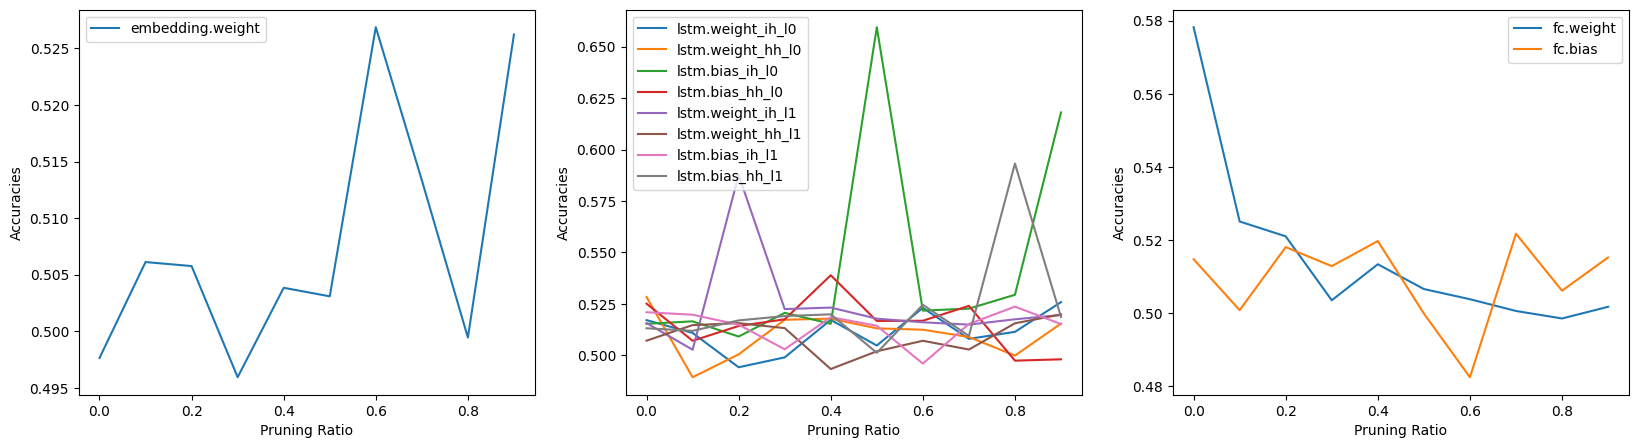

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

x_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

i = 0
for module in set([key.split(".")[0] for key in accuracies.keys()]):

    for param in [key for key in accuracies.keys() if key.startswith(module)]:
        axs[i].plot(x_values, accuracies[param], label=param)

    axs[i].set_xlabel("Pruning Ratio")
    axs[i].set_ylabel("Accuracies")
    axs[i].legend()
    
    i += 1

plt.show()

## 5. Training and Testing - Pruned Model (Unstructured)

In [ ]:
# Function that tells us how long segments take
def segment_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def segment_time2(start_time, end_time):
  return end_time - start_time

In [ ]:
profile_training = False
profile_testing = False

def run_model(profile_training, profile_testing):

    global train_prof
    global valid_prof
    global test_prof
    global secs

    start_time = time.perf_counter()

    # Training
    if profile_training:
        handler = torch.profiler.tensorboard_trace_handler('Profiling_results/v2_train_results')
        with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True, profile_memory=True, on_trace_ready=handler) as train_prof:
            run_train_model()
    else:
        run_train_model()

    # Testing
    if profile_testing:
        handler = torch.profiler.tensorboard_trace_handler('Profiling_results/v2_test_results')
        with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True, profile_memory=True, on_trace_ready=handler) as test_prof:
            run_test_model()
    else:
        run_test_model()

    end_time = time.perf_counter()
    secs = segment_time2(start_time, end_time)


def run_train_model():

    global train_secs
    global valid_secs
    global history
    global model
    global optim
    global criterion
    global epochs
    global device
    global trainloader
    global valloader

    # train loop
    model = model.to(device)
    epochloop = tqdm(range(epochs), position=0, desc='Training', leave=True)

    # early stop trigger
    es_trigger = 0
    val_loss_min = torch.inf

    for e in epochloop:

        #################
        # training mode #
        #################

        train_start_time = time.perf_counter()

        model.train()

        train_loss = 0
        train_acc = 0

        for id, (feature, target) in enumerate(trainloader):
            # add epoch meta info
            epochloop.set_postfix_str(f'Training batch {id}/{len(trainloader)}')

            # move to device
            feature, target = feature.to(device), target.to(device)

            # reset optimizer
            optim.zero_grad()

            # forward pass
            out = model(feature)

            # acc
            predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
            equals = predicted == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            train_acc += acc.item()

            # loss
            loss = criterion(out.squeeze(), target.float())
            train_loss += loss.item()
            loss.backward()

            # clip grad
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            # update optimizer
            optim.step()

            # free some memory
            del feature, target, predicted

            history['train_loss'].append(train_loss / len(trainloader))
            history['train_acc'].append(train_acc / len(trainloader))

        train_end_time = time.perf_counter()
        train_secs += segment_time2(train_start_time, train_end_time)

        valid_start_time = time.perf_counter()

        ####################
        # validation mode  #
        ####################

        model.eval()

        val_loss = 0
        val_acc = 0

        with torch.no_grad():
            for id, (feature, target) in enumerate(valloader):
                # add epoch meta info
                epochloop.set_postfix_str(f'Validation batch {id}/{len(valloader)}')
                  
                # move to device
                feature, target = feature.to(device), target.to(device)

                # forward pass
                out = model(feature)

                # acc
                predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
                equals = predicted == target
                acc = torch.mean(equals.type(torch.FloatTensor))
                val_acc += acc.item()

                # loss
                loss = criterion(out.squeeze(), target.float())
                val_loss += loss.item()

                # free some memory
                del feature, target, predicted

            history['val_loss'].append(val_loss / len(valloader))
            history['val_acc'].append(val_acc / len(valloader))

        # reset model mode
        model.train()

        # add epoch meta info
        epochloop.set_postfix_str(f'Val Loss: {val_loss / len(valloader):.3f} | Val Acc: {val_acc / len(valloader):.3f}')

        # print epoch
        if (e+1) % print_every == 0:
              epochloop.write(f'Epoch {e+1}/{epochs} | Train Loss: {train_loss / len(trainloader):.3f} Train Acc: {train_acc / len(trainloader):.3f} | Val Loss: {val_loss / len(valloader):.3f} Val Acc: {val_acc / len(valloader):.3f}')
              epochloop.update()

        # save model if validation loss decrease
        if val_loss / len(valloader) <= val_loss_min:
              torch.save(model.state_dict(), 'Checkpoints/v2_sentiment_lstm.pt')
              val_loss_min = val_loss / len(valloader)
              es_trigger = 0
        else:
              epochloop.write(f'[WARNING] Validation loss did not improved ({val_loss_min:.3f} --> {val_loss / len(valloader):.3f})')
              es_trigger += 1

        # force early stop
        if es_trigger >= es_limit:
            epochloop.write(f'Early stopped at Epoch-{e+1}')
            # update epochs history
            history['epochs'] = e+1
            #break

        valid_end_time = time.perf_counter()
        valid_secs += segment_time2(valid_start_time, valid_end_time)

def run_test_model():

    global test_secs
    global history
    global model
    global optim
    global criterion
    global epochs
    global device
    global testloader

    test_start_time = time.perf_counter()

    # test loop
    #################
    #   test mode   #
    #################

    #with record_function("test_eval_func"):
    model.eval()

    # metrics
    test_loss = 0
    test_acc = 0

    all_target = []
    all_predicted = []

    testloop = tqdm(testloader, leave=True, desc='Inference')
    with torch.no_grad():
        for feature, target in testloop:

            #with record_function("test_move_to_device"):
            feature, target = feature.to(device), target.to(device)

            #with record_function("test_forward_pass"):
            out = model(feature)
            
            with record_function("test_accuracy"):
                predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
                equals = predicted == target
                acc = torch.mean(equals.type(torch.FloatTensor))
                test_acc += acc.item()

            with record_function("test_loss"):
                loss = criterion(out.squeeze(), target.float())
                test_loss += loss.item()

            all_target.extend(target.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

        print(f'Accuracy: {test_acc/len(testloader):.4f}, Loss: {test_loss/len(testloader):.4f}')

    test_end_time = time.perf_counter()
    test_secs = segment_time2(test_start_time, test_end_time)

In [ ]:
# Get all learnable parameters
model = SentimentModel(vocab_size, output_size, hidden_size, embedding_size, n_layers, dropout)
model_modules_and_params = model.state_dict().keys()

# pruning
for key in model_modules_and_params: 
    module = getattr(model, key.split('.')[0])
    param = key.split('.')[1]
    prune.random_unstructured(module, name=param, amount=0.9)
    module._forward_pre_hooks
    prune.remove(module, param)

# training config
lr = 0.001
criterion = nn.BCELoss()  # we use BCELoss cz we have binary classification problem
optim = Adam(model.parameters(), lr=lr)
grad_clip = 5
epochs = 1
print_every = 1
history = {
'train_loss': [],
'train_acc': [],
'val_loss': [],
'val_acc': [],
'epochs': epochs
}
es_limit = 5
train_prof = None
valid_prof = None
test_prof = None
train_secs = 0
valid_secs = 0
test_secs = 0
secs = 0

print(model)
print(f'The model has {count_parameters(model):,} trainable parameters')
print(f'The model has {count_nonzero_parameters(model):,} non-zero trainable parameters')
get_model_size(model)

SentimentModel(
  (embedding): Embedding(121301, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
The model has 34,731,777 trainable parameters
The model has 3,473,180 non-zero trainable parameters
Model size: 132.49 MB


In [ ]:
run_model(profile_training, profile_testing)

Training: 100%|██████████| 1/1 [00:15<00:00, 15.52s/it, Val Loss: 0.693 | Val Acc: 0.500]

Epoch 1/1 | Train Loss: 0.694 Train Acc: 0.509 | Val Loss: 0.693 Val Acc: 0.500


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.49it/s]

Accuracy: 0.5072, Loss: 0.6931


## 6. Training and Testing - Structured Pruning Ratio Comparison

In [ ]:
# Function that tells us how long segments take
def segment_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def segment_time2(start_time, end_time):
  return end_time - start_time

def apply_pruning_mask():
    global model_modules_and_params_hierarchy
    for module_name, params in model_modules_and_params_hierarchy.items(): 
        module = getattr(model, module_name)
        for param in params:
            prune.remove(module, param)

def apply_pruning_mask_on(module,params):
    for param in params:
        prune.remove(module, param)

In [ ]:
profile_training = False
profile_testing = False

def run_model_on(profile_training, profile_testing,module,params):

    global train_prof
    global valid_prof
    global test_prof
    global secs

    start_time = time.perf_counter()

    # Training
    if profile_training:
        handler = torch.profiler.tensorboard_trace_handler('Profiling_results/v2_train_results')
        with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True, profile_memory=True, on_trace_ready=handler) as train_prof:
            run_train_model()
    else:
        run_train_model()

    # pruning
    apply_pruning_mask_on(module,params)

    # Testing
    if profile_testing:
        handler = torch.profiler.tensorboard_trace_handler('Profiling_results/v2_test_results')
        with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True, profile_memory=True, on_trace_ready=handler) as test_prof:
            test_acc = run_test_model()
    else:
        test_acc = run_test_model()

    end_time = time.perf_counter()
    secs = segment_time2(start_time, end_time)

    print('Time:')
    print('===============')
    print(f'Overall Time: {secs}s')
    print(f'Total train Time: {train_secs}s')
    print(f'Total validation Time: {valid_secs}s')
    print(f'Total test Time: {test_secs}s')
    print(f'Train Time per epoch: {train_secs/epochs}s')
    print(f'Validation per epoch: {valid_secs/epochs}s')

    return test_acc

def run_train_model():

    global train_secs
    global valid_secs
    global history
    global model
    global optim
    global criterion
    global epochs
    global device
    global trainloader
    global valloader

    # train loop
    model = model.to(device)
    epochloop = tqdm(range(epochs), position=0, desc='Training', leave=True)

    # early stop trigger
    es_trigger = 0
    val_loss_min = torch.inf

    for e in epochloop:

        #################
        # training mode #
        #################

        train_start_time = time.perf_counter()

        model.train()

        train_loss = 0
        train_acc = 0

        for id, (feature, target) in enumerate(trainloader):
            # add epoch meta info
            epochloop.set_postfix_str(f'Training batch {id}/{len(trainloader)}')

            # move to device
            feature, target = feature.to(device), target.to(device)

            # reset optimizer
            optim.zero_grad()

            # forward pass
            out = model(feature)

            # acc
            predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
            equals = predicted == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            train_acc += acc.item()

            # loss
            loss = criterion(out.squeeze(), target.float())
            train_loss += loss.item()
            loss.backward()

            # clip grad
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            # update optimizer
            optim.step()

            # free some memory
            del feature, target, predicted

            history['train_loss'].append(train_loss / len(trainloader))
            history['train_acc'].append(train_acc / len(trainloader))

        train_end_time = time.perf_counter()
        train_secs += segment_time2(train_start_time, train_end_time)

        valid_start_time = time.perf_counter()

        ####################
        # validation mode  #
        ####################

        model.eval()

        val_loss = 0
        val_acc = 0

        with torch.no_grad():
            for id, (feature, target) in enumerate(valloader):
                # add epoch meta info
                epochloop.set_postfix_str(f'Validation batch {id}/{len(valloader)}')
                  
                # move to device
                feature, target = feature.to(device), target.to(device)

                # forward pass
                out = model(feature)

                # acc
                predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
                equals = predicted == target
                acc = torch.mean(equals.type(torch.FloatTensor))
                val_acc += acc.item()

                # loss
                loss = criterion(out.squeeze(), target.float())
                val_loss += loss.item()

                # free some memory
                del feature, target, predicted

            history['val_loss'].append(val_loss / len(valloader))
            history['val_acc'].append(val_acc / len(valloader))

        # reset model mode
        model.train()

        # add epoch meta info
        epochloop.set_postfix_str(f'Val Loss: {val_loss / len(valloader):.3f} | Val Acc: {val_acc / len(valloader):.3f}')

        # print epoch
        if (e+1) % print_every == 0:
              epochloop.write(f'Epoch {e+1}/{epochs} | Train Loss: {train_loss / len(trainloader):.3f} Train Acc: {train_acc / len(trainloader):.3f} | Val Loss: {val_loss / len(valloader):.3f} Val Acc: {val_acc / len(valloader):.3f}')
              epochloop.update()

        # save model if validation loss decrease
        if val_loss / len(valloader) <= val_loss_min:
              torch.save(model.state_dict(), 'Checkpoints/v2_sentiment_lstm.pt')
              val_loss_min = val_loss / len(valloader)
              es_trigger = 0
        else:
              epochloop.write(f'[WARNING] Validation loss did not improved ({val_loss_min:.3f} --> {val_loss / len(valloader):.3f})')
              es_trigger += 1

        # force early stop
        if es_trigger >= es_limit:
            epochloop.write(f'Early stopped at Epoch-{e+1}')
            # update epochs history
            history['epochs'] = e+1
            #break

        valid_end_time = time.perf_counter()
        valid_secs += segment_time2(valid_start_time, valid_end_time)

def run_test_model():

    global test_secs
    global history
    global model
    global optim
    global criterion
    global epochs
    global device
    global testloader

    test_start_time = time.perf_counter()

    # test loop
    #################
    #   test mode   #
    #################

    #with record_function("test_eval_func"):
    model.eval()

    # metrics
    test_loss = 0
    test_acc = 0

    all_target = []
    all_predicted = []

    testloop = tqdm(testloader, leave=True, desc='Inference')
    with torch.no_grad():
        for feature, target in testloop:

            #with record_function("test_move_to_device"):
            feature, target = feature.to(device), target.to(device)

            #with record_function("test_forward_pass"):
            out = model(feature)
            
            with record_function("test_accuracy"):
                predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
                equals = predicted == target
                acc = torch.mean(equals.type(torch.FloatTensor))
                test_acc += acc.item()

            with record_function("test_loss"):
                loss = criterion(out.squeeze(), target.float())
                test_loss += loss.item()

            all_target.extend(target.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

        print(f'Accuracy: {test_acc/len(testloader):.4f}, Loss: {test_loss/len(testloader):.4f}')

    test_end_time = time.perf_counter()
    test_secs = segment_time2(test_start_time, test_end_time)

    return test_acc/len(testloader)

In [ ]:
# Get all learnable parameters
ref_model = SentimentModel(vocab_size, output_size, hidden_size, embedding_size, n_layers, dropout)
model_modules_and_params = ref_model.state_dict().keys()

# Build a hierarchy: 1st level = module, 2nd level = param
model_modules_and_params_hierarchy = dict()
for key in model_modules_and_params: 
    module_name = key.split('.')[0]
    param_name = key.split('.')[1]
    if not 'bias' in param_name:
        if module_name in model_modules_and_params_hierarchy:
            model_modules_and_params_hierarchy[module_name].append(param_name)
        else:
            model_modules_and_params_hierarchy[module_name] = [param_name]

# For each possible layer, monitor the accuracy for different pruning ratios
pruning_ratios = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
accuracies = {}
for module_name, params in model_modules_and_params_hierarchy.items(): 

    accuracies[module_name] = []
    print("\n\nmodule = "+module_name)

    for pruning_ratio in pruning_ratios:
        print("\n\tpruning_ratio = "+str(pruning_ratio))

        # initialize model
        model = SentimentModel(vocab_size, output_size, hidden_size, embedding_size, n_layers, dropout)

        print("Before pruning")
        print(f'The model has {count_parameters(model):,} trainable parameters')
        print(f'The model has {count_nonzero_parameters(model):,} non-zero trainable parameters')
        get_model_size(model)

        # pruning
        module = getattr(model, module_name)
        for param in params:
            prune.ln_structured(module=module, name=param, amount=0.9, n=2, dim=1)
            module._forward_pre_hooks

        print("After pruning, and before applying definitive mask")
        print(f'The model has {count_parameters(model):,} trainable parameters')
        print(f'The model has {count_nonzero_parameters(model):,} non-zero trainable parameters')
        get_model_size(model)

        # training config
        lr = 0.001
        criterion = nn.BCELoss()  # we use BCELoss cz we have binary classification problem
        optim = Adam(model.parameters(), lr=lr)
        grad_clip = 5
        epochs = 1
        print_every = 1
        history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'epochs': epochs
        }
        es_limit = 5
        train_prof = None
        valid_prof = None
        test_prof = None
        train_secs = 0
        valid_secs = 0
        test_secs = 0
        secs = 0
        
        # run model
        test_accuracy = run_model_on(profile_training, profile_testing, module, params)
        
        print("After applying definitive mask, and after train/test")
        print(f'The model has {count_parameters(model):,} trainable parameters')
        print(f'The model has {count_nonzero_parameters(model):,} non-zero trainable parameters')
        get_model_size(model)

        # monitor accuracy
        print("\t\tTest accuracy = "+str(round(test_accuracy,4)))
        accuracies[module_name].append(test_accuracy)



module = embedding

	pruning_ratio = 0
Before pruning
The model has 34,731,777 trainable parameters
The model has 34,731,774 non-zero trainable parameters
Model size: 132.49 MB
After pruning, and before applying definitive mask
The model has 34,731,777 trainable parameters
The model has 34,731,774 non-zero trainable parameters
Model size: 250.95 MB


Training: 100%|██████████| 1/1 [00:14<00:00, 14.43s/it, Val Loss: 0.693 | Val Acc: 0.494]

Epoch 1/1 | Train Loss: 0.694 Train Acc: 0.498 | Val Loss: 0.693 Val Acc: 0.494


Inference: 100%|██████████| 30/30 [00:00<00:00, 32.29it/s]


Accuracy: 0.5120, Loss: 0.6930
Time:
Overall Time: 16.303798287000063s
Total train Time: 13.381194124000103s
Total validation Time: 1.9049667029999s
Total test Time: 0.9345987140000034s
Train Time per epoch: 13.381194124000103s
Validation per epoch: 1.9049667029999s
After applying definitive mask, and after train/test
The model has 34,731,777 trainable parameters
The model has 6,832,546 non-zero trainable parameters
Model size: 132.49 MB
		Test accuracy = 0.512

	pruning_ratio = 0.1
Before pruning
The model has 34,731,777 trainable parameters
The model has 34,731,776 non-zero trainable parameters
Model size: 132.49 MB
After pruning, and before applying definitive mask
The model has 34,731,777 trainable parameters
The model has 34,731,776 non-zero trainable parameters
Model size: 250.95 MB


Training: 100%|██████████| 1/1 [00:14<00:00, 14.49s/it, Val Loss: 0.695 | Val Acc: 0.498]

Epoch 1/1 | Train Loss: 0.694 Train Acc: 0.504 | Val Loss: 0.695 Val Acc: 0.498


Inference: 100%|██████████| 30/30 [00:00<00:00, 32.35it/s]


Accuracy: 0.5030, Loss: 0.6939
Time:
Overall Time: 16.21722064300002s
Total train Time: 13.527475870000217s
Total validation Time: 1.67651280400014s
Total test Time: 0.9337229349998779s
Train Time per epoch: 13.527475870000217s
Validation per epoch: 1.67651280400014s
After applying definitive mask, and after train/test
The model has 34,731,777 trainable parameters
The model has 6,832,547 non-zero trainable parameters
Model size: 132.49 MB
		Test accuracy = 0.503

	pruning_ratio = 0.2
Before pruning
The model has 34,731,777 trainable parameters
The model has 34,731,774 non-zero trainable parameters
Model size: 132.49 MB
After pruning, and before applying definitive mask
The model has 34,731,777 trainable parameters
The model has 34,731,774 non-zero trainable parameters
Model size: 250.95 MB


Training: 100%|██████████| 1/1 [00:14<00:00, 14.55s/it, Val Loss: 0.694 | Val Acc: 0.497]

Epoch 1/1 | Train Loss: 0.694 Train Acc: 0.505 | Val Loss: 0.694 Val Acc: 0.497


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.32it/s]


Accuracy: 0.5012, Loss: 0.6937
Time:
Overall Time: 16.51864675600018s
Total train Time: 13.57998262000001s
Total validation Time: 1.894603637000273s
Total test Time: 0.9698292620000757s
Train Time per epoch: 13.57998262000001s
Validation per epoch: 1.894603637000273s
After applying definitive mask, and after train/test
The model has 34,731,777 trainable parameters
The model has 6,832,547 non-zero trainable parameters
Model size: 132.49 MB
		Test accuracy = 0.5012

	pruning_ratio = 0.3
Before pruning
The model has 34,731,777 trainable parameters
The model has 34,731,777 non-zero trainable parameters
Model size: 132.49 MB
After pruning, and before applying definitive mask
The model has 34,731,777 trainable parameters
The model has 34,731,777 non-zero trainable parameters
Model size: 250.95 MB


Training: 100%|██████████| 1/1 [00:14<00:00, 14.55s/it, Val Loss: 0.694 | Val Acc: 0.496]

Epoch 1/1 | Train Loss: 0.694 Train Acc: 0.499 | Val Loss: 0.694 Val Acc: 0.496


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.22it/s]


Accuracy: 0.5075, Loss: 0.6930
Time:
Overall Time: 16.41016582600014s
Total train Time: 13.536264065999603s
Total validation Time: 1.8325790469998537s
Total test Time: 0.9667862599999353s
Train Time per epoch: 13.536264065999603s
Validation per epoch: 1.8325790469998537s
After applying definitive mask, and after train/test
The model has 34,731,777 trainable parameters
The model has 6,832,547 non-zero trainable parameters
Model size: 132.49 MB
		Test accuracy = 0.5075

	pruning_ratio = 0.4
Before pruning
The model has 34,731,777 trainable parameters
The model has 34,731,776 non-zero trainable parameters
Model size: 132.49 MB
After pruning, and before applying definitive mask
The model has 34,731,777 trainable parameters
The model has 34,731,776 non-zero trainable parameters
Model size: 250.95 MB


Training: 100%|██████████| 1/1 [00:14<00:00, 14.58s/it, Val Loss: 0.693 | Val Acc: 0.503]

Epoch 1/1 | Train Loss: 0.694 Train Acc: 0.503 | Val Loss: 0.693 Val Acc: 0.503


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.62it/s]


Accuracy: 0.5141, Loss: 0.6930
Time:
Overall Time: 16.337276958000075s
Total train Time: 13.598937915999613s
Total validation Time: 1.7092944610003542s
Total test Time: 0.9543774660000963s
Train Time per epoch: 13.598937915999613s
Validation per epoch: 1.7092944610003542s
After applying definitive mask, and after train/test
The model has 34,731,777 trainable parameters
The model has 6,832,547 non-zero trainable parameters
Model size: 132.49 MB
		Test accuracy = 0.5141

	pruning_ratio = 0.5
Before pruning
The model has 34,731,777 trainable parameters
The model has 34,731,774 non-zero trainable parameters
Model size: 132.49 MB
After pruning, and before applying definitive mask
The model has 34,731,777 trainable parameters
The model has 34,731,774 non-zero trainable parameters
Model size: 250.95 MB


Training: 100%|██████████| 1/1 [00:14<00:00, 14.82s/it, Val Loss: 0.693 | Val Acc: 0.496]

Epoch 1/1 | Train Loss: 0.694 Train Acc: 0.501 | Val Loss: 0.693 Val Acc: 0.496


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.77it/s]


Accuracy: 0.5044, Loss: 0.6931
Time:
Overall Time: 16.72647805900033s
Total train Time: 13.772690509999848s
Total validation Time: 1.927733956999873s
Total test Time: 0.9502823660000104s
Train Time per epoch: 13.772690509999848s
Validation per epoch: 1.927733956999873s
After applying definitive mask, and after train/test
The model has 34,731,777 trainable parameters
The model has 6,832,545 non-zero trainable parameters
Model size: 132.49 MB
		Test accuracy = 0.5044

	pruning_ratio = 0.6
Before pruning
The model has 34,731,777 trainable parameters
The model has 34,731,773 non-zero trainable parameters
Model size: 132.49 MB
After pruning, and before applying definitive mask
The model has 34,731,777 trainable parameters
The model has 34,731,773 non-zero trainable parameters
Model size: 250.95 MB


Training: 100%|██████████| 1/1 [00:14<00:00, 14.77s/it, Val Loss: 0.693 | Val Acc: 0.505]

Epoch 1/1 | Train Loss: 0.694 Train Acc: 0.503 | Val Loss: 0.693 Val Acc: 0.505


Inference: 100%|██████████| 30/30 [00:01<00:00, 27.99it/s]


Accuracy: 0.4948, Loss: 0.6930
Time:
Overall Time: 16.78152335599998s
Total train Time: 13.758029994000026s
Total validation Time: 1.8671527890001016s
Total test Time: 1.0808704819992272s
Train Time per epoch: 13.758029994000026s
Validation per epoch: 1.8671527890001016s
After applying definitive mask, and after train/test
The model has 34,731,777 trainable parameters
The model has 6,832,547 non-zero trainable parameters
Model size: 132.49 MB
		Test accuracy = 0.4948

	pruning_ratio = 0.7
Before pruning
The model has 34,731,777 trainable parameters
The model has 34,731,772 non-zero trainable parameters
Model size: 132.49 MB
After pruning, and before applying definitive mask
The model has 34,731,777 trainable parameters
The model has 34,731,772 non-zero trainable parameters
Model size: 250.95 MB


Training: 100%|██████████| 1/1 [00:14<00:00, 14.74s/it, Val Loss: 0.694 | Val Acc: 0.495]

Epoch 1/1 | Train Loss: 0.694 Train Acc: 0.499 | Val Loss: 0.694 Val Acc: 0.495


Inference: 100%|██████████| 30/30 [00:00<00:00, 30.73it/s]


Accuracy: 0.5044, Loss: 0.6931
Time:
Overall Time: 16.65556272000049s
Total train Time: 13.764368724000633s
Total validation Time: 1.826798484000392s
Total test Time: 0.9821889400000146s
Train Time per epoch: 13.764368724000633s
Validation per epoch: 1.826798484000392s
After applying definitive mask, and after train/test
The model has 34,731,777 trainable parameters
The model has 6,832,547 non-zero trainable parameters
Model size: 132.49 MB
		Test accuracy = 0.5044

	pruning_ratio = 0.8
Before pruning
The model has 34,731,777 trainable parameters
The model has 34,731,777 non-zero trainable parameters
Model size: 132.49 MB
After pruning, and before applying definitive mask
The model has 34,731,777 trainable parameters
The model has 34,731,777 non-zero trainable parameters
Model size: 250.95 MB


Training: 100%|██████████| 1/1 [00:14<00:00, 14.52s/it, Val Loss: 0.694 | Val Acc: 0.504]

Epoch 1/1 | Train Loss: 0.694 Train Acc: 0.500 | Val Loss: 0.694 Val Acc: 0.504


Inference: 100%|██████████| 30/30 [00:00<00:00, 32.49it/s]


Accuracy: 0.5149, Loss: 0.6931
Time:
Overall Time: 16.246355054999185s
Total train Time: 13.561903144999633s
Total validation Time: 1.6711852629996429s
Total test Time: 0.9290636420000737s
Train Time per epoch: 13.561903144999633s
Validation per epoch: 1.6711852629996429s
After applying definitive mask, and after train/test
The model has 34,731,777 trainable parameters
The model has 6,832,547 non-zero trainable parameters
Model size: 132.49 MB
		Test accuracy = 0.5149

	pruning_ratio = 0.9
Before pruning
The model has 34,731,777 trainable parameters
The model has 34,731,773 non-zero trainable parameters
Model size: 132.49 MB
After pruning, and before applying definitive mask
The model has 34,731,777 trainable parameters
The model has 34,731,773 non-zero trainable parameters
Model size: 250.95 MB


Training: 100%|██████████| 1/1 [00:14<00:00, 14.40s/it, Val Loss: 0.694 | Val Acc: 0.496]

Epoch 1/1 | Train Loss: 0.694 Train Acc: 0.498 | Val Loss: 0.694 Val Acc: 0.496


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.88it/s]


Accuracy: 0.5071, Loss: 0.6931
Time:
Overall Time: 16.186096454000108s
Total train Time: 13.406403547000082s
Total validation Time: 1.755532616999517s
Total test Time: 0.9448622019999675s
Train Time per epoch: 13.406403547000082s
Validation per epoch: 1.755532616999517s
After applying definitive mask, and after train/test
The model has 34,731,777 trainable parameters
The model has 6,832,546 non-zero trainable parameters
Model size: 132.49 MB
		Test accuracy = 0.5071


module = lstm

	pruning_ratio = 0
Before pruning
The model has 34,731,777 trainable parameters
The model has 34,731,775 non-zero trainable parameters
Model size: 132.49 MB
After pruning, and before applying definitive mask
The model has 34,731,777 trainable parameters
The model has 34,731,775 non-zero trainable parameters
Model size: 146.50 MB


Training: 100%|██████████| 1/1 [00:14<00:00, 14.35s/it, Val Loss: 0.693 | Val Acc: 0.502]

Epoch 1/1 | Train Loss: 0.693 Train Acc: 0.502 | Val Loss: 0.693 Val Acc: 0.502


Inference: 100%|██████████| 30/30 [00:01<00:00, 28.74it/s]


Accuracy: 0.4988, Loss: 0.6933
Time:
Overall Time: 16.090295932000117s
Total train Time: 13.37123568700008s
Total validation Time: 1.622048174000156s
Total test Time: 1.0486262250005893s
Train Time per epoch: 13.37123568700008s
Validation per epoch: 1.622048174000156s
After applying definitive mask, and after train/test
The model has 34,731,777 trainable parameters
The model has 31,428,351 non-zero trainable parameters
Model size: 132.49 MB
		Test accuracy = 0.4988

	pruning_ratio = 0.1
Before pruning
The model has 34,731,777 trainable parameters
The model has 34,731,774 non-zero trainable parameters
Model size: 132.49 MB
After pruning, and before applying definitive mask
The model has 34,731,777 trainable parameters
The model has 34,731,774 non-zero trainable parameters
Model size: 146.50 MB


Training: 100%|██████████| 1/1 [00:14<00:00, 14.32s/it, Val Loss: 0.693 | Val Acc: 0.499]

Epoch 1/1 | Train Loss: 0.693 Train Acc: 0.499 | Val Loss: 0.693 Val Acc: 0.499


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.89it/s]


Accuracy: 0.5077, Loss: 0.6930
Time:
Overall Time: 15.801282265999362s
Total train Time: 13.338186619000226s
Total validation Time: 1.4661537000001772s
Total test Time: 0.9474000749996776s
Train Time per epoch: 13.338186619000226s
Validation per epoch: 1.4661537000001772s
After applying definitive mask, and after train/test
The model has 34,731,777 trainable parameters
The model has 31,428,350 non-zero trainable parameters
Model size: 132.49 MB
		Test accuracy = 0.5077

	pruning_ratio = 0.2
Before pruning
The model has 34,731,777 trainable parameters
The model has 34,731,774 non-zero trainable parameters
Model size: 132.49 MB
After pruning, and before applying definitive mask
The model has 34,731,777 trainable parameters
The model has 34,731,774 non-zero trainable parameters
Model size: 146.50 MB


Training: 100%|██████████| 1/1 [00:14<00:00, 14.28s/it, Val Loss: 0.693 | Val Acc: 0.499]

Epoch 1/1 | Train Loss: 0.693 Train Acc: 0.501 | Val Loss: 0.693 Val Acc: 0.499


Inference: 100%|██████████| 30/30 [00:00<00:00, 32.61it/s]


Accuracy: 0.5012, Loss: 0.6933
Time:
Overall Time: 15.703458062999744s
Total train Time: 13.31343198400009s
Total validation Time: 1.4130194290000873s
Total test Time: 0.9264018680005393s
Train Time per epoch: 13.31343198400009s
Validation per epoch: 1.4130194290000873s
After applying definitive mask, and after train/test
The model has 34,731,777 trainable parameters
The model has 31,428,351 non-zero trainable parameters
Model size: 132.49 MB
		Test accuracy = 0.5012

	pruning_ratio = 0.3
Before pruning
The model has 34,731,777 trainable parameters
The model has 34,731,775 non-zero trainable parameters
Model size: 132.49 MB
After pruning, and before applying definitive mask
The model has 34,731,777 trainable parameters
The model has 34,731,775 non-zero trainable parameters
Model size: 146.50 MB


Training: 100%|██████████| 1/1 [00:14<00:00, 14.39s/it, Val Loss: 0.694 | Val Acc: 0.493]

Epoch 1/1 | Train Loss: 0.693 Train Acc: 0.507 | Val Loss: 0.694 Val Acc: 0.493


Inference: 100%|██████████| 30/30 [00:00<00:00, 32.76it/s]


Accuracy: 0.5030, Loss: 0.6934
Time:
Overall Time: 15.811782845999915s
Total train Time: 13.421803698000076s
Total validation Time: 1.4153876079999463s
Total test Time: 0.922196812999573s
Train Time per epoch: 13.421803698000076s
Validation per epoch: 1.4153876079999463s
After applying definitive mask, and after train/test
The model has 34,731,777 trainable parameters
The model has 31,428,351 non-zero trainable parameters
Model size: 132.49 MB
		Test accuracy = 0.503

	pruning_ratio = 0.4
Before pruning
The model has 34,731,777 trainable parameters
The model has 34,731,774 non-zero trainable parameters
Model size: 132.49 MB
After pruning, and before applying definitive mask
The model has 34,731,777 trainable parameters
The model has 34,731,774 non-zero trainable parameters
Model size: 146.50 MB


Training: 100%|██████████| 1/1 [00:14<00:00, 14.35s/it, Val Loss: 0.693 | Val Acc: 0.499]

Epoch 1/1 | Train Loss: 0.693 Train Acc: 0.509 | Val Loss: 0.693 Val Acc: 0.499


Inference: 100%|██████████| 30/30 [00:00<00:00, 32.56it/s]


Accuracy: 0.5142, Loss: 0.6930
Time:
Overall Time: 15.827540298999338s
Total train Time: 13.369648846000018s
Total validation Time: 1.4756107860002885s
Total test Time: 0.9275487280001471s
Train Time per epoch: 13.369648846000018s
Validation per epoch: 1.4756107860002885s
After applying definitive mask, and after train/test
The model has 34,731,777 trainable parameters
The model has 31,428,351 non-zero trainable parameters
Model size: 132.49 MB
		Test accuracy = 0.5142

	pruning_ratio = 0.5
Before pruning
The model has 34,731,777 trainable parameters
The model has 34,731,773 non-zero trainable parameters
Model size: 132.49 MB
After pruning, and before applying definitive mask
The model has 34,731,777 trainable parameters
The model has 34,731,773 non-zero trainable parameters
Model size: 146.50 MB


Training: 100%|██████████| 1/1 [00:14<00:00, 14.35s/it, Val Loss: 0.694 | Val Acc: 0.498]

Epoch 1/1 | Train Loss: 0.693 Train Acc: 0.500 | Val Loss: 0.694 Val Acc: 0.498


Inference: 100%|██████████| 30/30 [00:00<00:00, 32.10it/s]


Accuracy: 0.5030, Loss: 0.6936
Time:
Overall Time: 15.806912592000117s
Total train Time: 13.363693367999986s
Total validation Time: 1.452523829000711s
Total test Time: 0.9411339070002214s
Train Time per epoch: 13.363693367999986s
Validation per epoch: 1.452523829000711s
After applying definitive mask, and after train/test
The model has 34,731,777 trainable parameters
The model has 31,428,349 non-zero trainable parameters
Model size: 132.49 MB
		Test accuracy = 0.503

	pruning_ratio = 0.6
Before pruning
The model has 34,731,777 trainable parameters
The model has 34,731,775 non-zero trainable parameters
Model size: 132.49 MB
After pruning, and before applying definitive mask
The model has 34,731,777 trainable parameters
The model has 34,731,775 non-zero trainable parameters
Model size: 146.50 MB


Training: 100%|██████████| 1/1 [00:14<00:00, 14.31s/it, Val Loss: 0.693 | Val Acc: 0.495]

Epoch 1/1 | Train Loss: 0.693 Train Acc: 0.501 | Val Loss: 0.693 Val Acc: 0.495


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.98it/s]


Accuracy: 0.5082, Loss: 0.6931
Time:
Overall Time: 15.771122222000486s
Total train Time: 13.332076470000175s
Total validation Time: 1.4381817250005042s
Total test Time: 0.9443432970001595s
Train Time per epoch: 13.332076470000175s
Validation per epoch: 1.4381817250005042s
After applying definitive mask, and after train/test
The model has 34,731,777 trainable parameters
The model has 31,428,351 non-zero trainable parameters
Model size: 132.49 MB
		Test accuracy = 0.5082

	pruning_ratio = 0.7
Before pruning
The model has 34,731,777 trainable parameters
The model has 34,731,773 non-zero trainable parameters
Model size: 132.49 MB
After pruning, and before applying definitive mask
The model has 34,731,777 trainable parameters
The model has 34,731,773 non-zero trainable parameters
Model size: 146.50 MB


Training: 100%|██████████| 1/1 [00:14<00:00, 14.34s/it, Val Loss: 0.693 | Val Acc: 0.498]

Epoch 1/1 | Train Loss: 0.693 Train Acc: 0.505 | Val Loss: 0.693 Val Acc: 0.498


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.89it/s]


Accuracy: 0.4964, Loss: 0.6936
Time:
Overall Time: 15.827978952000194s
Total train Time: 13.360840552999434s
Total validation Time: 1.46968838399971s
Total test Time: 0.9475980819997858s
Train Time per epoch: 13.360840552999434s
Validation per epoch: 1.46968838399971s
After applying definitive mask, and after train/test
The model has 34,731,777 trainable parameters
The model has 31,428,349 non-zero trainable parameters
Model size: 132.49 MB
		Test accuracy = 0.4964

	pruning_ratio = 0.8
Before pruning
The model has 34,731,777 trainable parameters
The model has 34,731,772 non-zero trainable parameters
Model size: 132.49 MB
After pruning, and before applying definitive mask
The model has 34,731,777 trainable parameters
The model has 34,731,772 non-zero trainable parameters
Model size: 146.50 MB


Training: 100%|██████████| 1/1 [00:14<00:00, 14.30s/it, Val Loss: 0.695 | Val Acc: 0.498]

Epoch 1/1 | Train Loss: 0.693 Train Acc: 0.503 | Val Loss: 0.695 Val Acc: 0.498


Inference: 100%|██████████| 30/30 [00:00<00:00, 32.44it/s]


Accuracy: 0.5055, Loss: 0.6937
Time:
Overall Time: 15.744347443000152s
Total train Time: 13.338862427000095s
Total validation Time: 1.4242718909999894s
Total test Time: 0.9305569389998709s
Train Time per epoch: 13.338862427000095s
Validation per epoch: 1.4242718909999894s
After applying definitive mask, and after train/test
The model has 34,731,777 trainable parameters
The model has 31,428,348 non-zero trainable parameters
Model size: 132.49 MB
		Test accuracy = 0.5055

	pruning_ratio = 0.9
Before pruning
The model has 34,731,777 trainable parameters
The model has 34,731,774 non-zero trainable parameters
Model size: 132.49 MB
After pruning, and before applying definitive mask
The model has 34,731,777 trainable parameters
The model has 34,731,774 non-zero trainable parameters
Model size: 146.50 MB


Training: 100%|██████████| 1/1 [00:14<00:00, 14.38s/it, Val Loss: 0.694 | Val Acc: 0.498]

Epoch 1/1 | Train Loss: 0.693 Train Acc: 0.502 | Val Loss: 0.694 Val Acc: 0.498


Inference: 100%|██████████| 30/30 [00:00<00:00, 32.64it/s]


Accuracy: 0.5012, Loss: 0.6932
Time:
Overall Time: 15.858110658999976s
Total train Time: 13.4032617390003s
Total validation Time: 1.4750895970000784s
Total test Time: 0.9271575679995294s
Train Time per epoch: 13.4032617390003s
Validation per epoch: 1.4750895970000784s
After applying definitive mask, and after train/test
The model has 34,731,777 trainable parameters
The model has 31,428,351 non-zero trainable parameters
Model size: 132.49 MB
		Test accuracy = 0.5012


module = fc

	pruning_ratio = 0
Before pruning
The model has 34,731,777 trainable parameters
The model has 34,731,774 non-zero trainable parameters
Model size: 132.49 MB
After pruning, and before applying definitive mask
The model has 34,731,777 trainable parameters
The model has 34,731,774 non-zero trainable parameters
Model size: 132.50 MB


Training: 100%|██████████| 1/1 [00:14<00:00, 14.55s/it, Val Loss: 0.692 | Val Acc: 0.504]

Epoch 1/1 | Train Loss: 0.694 Train Acc: 0.503 | Val Loss: 0.692 Val Acc: 0.504


Inference: 100%|██████████| 30/30 [00:00<00:00, 32.65it/s]


Accuracy: 0.5159, Loss: 0.6924
Time:
Overall Time: 15.926332445999833s
Total train Time: 13.594531485000516s
Total validation Time: 1.359963900999901s
Total test Time: 0.9261833390000902s
Train Time per epoch: 13.594531485000516s
Validation per epoch: 1.359963900999901s
After applying definitive mask, and after train/test
The model has 34,731,777 trainable parameters
The model has 34,731,315 non-zero trainable parameters
Model size: 132.49 MB
		Test accuracy = 0.5159

	pruning_ratio = 0.1
Before pruning
The model has 34,731,777 trainable parameters
The model has 34,731,776 non-zero trainable parameters
Model size: 132.49 MB
After pruning, and before applying definitive mask
The model has 34,731,777 trainable parameters
The model has 34,731,776 non-zero trainable parameters
Model size: 132.50 MB


Training: 100%|██████████| 1/1 [00:14<00:00, 14.62s/it, Val Loss: 0.693 | Val Acc: 0.500]

Epoch 1/1 | Train Loss: 0.694 Train Acc: 0.506 | Val Loss: 0.693 Val Acc: 0.500


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.84it/s]


Accuracy: 0.5156, Loss: 0.6933
Time:
Overall Time: 16.0117631359999s
Total train Time: 13.64349766900068s
Total validation Time: 1.3702186680002342s
Total test Time: 0.9487244450001526s
Train Time per epoch: 13.64349766900068s
Validation per epoch: 1.3702186680002342s
After applying definitive mask, and after train/test
The model has 34,731,777 trainable parameters
The model has 34,731,316 non-zero trainable parameters
Model size: 132.49 MB
		Test accuracy = 0.5156

	pruning_ratio = 0.2
Before pruning
The model has 34,731,777 trainable parameters
The model has 34,731,777 non-zero trainable parameters
Model size: 132.49 MB
After pruning, and before applying definitive mask
The model has 34,731,777 trainable parameters
The model has 34,731,777 non-zero trainable parameters
Model size: 132.50 MB


Training: 100%|██████████| 1/1 [00:14<00:00, 14.58s/it, Val Loss: 0.693 | Val Acc: 0.503]

Epoch 1/1 | Train Loss: 0.694 Train Acc: 0.501 | Val Loss: 0.693 Val Acc: 0.503


Inference: 100%|██████████| 30/30 [00:00<00:00, 32.41it/s]


Accuracy: 0.5100, Loss: 0.6930
Time:
Overall Time: 15.949148444999992s
Total train Time: 13.612701304999973s
Total validation Time: 1.3517753010000888s
Total test Time: 0.932508916000188s
Train Time per epoch: 13.612701304999973s
Validation per epoch: 1.3517753010000888s
After applying definitive mask, and after train/test
The model has 34,731,777 trainable parameters
The model has 34,731,316 non-zero trainable parameters
Model size: 132.49 MB
		Test accuracy = 0.51

	pruning_ratio = 0.3
Before pruning
The model has 34,731,777 trainable parameters
The model has 34,731,772 non-zero trainable parameters
Model size: 132.49 MB
After pruning, and before applying definitive mask
The model has 34,731,777 trainable parameters
The model has 34,731,772 non-zero trainable parameters
Model size: 132.50 MB


Training: 100%|██████████| 1/1 [00:14<00:00, 14.60s/it, Val Loss: 0.694 | Val Acc: 0.506]

Epoch 1/1 | Train Loss: 0.694 Train Acc: 0.504 | Val Loss: 0.694 Val Acc: 0.506


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.90it/s]


Accuracy: 0.5188, Loss: 0.6925
Time:
Overall Time: 15.973254241999712s
Total train Time: 13.624780596000164s
Total validation Time: 1.3541484289999062s
Total test Time: 0.9467026760003137s
Train Time per epoch: 13.624780596000164s
Validation per epoch: 1.3541484289999062s
After applying definitive mask, and after train/test
The model has 34,731,777 trainable parameters
The model has 34,731,315 non-zero trainable parameters
Model size: 132.49 MB
		Test accuracy = 0.5188

	pruning_ratio = 0.4
Before pruning
The model has 34,731,777 trainable parameters
The model has 34,731,774 non-zero trainable parameters
Model size: 132.49 MB
After pruning, and before applying definitive mask
The model has 34,731,777 trainable parameters
The model has 34,731,774 non-zero trainable parameters
Model size: 132.50 MB


Training: 100%|██████████| 1/1 [00:14<00:00, 14.61s/it, Val Loss: 0.694 | Val Acc: 0.497]

Epoch 1/1 | Train Loss: 0.694 Train Acc: 0.505 | Val Loss: 0.694 Val Acc: 0.497


Inference: 100%|██████████| 30/30 [00:00<00:00, 32.44it/s]


Accuracy: 0.5142, Loss: 0.6930
Time:
Overall Time: 16.013732926000557s
Total train Time: 13.640335165000579s
Total validation Time: 1.3902881099993465s
Total test Time: 0.9326404989997172s
Train Time per epoch: 13.640335165000579s
Validation per epoch: 1.3902881099993465s
After applying definitive mask, and after train/test
The model has 34,731,777 trainable parameters
The model has 34,731,316 non-zero trainable parameters
Model size: 132.49 MB
		Test accuracy = 0.5142

	pruning_ratio = 0.5
Before pruning
The model has 34,731,777 trainable parameters
The model has 34,731,776 non-zero trainable parameters
Model size: 132.49 MB
After pruning, and before applying definitive mask
The model has 34,731,777 trainable parameters
The model has 34,731,776 non-zero trainable parameters
Model size: 132.50 MB


Training: 100%|██████████| 1/1 [00:14<00:00, 14.50s/it, Val Loss: 0.693 | Val Acc: 0.499]

Epoch 1/1 | Train Loss: 0.694 Train Acc: 0.503 | Val Loss: 0.693 Val Acc: 0.499


Inference: 100%|██████████| 30/30 [00:00<00:00, 32.52it/s]


Accuracy: 0.5133, Loss: 0.6928
Time:
Overall Time: 15.874289757000042s
Total train Time: 13.53564924300008s
Total validation Time: 1.355706325999563s
Total test Time: 0.926777277999463s
Train Time per epoch: 13.53564924300008s
Validation per epoch: 1.355706325999563s
After applying definitive mask, and after train/test
The model has 34,731,777 trainable parameters
The model has 34,731,316 non-zero trainable parameters
Model size: 132.49 MB
		Test accuracy = 0.5133

	pruning_ratio = 0.6
Before pruning
The model has 34,731,777 trainable parameters
The model has 34,731,772 non-zero trainable parameters
Model size: 132.49 MB
After pruning, and before applying definitive mask
The model has 34,731,777 trainable parameters
The model has 34,731,772 non-zero trainable parameters
Model size: 132.50 MB


Training: 100%|██████████| 1/1 [00:14<00:00, 14.51s/it, Val Loss: 0.694 | Val Acc: 0.496]

Epoch 1/1 | Train Loss: 0.693 Train Acc: 0.513 | Val Loss: 0.694 Val Acc: 0.496


Inference: 100%|██████████| 30/30 [00:00<00:00, 32.49it/s]


Accuracy: 0.5083, Loss: 0.6931
Time:
Overall Time: 15.866687728000215s
Total train Time: 13.550734645000375s
Total validation Time: 1.3396831810005096s
Total test Time: 0.930897780000123s
Train Time per epoch: 13.550734645000375s
Validation per epoch: 1.3396831810005096s
After applying definitive mask, and after train/test
The model has 34,731,777 trainable parameters
The model has 34,731,313 non-zero trainable parameters
Model size: 132.49 MB
		Test accuracy = 0.5083

	pruning_ratio = 0.7
Before pruning
The model has 34,731,777 trainable parameters
The model has 34,731,774 non-zero trainable parameters
Model size: 132.49 MB
After pruning, and before applying definitive mask
The model has 34,731,777 trainable parameters
The model has 34,731,774 non-zero trainable parameters
Model size: 132.50 MB


Training: 100%|██████████| 1/1 [00:14<00:00, 14.58s/it, Val Loss: 0.694 | Val Acc: 0.498]

Epoch 1/1 | Train Loss: 0.694 Train Acc: 0.502 | Val Loss: 0.694 Val Acc: 0.498


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.61it/s]


Accuracy: 0.5030, Loss: 0.6936
Time:
Overall Time: 15.984250933000112s
Total train Time: 13.596861476000413s
Total validation Time: 1.3800597620002009s
Total test Time: 0.9552953940001316s
Train Time per epoch: 13.596861476000413s
Validation per epoch: 1.3800597620002009s
After applying definitive mask, and after train/test
The model has 34,731,777 trainable parameters
The model has 34,731,314 non-zero trainable parameters
Model size: 132.49 MB
		Test accuracy = 0.503

	pruning_ratio = 0.8
Before pruning
The model has 34,731,777 trainable parameters
The model has 34,731,777 non-zero trainable parameters
Model size: 132.49 MB
After pruning, and before applying definitive mask
The model has 34,731,777 trainable parameters
The model has 34,731,777 non-zero trainable parameters
Model size: 132.50 MB


Training: 100%|██████████| 1/1 [00:14<00:00, 14.66s/it, Val Loss: 0.693 | Val Acc: 0.500]

Epoch 1/1 | Train Loss: 0.694 Train Acc: 0.507 | Val Loss: 0.693 Val Acc: 0.500


Inference: 100%|██████████| 30/30 [00:00<00:00, 32.10it/s]


Accuracy: 0.4897, Loss: 0.6937
Time:
Overall Time: 16.046821832000205s
Total train Time: 13.669950117000553s
Total validation Time: 1.3868135370003074s
Total test Time: 0.9410073970002486s
Train Time per epoch: 13.669950117000553s
Validation per epoch: 1.3868135370003074s
After applying definitive mask, and after train/test
The model has 34,731,777 trainable parameters
The model has 34,731,316 non-zero trainable parameters
Model size: 132.49 MB
		Test accuracy = 0.4897

	pruning_ratio = 0.9
Before pruning
The model has 34,731,777 trainable parameters
The model has 34,731,777 non-zero trainable parameters
Model size: 132.49 MB
After pruning, and before applying definitive mask
The model has 34,731,777 trainable parameters
The model has 34,731,777 non-zero trainable parameters
Model size: 132.50 MB


Training: 100%|██████████| 1/1 [00:14<00:00, 14.57s/it, Val Loss: 0.694 | Val Acc: 0.503]

Epoch 1/1 | Train Loss: 0.695 Train Acc: 0.502 | Val Loss: 0.694 Val Acc: 0.503


Inference: 100%|██████████| 30/30 [00:00<00:00, 31.87it/s]


Accuracy: 0.4953, Loss: 0.6949
Time:
Overall Time: 15.983178747999773s
Total train Time: 13.589689051999812s
Total validation Time: 1.3956766709998192s
Total test Time: 0.9499761919996672s
Train Time per epoch: 13.589689051999812s
Validation per epoch: 1.3956766709998192s
After applying definitive mask, and after train/test
The model has 34,731,777 trainable parameters
The model has 34,731,316 non-zero trainable parameters
Model size: 132.49 MB
		Test accuracy = 0.4953


{'embedding': [0.5119517544905344, 0.5030290573835373, 0.5011787285407384, 0.5075246711572011, 0.5140625, 0.5044270833333333, 0.4947916666666667, 0.5044270833333333, 0.5148848682641983, 0.5070586621761322], 'lstm': [0.4988212724526723, 0.5077439685662587, 0.5011787285407384, 0.5030290573835373, 0.514226974050204, 0.5030290573835373, 0.5082236846288045, 0.49635416666666665, 0.5054961621761322, 0.5011787285407384], 'fc': [0.5158854166666667, 0.5156112929185231, 0.5099643637736638, 0.5188459436098735, 0.5141858557860056, 0.51328125, 0.5082922140757243, 0.5030290573835373, 0.4896518637736638, 0.4953125]}


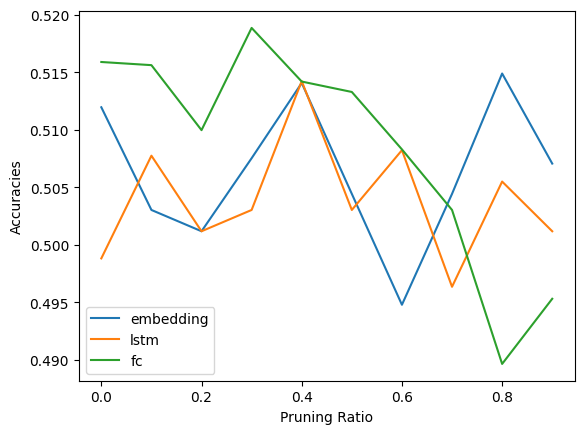

In [ ]:
print(accuracies)

for module_name in accuracies.keys():

    plt.plot(pruning_ratios, accuracies[module_name], label=module_name)
    plt.xlabel("Pruning Ratio")
    plt.ylabel("Accuracies")
    plt.legend()
    
plt.show()

## 7. Training and Testing - Pruned Model (Structured)

In [ ]:
# Function that tells us how long segments take
def segment_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def segment_time2(start_time, end_time):
  return end_time - start_time

def apply_pruning_mask():
    global model_modules_and_params
    for key in model_modules_and_params: 
        module = getattr(model, key.split('.')[0])
        param = key.split('.')[1]
        if not 'bias' in param:
          prune.remove(module, param)

In [ ]:
profile_training = False
profile_testing = True

def run_model(profile_training, profile_testing):

    global train_prof
    global valid_prof
    global test_prof
    global secs

    start_time = time.perf_counter()

    # Training
    if profile_training:
        handler = torch.profiler.tensorboard_trace_handler('Profiling_results/v2_train_results')
        with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True, profile_memory=True, on_trace_ready=handler) as train_prof:
            run_train_model()
    else:
        run_train_model()

    # pruning
    apply_pruning_mask()

    # Testing
    if profile_testing:
        handler = torch.profiler.tensorboard_trace_handler('Profiling_results/v2_test_results')
        with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True, profile_memory=True, on_trace_ready=handler) as test_prof:
            run_test_model()
    else:
        run_test_model()

    end_time = time.perf_counter()
    secs = segment_time2(start_time, end_time)


def run_train_model():

    global train_secs
    global valid_secs
    global history
    global model
    global optim
    global criterion
    global epochs
    global device
    global trainloader
    global valloader

    # train loop
    model = model.to(device)
    epochloop = tqdm(range(epochs), position=0, desc='Training', leave=True)

    # early stop trigger
    es_trigger = 0
    val_loss_min = torch.inf

    for e in epochloop:

        #################
        # training mode #
        #################

        train_start_time = time.perf_counter()

        model.train()

        train_loss = 0
        train_acc = 0

        for id, (feature, target) in enumerate(trainloader):
            # add epoch meta info
            epochloop.set_postfix_str(f'Training batch {id}/{len(trainloader)}')

            # move to device
            feature, target = feature.to(device), target.to(device)

            # reset optimizer
            optim.zero_grad()

            # forward pass
            out = model(feature)

            # acc
            predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
            equals = predicted == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            train_acc += acc.item()

            # loss
            loss = criterion(out.squeeze(), target.float())
            train_loss += loss.item()
            loss.backward()

            # clip grad
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            # update optimizer
            optim.step()

            # free some memory
            del feature, target, predicted

            history['train_loss'].append(train_loss / len(trainloader))
            history['train_acc'].append(train_acc / len(trainloader))

        train_end_time = time.perf_counter()
        train_secs += segment_time2(train_start_time, train_end_time)

        valid_start_time = time.perf_counter()

        ####################
        # validation mode  #
        ####################

        model.eval()

        val_loss = 0
        val_acc = 0

        with torch.no_grad():
            for id, (feature, target) in enumerate(valloader):
                # add epoch meta info
                epochloop.set_postfix_str(f'Validation batch {id}/{len(valloader)}')
                  
                # move to device
                feature, target = feature.to(device), target.to(device)

                # forward pass
                out = model(feature)

                # acc
                predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
                equals = predicted == target
                acc = torch.mean(equals.type(torch.FloatTensor))
                val_acc += acc.item()

                # loss
                loss = criterion(out.squeeze(), target.float())
                val_loss += loss.item()

                # free some memory
                del feature, target, predicted

            history['val_loss'].append(val_loss / len(valloader))
            history['val_acc'].append(val_acc / len(valloader))

        # reset model mode
        model.train()

        # add epoch meta info
        epochloop.set_postfix_str(f'Val Loss: {val_loss / len(valloader):.3f} | Val Acc: {val_acc / len(valloader):.3f}')

        # print epoch
        if (e+1) % print_every == 0:
              epochloop.write(f'Epoch {e+1}/{epochs} | Train Loss: {train_loss / len(trainloader):.3f} Train Acc: {train_acc / len(trainloader):.3f} | Val Loss: {val_loss / len(valloader):.3f} Val Acc: {val_acc / len(valloader):.3f}')
              epochloop.update()

        # save model if validation loss decrease
        if val_loss / len(valloader) <= val_loss_min:
              torch.save(model.state_dict(), 'Checkpoints/v2_sentiment_lstm.pt')
              val_loss_min = val_loss / len(valloader)
              es_trigger = 0
        else:
              epochloop.write(f'[WARNING] Validation loss did not improved ({val_loss_min:.3f} --> {val_loss / len(valloader):.3f})')
              es_trigger += 1

        # force early stop
        if es_trigger >= es_limit:
            epochloop.write(f'Early stopped at Epoch-{e+1}')
            # update epochs history
            history['epochs'] = e+1
            #break

        valid_end_time = time.perf_counter()
        valid_secs += segment_time2(valid_start_time, valid_end_time)

def run_test_model():

    global test_secs
    global history
    global model
    global optim
    global criterion
    global epochs
    global device
    global testloader

    test_start_time = time.perf_counter()

    # test loop
    #################
    #   test mode   #
    #################

    #with record_function("test_eval_func"):
    model.eval()

    # metrics
    test_loss = 0
    test_acc = 0

    all_target = []
    all_predicted = []

    testloop = tqdm(testloader, leave=True, desc='Inference')
    with torch.no_grad():
        for feature, target in testloop:

            #with record_function("test_move_to_device"):
            feature, target = feature.to(device), target.to(device)

            #with record_function("test_forward_pass"):
            out = model(feature)
            
            with record_function("test_accuracy"):
                predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
                equals = predicted == target
                acc = torch.mean(equals.type(torch.FloatTensor))
                test_acc += acc.item()

            with record_function("test_loss"):
                loss = criterion(out.squeeze(), target.float())
                test_loss += loss.item()

            all_target.extend(target.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

        print(f'Accuracy: {test_acc/len(testloader):.4f}, Loss: {test_loss/len(testloader):.4f}')

    test_end_time = time.perf_counter()
    test_secs = segment_time2(test_start_time, test_end_time)

In [ ]:
# Get all learnable parameters
model = SentimentModel(vocab_size, output_size, hidden_size, embedding_size, n_layers, dropout)
print("Before pruning")
print(f'The model has {count_parameters(model):,} trainable parameters')
print(f'The model has {count_nonzero_parameters(model):,} non-zero trainable parameters')
get_model_size(model)

model_modules_and_params = model.state_dict().keys()

# pruning
for key in model_modules_and_params: 
    module = getattr(model, key.split('.')[0])
    param = key.split('.')[1]
    if not 'bias' in param:
        prune.ln_structured(module=module, name=param, amount=0.9, n=2, dim=1)
        module._forward_pre_hooks

# training config
lr = 0.001
criterion = nn.BCELoss()  # we use BCELoss cz we have binary classification problem
optim = Adam(model.parameters(), lr=lr)
grad_clip = 5
epochs = 1
print_every = 1
history = {
'train_loss': [],
'train_acc': [],
'val_loss': [],
'val_acc': [],
'epochs': epochs
}
es_limit = 5
train_prof = None
valid_prof = None
test_prof = None
train_secs = 0
valid_secs = 0
test_secs = 0
secs = 0

print("After pruning, and before applying definitive mask")
print(f'The model has {count_parameters(model):,} trainable parameters')
print(f'The model has {count_nonzero_parameters(model):,} non-zero trainable parameters')
get_model_size(model)

Before pruning
The model has 34,731,777 trainable parameters
The model has 34,731,777 non-zero trainable parameters
Model size: 132.49 MB
After pruning, and before applying definitive mask
The model has 34,731,777 trainable parameters
The model has 34,731,777 non-zero trainable parameters
Model size: 264.96 MB


In [ ]:
run_model(profile_training, profile_testing)

print("After applying definitive mask, and after train/test.")
print(f'The model has {count_parameters(model):,} trainable parameters')
print(f'The model has {count_nonzero_parameters(model):,} non-zero trainable parameters')
get_model_size(model)

Training: 100%|██████████| 1/1 [00:14<00:00, 14.63s/it, Val Loss: 0.693 | Val Acc: 0.498]

Epoch 1/1 | Train Loss: 0.693 Train Acc: 0.506 | Val Loss: 0.693 Val Acc: 0.498


Inference: 100%|██████████| 30/30 [00:01<00:00, 27.61it/s]


Accuracy: 0.5043, Loss: 0.6931
After applying definitive mask, and after train/test.
The model has 34,731,777 trainable parameters
The model has 3,528,662 non-zero trainable parameters
Model size: 132.49 MB


## 8. Visualize profiling results

In [ ]:
print('\nTime:')
print('===============')
print(f'Overall Time: {secs}s')
print(f'\tTotal train Time: {train_secs}s')
print(f'\tTotal validation Time: {valid_secs}s')
print(f'\tTotal test Time: {test_secs}s')
print(f'\tTrain Time per epoch: {train_secs/epochs}s')
print(f'\tValidation per epoch: {valid_secs/epochs}s')

if train_prof:
    print(train_prof.key_averages())
    print(train_prof.key_averages().table(sort_by="cpu_memory_usage", row_limit=10))
    print(train_prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))
    print(train_prof.key_averages().table(sort_by="cuda_memory_usage", row_limit=10))
    print(train_prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

if test_prof:
    print(test_prof.key_averages())
    print(test_prof.key_averages().table(sort_by="cpu_memory_usage", row_limit=10))
    print(test_prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))
    print(test_prof.key_averages().table(sort_by="cuda_memory_usage", row_limit=10))
    print(test_prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))


Time:
Overall Time: 24.326757582999562s
	Total train Time: 13.63664408800014s
	Total validation Time: 1.869992953000292s
	Total test Time: 1.0925553890001538s
	Train Time per epoch: 13.63664408800014s
	Validation per epoch: 1.869992953000292s
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------

In [ ]:
# %cd '/content/drive/MyDrive/HPML/Project/2. LSTM/Profiling_results/'

# import locale
# def getpreferredencoding(do_setlocale = True):
#     return "UTF-8"
# locale.getpreferredencoding = getpreferredencoding
# !pip install tensorboardX
# !pip install torch-tb-profiler

# %load_ext tensorboard
# if train_prof:
#   %tensorboard --logdir v2_train_results
# elif test_prof:
#   %tensorboard --logdir v2_test_results

In [ ]:
# # pruned model tests

# # test parsity and model size on a 70% pruning of lstm
# prune_params = (
#     (model.lstm, 'weight_hh_l0'),
#     (model.lstm, 'weight_ih_l0'),
#     (model.lstm, 'weight_hh_l1'),
#     (model.lstm, 'weight_ih_l1'),
#     (model.lstm, 'bias_hh_l0'),
#     (model.lstm, 'bias_ih_l0'),
#     (model.lstm, 'bias_hh_l1'),
#     (model.lstm, 'bias_ih_l1')
# )
# for module, param in prune_params:
#     prune.random_unstructured(module, name=param, amount=0.7)
#     module._forward_pre_hooks
# print(model)
# print(f'The model has {count_parameters(model):,} trainable parameters')
# print(model.state_dict().keys())
# get_model_size(model)
# for module, param in prune_params:
#     prune.remove(module, param)
# print(model.state_dict().keys())
# print(model)
# print(f'The model has {count_parameters(model):,} trainable parameters')
# get_model_size(model)


# print(
#     "Sparsity in lstm.weight_hh_l0: {:.2f}%".format(
#         100. * float(torch.sum(model.lstm.weight_hh_l0 == 0))
#         / float(model.lstm.weight_hh_l0.nelement())
#     )
# )
# print(
#     "Sparsity in lstm.weight_ih_l0: {:.2f}%".format(
#         100. * float(torch.sum(model.lstm.weight_ih_l0 == 0))
#         / float(model.lstm.weight_ih_l0.nelement())
#     )
# )
# print(
#     "Sparsity in lstm.bias_hh_l0: {:.2f}%".format(
#         100. * float(torch.sum(model.lstm.weight_hh_l0 == 0))
#         / float(model.lstm.weight_hh_l0.nelement())
#     )
# )
# print(
#     "Sparsity in lstm.bias_ih_l0: {:.2f}%".format(
#         100. * float(torch.sum(model.lstm.weight_ih_l0 == 0))
#         / float(model.lstm.weight_ih_l0.nelement())
#     )
# )
# print(
#     "Global sparsity: {:.2f}%".format(
#         100. * float(
#             torch.sum(model.lstm.weight_hh_l0 == 0)
#             + torch.sum(model.lstm.weight_ih_l0 == 0)
#             + torch.sum(model.lstm.weight_hh_l1 == 0)
#             + torch.sum(model.lstm.weight_ih_l1 == 0)
#             + torch.sum(model.lstm.bias_hh_l0 == 0)
#             + torch.sum(model.lstm.bias_ih_l0 == 0)
#             + torch.sum(model.lstm.bias_hh_l1 == 0)
#             + torch.sum(model.lstm.bias_ih_l1 == 0)
#         )
#         / float(
#             model.lstm.weight_hh_l0.nelement()
#             + model.lstm.weight_ih_l0.nelement()
#             + model.lstm.weight_ih_l1.nelement()
#             + model.lstm.weight_ih_l1.nelement()
#             + model.lstm.bias_hh_l0.nelement()
#             + model.lstm.bias_ih_l0.nelement()
#             + model.lstm.bias_hh_l1.nelement()
#             + model.lstm.bias_ih_l1.nelement()
#         )
#     )
# )



# # Draft lines 

# prune_params = (
#     (model.lstm, 'weight_hh_l0'),
#     (model.lstm, 'weight_ih_l0'),
#     (model.lstm, 'weight_hh_l1'),
#     (model.lstm, 'weight_ih_l1'),
#     (model.lstm, 'bias_hh_l0'),
#     (model.lstm, 'bias_ih_l0'),
#     (model.lstm, 'bias_hh_l1'),
#     (model.lstm, 'bias_ih_l1')
# )
# module = model.lstm
# module.weight_ih_l0
# prune.random_unstructured(module, name="weight_ih_l0", amount=0.5)
# prune.global_unstructured(
#     parameters_to_prune,
#     pruning_method=prune.L1Unstructured,
#     amount=0.2,
# )
# prune.remove(module, 'weight')
# print(list(module.named_parameters()))

# self.embedding = nn.Embedding(vocab_size, embedding_size)
# self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, dropout=dropout, batch_first=True)
# self.dropout = nn.Dropout(0.3)
# self.fc = nn.Linear(hidden_size, output_size)
# self.sigmoid = nn.Sigmoid()
# model initialization

SentimentModel(
  (embedding): Embedding(121301, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
The model has 34,731,777 trainable parameters
Model size: 132.49 MB
SentimentModel(
  (embedding): Embedding(121301, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
The model has 34,731,777 trainable parameters
odict_keys(['embedding.weight', 'lstm.weight_hh_l0_orig', 'lstm.weight_ih_l0_orig', 'lstm.weight_hh_l1_orig', 'lstm.weight_ih_l1_orig', 'lstm.bias_hh_l0_orig', 'lstm.bias_ih_l0_orig', 'lstm.bias_hh_l1_orig', 'lstm.bias_ih_l1_orig', 'lstm.weight_hh_l0_mask', 'lstm.weight_ih_l0_mask', 'lstm.weight_hh_l1_mask', 'lstm.weight_ih_l1_mask', 'lstm.bias_hh_l0_mask', 'lstm.bias_ih_l0_mask'